# Хакатон "Кинопоиск"

**ЦЕЛИ ИССЛЕДОВАНИЯ:**.   

На основе данных о постах, ежедневном количестве подписок и отписок, комментариях к публикациям на телеграм-канале "Кинопоиск" необходимо:
1. Вывести метрики эффективности поста, изучив:
- Типы публикаций  
- Темы постов  
- Объем текста  
- Отсутствие / наличие эмоджи
- Отсутствие / наличие изображений  
- Знаки препинания (сложность текста)  

2. Посчитать метрики эффективности каждого поста:

- Охват публикаций
- Вовлеченность аудитории

3. Провести семантический анализ комментариев к постам, чтобы понять, какие посты побуждают людей к целевым действиям  

4. Исследовать корреляцию характеристик и метрик постов с привлечением новых пользователей в канал Кинопоиска  

5. Сформировать краткий отчет по результатам поведенного анализа для маркетологов, на основании которого будет подготовлена вирусная механика привлечения новых подписчиков на канал Кинопоиска и даны рекомендации по повышению уровня вовлеченности и охватов   

## Загрузка библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install emoji
!pip install pymorphy2
!pip install pyLDAvis==3.4.

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import locale

from scipy.stats import shapiro, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import string
import re
import requests
import json
import pytz
import gdown
import zipfile
import ast
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
color = sns.color_palette()

# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_ru')

from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

stemmer = SnowballStemmer("russian")

from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

mystem = Mystem()

# sklearn  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

# LDA visualization 
import pyLDAvis
from pyLDAvis import gensim_models
from pyLDAvis import lda_model
from pyLDAvis.gensim import prepare

# gensim models
import gensim
from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yana_shinkaryukmail.ru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yana_shinkaryukmail.ru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yana_shinkaryukmail.ru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /Users/yana_shinkaryukmail.ru/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!


## Обзор данных и предобработка


Данные представлены следующими источниками:  
1. kinopoisk_channel_posts_2024-01-21.csv

**Сведения о постах в телеграм канале Кинопоиска:**

- Channel - неинформативная колонка - название канала

- Id - идентификатор поста Соответствует post_id в файле с комментариями к постам

- Date - дата и время публикации поста в формате CTE (+2 часа для получения
московского времени)

- Text - текст поста

- Views - количество просмотров поста

- Reactions - словарь с реакциями (эмоджи/смайлы) на пост Дает информацию о типе смайла и его количестве

- With media - дает представление о прикрепленном к посту документе Как правило MessageMediaPhoto - фото MessageMediaDocument - видео
MessageMediaWebPage - ссылка

- Forwarded - сколько раз пересылался пост

- Replies - словарь с количеством комментариев к посту

- Reactions_count - количество реакций/эмоджи на пост Столбец получен из столбца reactions путем суммирование количества всех реакций

- Comments - количество комментариев к посту Столбец получен на основе Replies

- Type attachement - вид прикрепленного к посту документа Получен из словаря в With media   

2. kinopisk_subscribers_detailed_2024-01-18.csv  
**Информация о подписчиках канала и отписках:**
- Date - дата
- Time - время
- Subscribers - количество подписавшихся
- Unsubscribed - количество отписок


3. kinopoisk_subscribers_general_2024_18_01.csv   
**Общая информация о подписчиках канала в разбивке по дням:**
- Date - дата
- Subscribers - суммарное количество подписок на эту дату
- Changes - разница в количестве подписчиков между текущей и предыдущей датами

### Posts

In [4]:
# ссылка на файл архива ZIP на google-диске
url = 'https://drive.google.com/uc?export=download&id=1ZeMg2LFM-2zt-z-hcQmAMFGDCCsHNE2T'

# имя файла архива
zip_file = 'kinopoisk_channel_posts_2023-01-21.zip'

# имя файла CSV внутри архива
csv_file_inside_zip = 'kinopoisk_channel_posts_2023-01-21.csv'

# загрузка файла архива ZIP
gdown.download(url, zip_file, quiet=False)

# разархивация файла
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

# сохранение данных о постах из CSV файла в DataFrame
posts = pd.read_csv(csv_file_inside_zip, index_col=0).sort_index()

# удаление временных файлов
import os
os.remove(zip_file)
os.remove(csv_file_inside_zip)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ZeMg2LFM-2zt-z-hcQmAMFGDCCsHNE2T
From (redirected): https://drive.google.com/uc?export=download&id=1ZeMg2LFM-2zt-z-hcQmAMFGDCCsHNE2T&confirm=t&uuid=22e8b4bc-9511-4969-8964-899071a83204
To: /Users/yana_shinkaryukmail.ru/Downloads/kinopoisk_channel_posts_2023-01-21.zip
100%|██████████| 29.9M/29.9M [00:10<00:00, 2.96MB/s]


In [5]:
# напишем функцию для вывода первых и последних 5 строк + информации о датафрейме
def show_info(df):
    print('Информация о наборе данных:')
    df.info()
    print('---------------------')
    print('Выводим первые 5 строк:')
    display(df.head())
    print('Выводим последние 5 строк:')
    display(df.tail())

In [6]:
# применим функцию к датафрейму posts
show_info(posts)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23326 entries, 0 to 35656
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   channel          23326 non-null  object 
 1   id               23326 non-null  int64  
 2   date             23326 non-null  object 
 3   text             23326 non-null  object 
 4   views            23325 non-null  float64
 5   reactions        9507 non-null   object 
 6   with_media       22594 non-null  object 
 7   forwarded        23325 non-null  float64
 8   replies          12233 non-null  object 
 9   reactions_count  23326 non-null  int64  
 10  comments         23326 non-null  int64  
 11  type_attachment  22594 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 2.3+ MB
---------------------
Выводим первые 5 строк:


,channel,id,date,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment
0,https://t.me/kinopoisk,37125,2024-01-21 08:02:21+00:00,Какими подростками были актеры из «Трудных под...,12744.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",12.0,"{'_': 'MessageReplies', 'replies': 5, 'replies...",57,5,MessageMediaWebPage
4,https://t.me/kinopoisk,37121,2024-01-20 18:01:00+00:00,Фильм дня — [**«Дневник Бриджит Джонс»**](http...,49486.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",161.0,"{'_': 'MessageReplies', 'replies': 85, 'replie...",896,85,MessageMediaPhoto
5,https://t.me/kinopoisk,37120,2024-01-20 16:01:16+00:00,Кристоферу Нолану [вручат](https://www.hollywo...,53713.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",136.0,"{'_': 'MessageReplies', 'replies': 68, 'replie...",1782,68,MessageMediaPhoto
6,https://t.me/kinopoisk,37119,2024-01-20 14:20:04+00:00,Отгадайте фильм: в жизни грустной девочки появ...,55890.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",148.0,"{'_': 'MessageReplies', 'replies': 12, 'replie...",189,12,MessageMediaWebPage
7,https://t.me/kinopoisk,37118,2024-01-20 10:48:48+00:00,Правда или фейк? 🧐\n\n#ДежурныйПоКинопоиску Се...,60348.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaDocument', 'nopremium': Fal...",27.0,"{'_': 'MessageReplies', 'replies': 3, 'replies...",210,3,MessageMediaDocument


Выводим последние 5 строк:


,channel,id,date,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment
35651,https://t.me/kinopoisk,13,2016-12-21 10:02:22+00:00,"Кстати, уже через три часа, в 16-00 по Москве...",5990.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...",NaN,0.0,NaN,3,0,NaN
35653,https://t.me/kinopoisk,11,2016-12-21 08:40:33+00:00,"И, кстати, у нас есть первая тысяча подписчико...",5967.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...",NaN,0.0,NaN,7,0,NaN
35654,https://t.me/kinopoisk,10,2016-12-21 08:35:05+00:00,Первые счастливчики уже посмотрели новый эпизо...,6486.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...",NaN,4.0,NaN,2,0,NaN
35655,https://t.me/kinopoisk,9,2016-12-20 08:18:29+00:00,"Каждый год кто-то ходит в баню, а мы выбираем ...",8188.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",11.0,NaN,6,0,MessageMediaWebPage
35656,https://t.me/kinopoisk,8,2016-12-19 16:24:41+00:00,Всем привет! Меня зовут Лиза Сурганова и я воз...,9078.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...",NaN,16.0,NaN,52,0,NaN


In [7]:
# проверим кол-во дубликатов в датафрейме posts
posts.duplicated(subset='id').sum()

0

Дубликаты в датафрейме posts не обнаружены.

In [8]:
# удалим столбец channel, так он не информативен
posts.drop(posts.columns[0], axis=1, inplace=True)

In [9]:
# назначим упорядоченные индексы
posts.reset_index(drop=True, inplace=True)

In [10]:
# поменяем формат в колонке с датой на datetime
posts['date'] = pd.to_datetime(posts['date'])

In [11]:
# определим часовой пояс (изначально было не cte, а utc)
moscow_tz = pytz.timezone('Europe/Moscow')

# преобразуем время во временную зону Москвы
posts['date'] = posts['date'].dt.tz_convert(moscow_tz)

In [12]:
# удалим для удобства работы часовой пояс из колонки date
posts['date'] = posts['date'].dt.tz_localize(None)

In [13]:
# выделим и запишем в колонку date_YMD только дату и переведем в формат datetime
posts['date_YMD'] = posts['date'].dt.date
posts['date_YMD'] = posts['date_YMD'].astype('datetime64')

In [14]:
posts.head()

,id,date,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date_YMD
0,37125,2024-01-21 11:02:21,Какими подростками были актеры из «Трудных под...,12744.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",12.0,"{'_': 'MessageReplies', 'replies': 5, 'replies...",57,5,MessageMediaWebPage,2024-01-21
1,37121,2024-01-20 21:01:00,Фильм дня — [**«Дневник Бриджит Джонс»**](http...,49486.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",161.0,"{'_': 'MessageReplies', 'replies': 85, 'replie...",896,85,MessageMediaPhoto,2024-01-20
2,37120,2024-01-20 19:01:16,Кристоферу Нолану [вручат](https://www.hollywo...,53713.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",136.0,"{'_': 'MessageReplies', 'replies': 68, 'replie...",1782,68,MessageMediaPhoto,2024-01-20
3,37119,2024-01-20 17:20:04,Отгадайте фильм: в жизни грустной девочки появ...,55890.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",148.0,"{'_': 'MessageReplies', 'replies': 12, 'replie...",189,12,MessageMediaWebPage,2024-01-20
4,37118,2024-01-20 13:48:48,Правда или фейк? 🧐\n\n#ДежурныйПоКинопоиску Се...,60348.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaDocument', 'nopremium': Fal...",27.0,"{'_': 'MessageReplies', 'replies': 3, 'replies...",210,3,MessageMediaDocument,2024-01-20


In [15]:
# проверим период, за который представлены данные в датафрейме posts
print(f"Минимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.min()}")
print(f"Максимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.max()}")

Минимальная дата сбора данных: 2016-12-19
Максимальная дата сбора данных: 2024-01-21


Данные о постах представлены с 2016 года. Анализ данных на таком большом периоде мало информативен, поэтому предлагаем выделить актуальный период исследования с 2023 года.

In [16]:
# сохраним отдельно данные о постах за 2022 год
posts_2022 = posts.query('date.between("2022-01-01", "2022-12-31")')

In [17]:
# отберем для основного анализа данные с января 2023 года
posts = posts.query('date >= "2023-01-01"')

In [18]:
# проверим кол-во постов
posts['id'].nunique()

2695

In [19]:
# проверим период исследования после выделения актуального периода
print(f"Минимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.min()}")
print(f"Максимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.max()}")

Минимальная дата сбора данных: 2023-01-01
Максимальная дата сбора данных: 2024-01-21


### Subscribers_g

In [20]:
# загрузим данные о подписчиках и сохраним в переменную subscribers_g
url1 = 'https://drive.google.com/uc?export=download&id=1YCdsYkC90I4hj7d7MB4gtdabUiQJjXSC'

subscribers_g = pd.read_csv(url1, index_col=0)

In [21]:
# отобразим первые и последние 5 строк + информацию о датафрейме subscribers_g
show_info(subscribers_g)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 519
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         520 non-null    object
 1   subscribers  520 non-null    int64 
 2   changes      520 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 16.2+ KB
---------------------
Выводим первые 5 строк:


,date,subscribers,changes
0,18.01.24,551378,415
1,17.01.24,550963,2061
2,16.01.24,548902,2043
3,15.01.24,546859,2539
4,14.01.24,544320,2021


Выводим последние 5 строк:


,date,subscribers,changes
515,21.08.22,206772,279
516,20.08.22,206493,330
517,19.08.22,206163,242
518,18.08.22,205921,116
519,17.08.22,205805,62


In [22]:
# проверим кол-во дубликатов в датафрейме subscribers_g
subscribers_g.duplicated().sum()

0

Явные дубликаты в данных о подписчиках не обнаружены.

In [23]:
# поменяем тип данных в колонке с датой
subscribers_g['date'] = pd.to_datetime(subscribers_g['date'], format='%d.%m.%y')

In [24]:
# сохраним отдельно данные о подписчиках за 2022 год
subscribers_g_2022 = subscribers_g.query('date.between("2022-01-01", "2022-12-31")')

In [25]:
# объединим данные о подписчиках и постах за 2022 год и сохраним в переменную merged_2022
merged_2022 = pd.merge(posts_2022, 
                       subscribers_g_2022, 
                       left_on='date_YMD', 
                       right_on='date', 
                       how='left') \

# удалим дублирующий столбец с датой
merged_2022.drop(columns=['date_y'], inplace=True)

# изменим названия колонок
merged_2022.rename(columns={'date_x': 'datetime', 'date_YMD': 'date'}, inplace=True)

# проверим результат
merged_2022.head(1)

,id,datetime,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date,subscribers,changes
0,31115,2022-12-30 20:00:47,На днях закончился первый сезон «Человека-бенз...,51680.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",196.0,"{'_': 'MessageReplies', 'replies': 16, 'replie...",308,16,MessageMediaWebPage,2022-12-30,224966.0,1.0


In [26]:
# отберем для основного анализа данные с января 2023 года
subscribers_g = subscribers_g.query('date >= "2023-01-01"')

In [27]:
subscribers_g.sort_values(by='date').head()

,date,subscribers,changes
382,2023-01-01,226447,1337
381,2023-01-02,226928,481
380,2023-01-03,227365,437
379,2023-01-04,227621,256
378,2023-01-05,227805,184


In [28]:
# проверим период исследования после выделения актуального периода
print(f"Минимальная дата сбора данных: {subscribers_g['date'].dt.date.min()}")
print(f"Максимальная дата сбора данных: {subscribers_g['date'].dt.date.max()}")

Минимальная дата сбора данных: 2023-01-01
Максимальная дата сбора данных: 2024-01-18


### Subscribers_detailed

In [29]:
# загрузим дополнительные данные о подписчиках и сохраним в переменную subscribers
url2 = 'https://drive.google.com/uc?export=download&id=1hQG_Qeko05AFezYxgTs-55Dr136cwlj_'

subscribers = pd.read_csv(url2, index_col=0)

In [30]:
# отобразим первые и последние 5 строк + информацию о датафрейме subscribers
show_info(subscribers)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12282 entries, 0 to 12281
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          12282 non-null  object
 1   time          12282 non-null  object
 2   subscribers   12282 non-null  int64 
 3   unsubscribed  12282 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 479.8+ KB
---------------------
Выводим первые 5 строк:


,date,time,subscribers,unsubscribed
0,"Чт, 18 Jan",11:29,204,-300
1,"Чт, 18 Jan",11:00,373,-366
2,"Чт, 18 Jan",10:00,333,-150
3,"Чт, 18 Jan",09:00,211,-133
4,"Чт, 18 Jan",08:00,152,-90


Выводим последние 5 строк:


,date,time,subscribers,unsubscribed
12277,"Ср, 17 Aug 2022",04:00,0,-1
12278,"Ср, 17 Aug 2022",03:00,0,0
12279,"Ср, 17 Aug 2022",02:00,0,0
12280,"Ср, 17 Aug 2022",01:00,26,0
12281,"Ср, 17 Aug 2022",00:00,23,0


In [31]:
# проверим кол-во дубликатов в датафрейме subscribers
subscribers.duplicated().sum()

0

Явные дубликаты в дополнительных данных о подписчиках не обнаружены.

In [32]:
# разделим дату и выделим день недели в отдельный столбец
split_date = subscribers['date'].str.split(', ', expand=True)
subscribers['weekday'] = split_date[0]
subscribers['date'] = split_date[1]

In [33]:
# добавляем год, если его нет
def add_year_if_missing(date_str):
    if len(date_str.split()) == 2:
        date_str += " 2024"
    return date_str

subscribers['date'] = subscribers['date'].apply(add_year_if_missing)

In [34]:
# поменяем формат в колонке date на datetime
subscribers['date'] = pd.to_datetime(subscribers['date'])

In [35]:
subscribers.head()

,date,time,subscribers,unsubscribed,weekday
0,2024-01-18,11:29,204,-300,Чт
1,2024-01-18,11:00,373,-366,Чт
2,2024-01-18,10:00,333,-150,Чт
3,2024-01-18,09:00,211,-133,Чт
4,2024-01-18,08:00,152,-90,Чт


In [36]:
# проверим уникальные значения в колонке со временем
subscribers['time'].unique()

array(['11:29', '11:00', '10:00', '09:00', '08:00', '07:00', '06:00',
       '05:00', '04:00', '03:00', '02:00', '00:00', '23:00', '22:00',
       '21:00', '20:00', '19:00', '18:00', '17:00', '16:00', '15:00',
       '14:00', '12:00', '01:00', '13:00'], dtype=object)

In [37]:
# заменим для удобства 11:29 на 11:00
subscribers['time'] = subscribers['time'].replace('11:29', '11:00')

In [38]:
# применим функцию abs() для получения абсолютных значений в столбце unsubscribed
subscribers['unsubscribed'] = subscribers['unsubscribed'].abs()

In [39]:
# проверим период, за который представлены данные в датафрейме subscribers
print(f"Минимальная дата сбора данных: {pd.to_datetime(subscribers['date']).dt.date.min()}")
print(f"Максимальная дата сбора данных: {pd.to_datetime(subscribers['date']).dt.date.max()}")

Минимальная дата сбора данных: 2022-08-17
Максимальная дата сбора данных: 2024-01-18


In [40]:
# оставим только допольнительные данные о подписчиках начиная с 2023 года
subscribers = subscribers.query('date >= "2023-01-01"')

In [41]:
# cгруппируем данные о подписчиках по дате и посчитаем сумму подписавшихся и отписавшихся
subscribers_group = subscribers.groupby('date', as_index=False)\
                               .agg('sum')

In [42]:
# проверим полученные значения
subscribers_group.head()

,date,subscribers,unsubscribed
0,2023-01-01,1214,32
1,2023-01-02,359,13
2,2023-01-03,347,34
3,2023-01-04,205,14
4,2023-01-05,229,32


### Объединение датафреймов

In [43]:
# объединим данные о постах и подписчиках
merged_df = pd.merge(posts, subscribers_g, 
                     left_on='date_YMD', 
                     right_on='date', 
                     how='inner') \
              .sort_values(by='date_YMD')

In [44]:
# добавим данные о кол-ве отписавшихся и подписавшихся
merged_df = pd.merge(merged_df, subscribers_group, 
                     left_on='date_YMD', 
                     right_on='date', 
                     how='left')

In [45]:
# проверим результат
merged_df.head(1)

,id,date_x,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date_YMD,date_y,subscribers_x,changes,date,subscribers_y,unsubscribed
0,31135,2023-01-01 09:15:26,Вышел первый [трейлер](https://youtu.be/PKBKma...,49611.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",101.0,"{'_': 'MessageReplies', 'replies': 19, 'replie...",340,19,MessageMediaWebPage,2023-01-01,2023-01-01,226447,1337,2023-01-01,1214,32


In [46]:
# удалим дублирующий столбец с датой
merged_df.drop(columns=['date_y'], inplace=True)

In [47]:
# изменим названия колонок
merged_df.rename(columns={'date_x': 'datetime',
                          'subscribers_x': 'total_subscribers',
                          'subscribers_y': 'new_subscribers'}, inplace=True)

In [48]:
# отобразим минимальную дату
merged_df['date'].min()

Timestamp('2023-01-01 00:00:00')

In [49]:
# отобразим кол-во строк и колонок в итоговом датафрейме merged_df
merged_df.shape

(2679, 17)

### Боксплоты

Визуализируем распределение данных о количестве просмотров, репостов, реакций и комментариев с помощью графиков boxplot. Метод позволит определить разброс данных (минимум, максимум, размах), медианные значения, а также наличие/отсутствие выбросов и аномальных значений.



In [50]:
# зададим параметры для будущих графиков
colours = ['#1f77b4', '#fc6c44', '#2b8a2b', '#fc7c7c', '#9467bd', '#4ba4ad', '#c7ad18', '#7f7f7f', '#69d108'];
axtitle_dict = {'family': 'serif','color':  '#010D36','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}

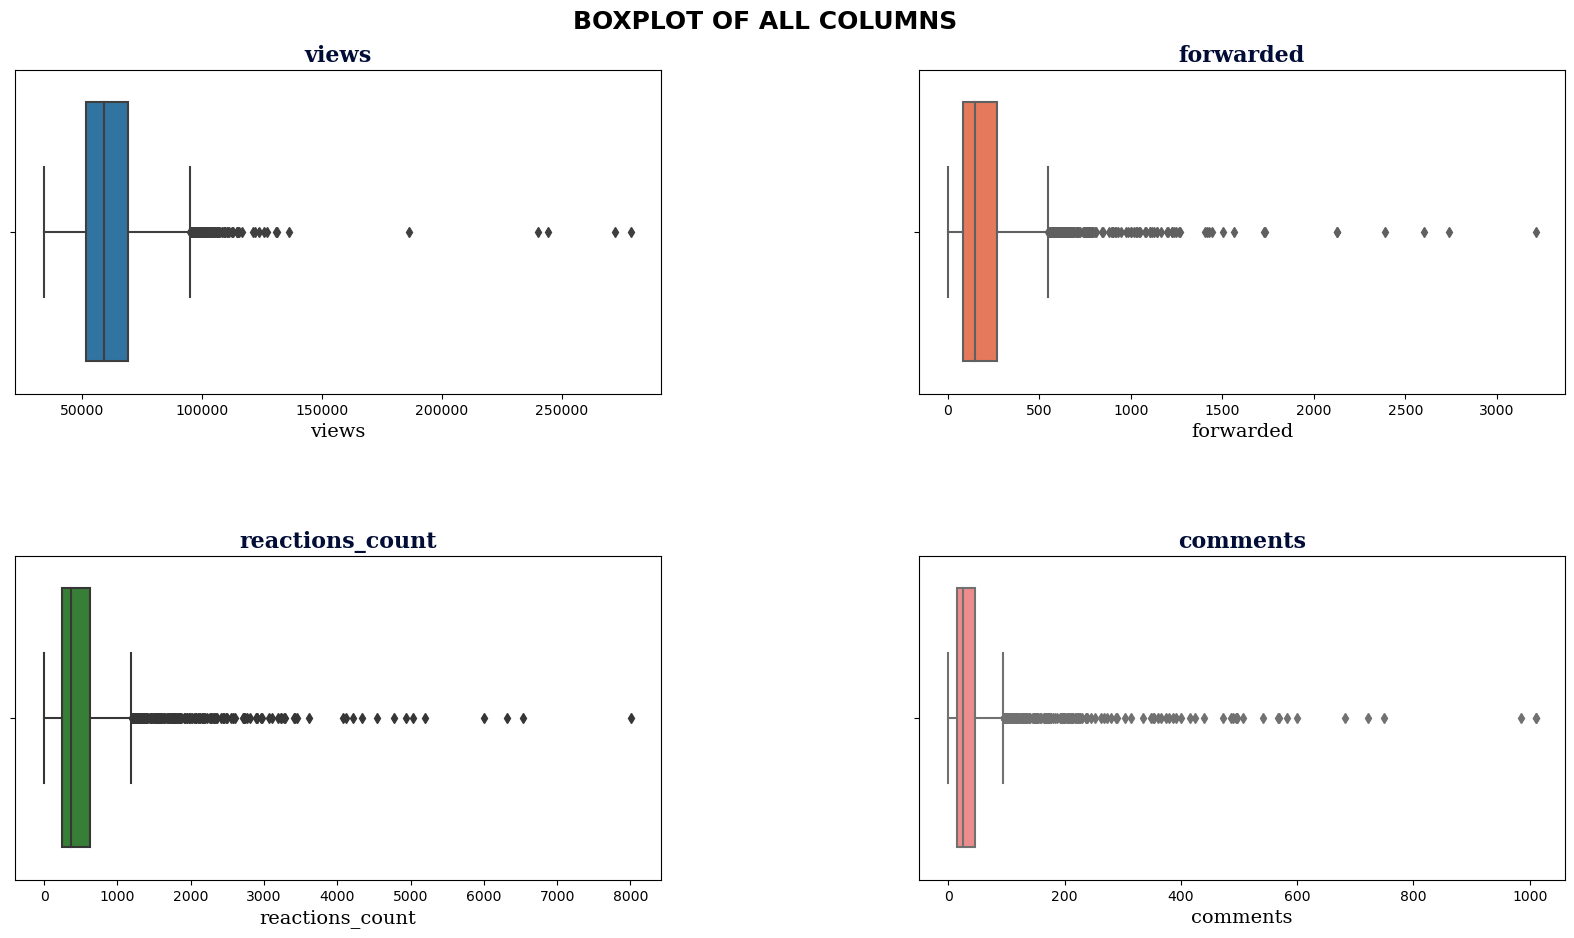

In [51]:
# выберем данные о просмотрах, репостах, реакциях и комментариях
num_columns = merged_df[['views', 'forwarded', 'reactions_count', 'comments']]

# построим графики боксплот
plt.rcParams['axes.facecolor'] = 'white'
fig = plt.figure(figsize=[20,10])
fig.suptitle('BOXPLOT OF ALL COLUMNS', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(num_columns):
    ax1 = fig.add_subplot(2,2, i+1);
    ax1 = sns.boxplot(data = merged_df, x=col, color= colours[i]);
    ax1.set_title(f'{col}', fontdict=axtitle_dict)
    ax1.set_xlabel(f'{col}', fontdict=axlab_dict)

plt.show()

In [52]:
# проверим также характерные значения с помощью метода describe
merged_df[['views', 'forwarded', 'reactions_count', 'comments']].describe()

,views,forwarded,reactions_count,comments
count,2679.000000,2679.000000,2679.000000,2679.000000
mean,62534.904815,210.465472,537.820082,42.287421
std,16866.397397,226.873676,561.831329,68.241807
min,34256.000000,2.000000,0.000000,0.000000
25%,51582.000000,80.000000,245.000000,14.000000
50%,59042.000000,145.000000,371.000000,26.000000
75%,69006.000000,266.000000,621.000000,46.000000
max,278962.000000,3212.000000,8012.000000,1010.000000


Можно сделать следующие выводы о данных по просмотрам, репостам, реакциям и комментариям:  

1. Межквартильный размах(IQR - диапазон, внутри которого лежит большинство данных):  
- просмотры ≈ от 51000 до 70000  
- репосты ≈ от 80 до 250  
- реакции ≈ от 250 до 600
- комментарии ≈ от 15 до 50

2. Медианные значения:  
- просмотры - 62534     
- репосты - 145
- реакции - 371
- комментарии - 26  

3. Выбросами являются:  
- просмотры - значения более 180000
- репосты - значения более 700
- реакции - значения более 1400
- комментарии - значения более 100  

### Посмотрим на выбросы

In [53]:
# просмотры
merged_df.query('views > 180000').sort_values('views', ascending=False)

,id,datetime,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date_YMD,total_subscribers,changes,date,new_subscribers,unsubscribed
2159,35809,2023-11-07 13:01:20,💯 100. Великих. Фильмов. XXI века\n\nПредставл...,278962.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",1224.0,"{'_': 'MessageReplies', 'replies': 113, 'repli...",1253,113,MessageMediaWebPage,2023-11-07,291172,1534,2023-11-07,2605,1179
2271,36059,2023-11-20 10:01:41,Не выходи из комнаты и ешь сыр 🧀\n\nТаким реце...,272087.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",288.0,"{'_': 'MessageReplies', 'replies': 20, 'replie...",782,20,MessageMediaPhoto,2023-11-20,346378,5305,2023-11-20,10708,5519
351,31733,2023-02-11 18:02:14,Прямо сейчас общаемся в прямом эфире с Владисл...,244143.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",29.0,"{'_': 'MessageReplies', 'replies': 24, 'replie...",206,24,MessageMediaWebPage,2023-02-11,234613,331,2023-02-11,351,50
349,31731,2023-02-11 14:30:30,"«Вавилон» — кино о кино, поэтому в нем много о...",239884.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaDocument', 'nopremium': Fal...",419.0,"{'_': 'MessageReplies', 'replies': 37, 'replie...",409,37,MessageMediaDocument,2023-02-11,234613,331,2023-02-11,351,50
2412,36462,2023-12-09 10:30:17,Журналист «Загадки дыры» пишет книгу о прошлом...,186321.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",236.0,"{'_': 'MessageReplies', 'replies': 14, 'replie...",505,14,MessageMediaWebPage,2023-12-09,432102,2849,2023-12-09,7991,5015


In [54]:
# изучим детальнее тексты постов
merged_df.query('views > 180000').sort_values('views', ascending=False)['text'].values

array(['💯 100. Великих. Фильмов. XXI века\n\nПредставляем наш новый спецпроект! На этой неделе в честь нашего дня рождения (сегодня нам 20 лет!) мы будем делать то, что любим больше всего —\xa0рассказывать вам про хорошее кино. \n\nИ начинаем мы со спецпроекта, где более 200 экспертов\xa0— режиссеров и\xa0продюсеров, шоураннеров и\xa0кинокритиков, писателей и\xa0сценаристов\xa0— выбрали **100 самых важных фильмов нашего века**.\n\nПредставляем [первую часть](https://www.kinopoisk.ru/media/article/4008591/?utm_source=telegram&utm_medium=social) нашего монументального топа. В\xa0нем про великие фильмы рассказывают [Егор Лоскутов](https://t.me/krinj), [Макс Шишкин](http://t.me/shishkino), [Екатерина Мцитуридзе](http://t.me/kate_blanche), [Ксения Лушева](https://t.me/podcastbaka), [Иван Трифонов](https://t.me/streamingverse), Марина Степнова, Дмитрий Нелидов и многие другие. \n\n#КП100ВеликихФильмов\n\n🔥 Подписывайтесь на [**«Кинопоиск»**](http://t.me/kinopoisk)',
       'Не выходи из комн

Больше всего просмотров (278962) собрал пост в честь дня рождения Кинопоиска от 7.11.2023, сопряженный с выходом спецпроекта от Кинопоиска "100 Великих Фильмов XXI века". Второе место занимает пост про Киллиана Мёрфи от 20.11.2023, вышедший накануне цифровой премьеры фильма "Оппенгеймер", ожидаемой 21 ноября 2023 г. Третье место по числу просмотров занимает пост с ссылкой на трансляцию прямого эфира со звездами сериала "Фандорин. Азазель" от 11.02.2023, недавно вышедшего на Кинопоиске. Четвертый по количеству просмотров пост от 11.02.2023 посвящен разбору фильма "Вавилон" с видеофрагментами, которые являются отсылками в другим фильмам. Пятый пост по просмотрам от 9.12.2023  - обзор четвертого сезона юмористического сериала "Внутри Лапенко" о 90-х.   

Как мы видим, большая часть постов с максимальным количеством просмотров, посвящены ожидаемым либо недавно вышедшим в прокат новинкам в мире кино. Таким образом, можно сделать вывод, что больше всего читатели просматривают посты именно с тематическим контентом, посвященным будущим или недавно вышедшим премьерам в прокате. 

In [55]:
# репосты
merged_df.query('forwarded > 700').sort_values('forwarded', ascending=False)

,id,datetime,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date_YMD,total_subscribers,changes,date,new_subscribers,unsubscribed
951,32906,2023-05-03 19:00:18,⚡Трейлер [второй](https://www.youtube.com/watc...,90295.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",3212.0,"{'_': 'MessageReplies', 'replies': 166, 'repli...",2225,166,MessageMediaWebPage,2023-05-03,260727,2857,2023-05-03,2887,50
1873,35108,2023-09-28 14:44:47,Палочки вверх 🪄\n\n[Умер](https://www.theguard...,103949.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",2739.0,"{'_': 'MessageReplies', 'replies': 196, 'repli...",3403,196,MessageMediaPhoto,2023-09-28,289270,83,2023-09-28,1420,1210
2178,35839,2023-11-09 15:16:35,"День рождения у Кинопоиска, а подарки — вам ❤️...",112558.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",2603.0,"{'_': 'MessageReplies', 'replies': 169, 'repli...",764,169,MessageMediaPhoto,2023-11-09,296145,3798,2023-11-09,6486,2670
2654,37029,2024-01-15 19:30:40,"Гай Ричи снял сериал по «Джентльменам», смотри...",98045.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",2390.0,"{'_': 'MessageReplies', 'replies': 56, 'replie...",1055,56,MessageMediaPhoto,2024-01-15,546859,2539,2024-01-15,7455,5023
756,32501,2023-04-04 19:01:04,Долгожданный [трейлер](https://www.youtube.com...,84390.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",2127.0,"{'_': 'MessageReplies', 'replies': 80, 'replie...",1110,80,MessageMediaWebPage,2023-04-04,257283,2492,2023-04-04,2402,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,31986,2023-03-02 00:01:15,[Дождались](https://t.me/kinopoisk_soon/1954)!...,77967.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",708.0,"{'_': 'MessageReplies', 'replies': 101, 'repli...",814,101,MessageMediaWebPage,2023-03-02,237281,26,2023-03-02,61,62
2350,36260,2023-12-01 09:45:22,"«Фуриоса» пришла! Смотрим кадры фильма, которы...",73121.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",704.0,"{'_': 'MessageReplies', 'replies': 74, 'replie...",930,74,MessageMediaPhoto,2023-12-01,400935,5881,2023-12-01,11714,5729
37,31193,2023-01-06 20:07:21,Сериал «Уэнсдэй» официально продлен на второй ...,66196.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaDocument', 'nopremium': Fal...",704.0,"{'_': 'MessageReplies', 'replies': 73, 'replie...",1596,73,MessageMediaDocument,2023-01-06,228247,442,2023-01-06,363,5
2393,36409,2023-12-07 10:59:25,Рукописи не горят!\n\nРассматриваем примечател...,77162.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",703.0,"{'_': 'MessageReplies', 'replies': 58, 'replie...",954,58,MessageMediaPhoto,2023-12-07,425139,4883,2023-12-07,9029,4485


Найден 85 пост с репостами более 700. Изучим детальнее тексты 5 постов c наибольшим количеством репостов:

In [56]:
merged_df.query('forwarded > 700').sort_values('forwarded', ascending=False).head()['text'].values

array(['⚡Трейлер [второй](https://www.youtube.com/watch?v=Way9Dexny3w) «Дюны» прибыл!\n\nТимоти Шаламе и Зендея на месте, к ним присоединились Флоренс Пью, Остин Батлер, Леа Сейду и Кристофер Уокен.\n\nСиквел фильма Дени Вильнёва выйдет 3 ноября.\n\n__Подписывайтесь на __[__Telegram-канал__](https://t.me/kinopoisk)__ Кинопоиска!__',
       'Палочки вверх 🪄\n\n[Умер](https://www.theguardian.com/stage/2023/sep/28/michael-gambon-star-of-harry-potter-and-the-singing-detective-dies-aged-82) британский и ирландский актер Майкл Гэмбон, известный по роли Альбуса Дамблдора.\n\nЕму было 82 года.',
       'День рождения у Кинопоиска, а подарки —\xa0вам ❤️❤️❤️\n\nДелимся крышесносным ботом, который сделает вам стикерпак, а из вас... персонажей фильма! Да-да, мы собрали лучшие киномемы, и теперь, чтобы стать Майклом Скоттом из «Офиса», Бриджит Джонс или Томми Вайсо, нужна лишь пара кликов!\n\nЗалетайте в бота уже сейчас и делитесь своим стикерпаком в комментах —\xa0**@Kinopoisk_Memes_bot****\n\n**🔥

Больше всего репостов (3212) набрал пост от 3.03.2023 с трейлером к фильму "Дюна-2". На втором месте (2739 репостов) находится пост от 28.09.2023 с новостью о смерти актера Майкл Гэмбон, известного по роли Альбуса Дамблдора. Третье место по репостам занимает пост от 9.11.2023 с новостью о выходе чат-бота с киномемами (2603 репоста). Четвертый пост от 15.01.2024, набравший 2390 репоста, с тизером и новостью о выходе сериала по фильму "Джентльмены". Пятый пост по количеству репостов (2127) - пост от 2.03.2023 с долгожданным трейлером к фильму "Барби", ожидаемом в прокате 21 июля 2023 г.   

Таким образом, можно сделать вывод, что больше всего репостов набирают посты с трейлерами/тизерами к ожидаемым новинкам в мире кино.

In [57]:
# реакции
merged_df.query('reactions_count > 1400').sort_values('reactions_count', ascending=False)

,id,datetime,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date_YMD,total_subscribers,changes,date,new_subscribers,unsubscribed
909,32799,2023-04-26 15:15:34,5 тысяч сердечек на этом посте и мы ставим Кен...,72894.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",383.0,"{'_': 'MessageReplies', 'replies': 169, 'repli...",8012,169,MessageMediaPhoto,2023-04-26,257581,-186,2023-04-26,37,142
1054,33123,2023-05-22 16:22:32,Ушла эпоха!\n\n__Будете __[__скучать__](https:...,70984.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",1045.0,"{'_': 'MessageReplies', 'replies': 164, 'repli...",6529,164,MessageMediaPhoto,2023-05-22,264271,78,2023-05-22,1250,1117
2462,36607,2023-12-17 10:02:01,Гэри Олдман благодарит судьбу за «Гарри Поттер...,91394.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",171.0,"{'_': 'MessageReplies', 'replies': 59, 'replie...",6311,59,MessageMediaPhoto,2023-12-17,448874,1869,2023-12-17,5304,3299
2643,37006,2024-01-13 17:01:29,Роберт Дауни-младший [считает](https://variety...,103564.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",114.0,"{'_': 'MessageReplies', 'replies': 106, 'repli...",6001,106,MessageMediaPhoto,2024-01-13,542299,2984,2024-01-13,8037,4909
2095,35634,2023-10-29 04:14:56,Умер звезда «Друзей» Мэттью Перри. Ему было 54...,62826.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",2124.0,"{'_': 'MessageReplies', 'replies': 136, 'repli...",5190,136,MessageMediaPhoto,2023-10-29,289030,331,2023-10-29,1568,1181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,32201,2023-03-13 06:28:51,"Три (точнее, четыре) главных человека индустри...",68150.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",603.0,NaN,1409,0,MessageMediaPhoto,2023-03-13,253288,2187,2023-03-13,613,0
2633,36964,2024-01-11 11:16:51,Два гения [встретятся](https://t.me/kinopoisk_...,101597.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",369.0,"{'_': 'MessageReplies', 'replies': 52, 'replie...",1406,52,MessageMediaPhoto,2024-01-11,535661,2727,2024-01-11,8660,5773
658,32316,2023-03-21 17:28:57,Великому Гари Олдману — 65!\n\nВ новом видео р...,62017.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaDocument', 'nopremium': Fal...",417.0,"{'_': 'MessageReplies', 'replies': 60, 'replie...",1404,60,MessageMediaDocument,2023-03-21,254062,219,2023-03-21,150,50
1146,33354,2023-06-06 17:46:18,Пока! Прощай! \n\nЗавершился наш любимый «Тед ...,53057.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",195.0,"{'_': 'MessageReplies', 'replies': 42, 'replie...",1403,42,MessageMediaWebPage,2023-06-06,264114,-115,2023-06-06,1095,1118


Найдено 138 постов с количеством реакций более 1400. Изучим детальнее тексты первых 5 постов c наибольшим количеством реакций:

In [58]:
merged_df.query('reactions_count > 1400').sort_values('reactions_count', ascending=False).head()['text'].values

array(['5\xa0тысяч сердечек на\xa0этом посте и\xa0мы\xa0ставим Кена-Гослинга на\xa0аватарку канала 💖',
       'Ушла эпоха!\n\n__Будете __[__скучать__](https://t.me/kinopoisk_Industry/1936)__ по привычному дубляжу Леонардо__ __ДиКаприо?\n__❤️__ - да__ \n👎__ - нет__',
       'Гэри Олдман благодарит судьбу за «Гарри Поттера» и «Темного рыцаря». Актер [признался,](https://www.indiewire.com/news/general-news/gary-oldman-harry-potter-and-batman-movies-saved-me-1234936398/) что блокбастеры спасли его и позволили проводить время с детьми после развода с женой. \n\n«В 42 года я проснулся разведенным и получил опеку над сыновьями, — рассказал Олдман. — Это было сложно, потому что в индустрии произошел сдвиг, и многие съемки велись в Венгрии, Будапеште, Праге, Австралии… Мне пришлось отказаться от многих ролей».\n\nПо словам актера, играя Сириуса Блэка и комиссара Гордона, он мог выполнять меньший объем работы за\xa0большее количество денег, а\xa0потом быть дома с\xa0детьми. \n\n__Какая из этих р

Больше всего реакций (8012) собрал пост от 26.04.2023 с прямым призывом к действию - поставить 5000 сердечек для того, чтобы на аватарке канала стояла фотография Кена-Гослинга. На втором месте (6529 реакций) находится пост от 22.05.2023 с призывом поставить реакцию на новость о смене актера, долгие годы озучивающего Леонардо ДиКаприо. На третьем месте (6311 реакции) находится пост от 17.12.2023 с призывом поставить разные реакции, выбрав любимую роль актера Гэри Олдмана, известному по фильмам "Гарри Поттер" и "Темный рыцарь". Четвертый пост по количеству реакций (6001) - пост от 14.01.2024 с вопросом о мнении читателей и призывом поставить реакцию на роль Тони Старка, сыгранной Робертом Дауни-младшим. Пятый пост от 29.10.2023, набравший 5190 реакций, посвящен новости о сметри актера Мэттью Перри, известному по культовому сериалу "Друзья".  

4 из 5 постов с наибольшим количеством реакций к ним направлены на взаимодействие с аудиторией канала и содержат прямой призыв к тому, чтобы читатель поставил реакцию. 

In [59]:
# комментарии
merged_df.query('comments > 100').sort_values('comments', ascending=False)

,id,datetime,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date_YMD,total_subscribers,changes,date,new_subscribers,unsubscribed
894,32763,2023-04-23 13:03:55,Ждем ваши ответы в комментах 👀,68163.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",88.0,"{'_': 'MessageReplies', 'replies': 1010, 'repl...",383,1010,MessageMediaPhoto,2023-04-23,257953,-36,2023-04-23,131,95
1091,33211,2023-05-28 12:07:40,Ждем ваши ответы в комментах 👀,64089.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",32.0,"{'_': 'MessageReplies', 'replies': 1010, 'repl...",340,1010,MessageMediaPhoto,2023-05-28,264513,103,2023-05-28,1342,1145
856,32698,2023-04-17 20:02:03,"Флешмоб! \n\nВыложите постер фильма, который в...",63110.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",132.0,"{'_': 'MessageReplies', 'replies': 985, 'repli...",528,985,MessageMediaPhoto,2023-04-17,257867,-17,2023-04-17,93,109
868,32709,2023-04-19 13:50:57,"Покажите сцену из фильма, во время которой вы ...",58389.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",120.0,"{'_': 'MessageReplies', 'replies': 749, 'repli...",1085,749,MessageMediaPhoto,2023-04-19,257999,129,2023-04-19,144,55
412,31859,2023-02-18 21:01:35,Ждем ответы в комментариях 🙌,66057.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",102.0,"{'_': 'MessageReplies', 'replies': 721, 'repli...",386,721,MessageMediaPhoto,2023-02-18,235516,236,2023-02-18,208,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,32285,2023-03-17 22:08:31,[Умер](https://variety.com/2023/film/obituarie...,87430.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",684.0,"{'_': 'MessageReplies', 'replies': 101, 'repli...",2156,101,MessageMediaPhoto,2023-03-17,253300,110,2023-03-17,118,66
1153,33365,2023-06-07 12:38:26,Что там у «Русалочки» и Disney? Все плохо! \n\...,49692.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",123.0,"{'_': 'MessageReplies', 'replies': 101, 'repli...",524,101,MessageMediaWebPage,2023-06-07,264084,-30,2023-06-07,1107,1100
2324,36189,2023-11-27 17:23:26,Дженна Ортега и Джейкоб Элорди идеально подошл...,72089.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",1143.0,"{'_': 'MessageReplies', 'replies': 101, 'repli...",1296,101,MessageMediaPhoto,2023-11-27,380115,3777,2023-11-27,8920,5289
487,31986,2023-03-02 00:01:15,[Дождались](https://t.me/kinopoisk_soon/1954)!...,77967.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",708.0,"{'_': 'MessageReplies', 'replies': 101, 'repli...",814,101,MessageMediaWebPage,2023-03-02,237281,26,2023-03-02,61,62


Найдено 179 постов с количеством комметариев более 100. Изучим детальнее тексты первых 5 поспостов c наибольшим количеством комметариев:

In [60]:
merged_df.query('comments > 100').sort_values('comments', ascending=False).head()['text'].values

array(['Ждем ваши ответы в комментах 👀', 'Ждем ваши ответы в комментах 👀',
       'Флешмоб! \n\nВыложите постер фильма, который вышел (или выйдет) в год вашего совершеннолетия. \n\nУ нас, Кинопоиска, это [«Гнев человеческий»](https://www.kinopoisk.ru/film/1318972/?utm_source=telegram&utm_medium=social) Гая Ричи 🙃',
       'Покажите сцену из\xa0фильма, во\xa0время которой вы\xa0всегда плачете. \n\nУ\xa0нас это [«Зеленая миля» ](https://hd.kinopoisk.ru/film/42e511a460839b298d96effd8de60c68?from_block=kp-button-online&watch=)с\xa0Томом Хэнксом 😢',
       'Ждем ответы в комментариях 🙌'], dtype=object)

Больше всего (1010 коомментариев) собрали посты с вопросом к читатетелям на фото и просьбой дать ответ в комментариях. Третий и четвертый по количеству (985 и 749) - посты с интерактивом-просьбой выложить постер/сцену из фильма. Пятый пост (721 комментарий) снова с вопросом на фото и просьбой дать ответ в комментариях.   

Таким образом, можно сделать вывод о том, что больше всего комментируются посты, которые, как и в случае с реакциями, подразумевают взаимодействие с читалелями и содержат какой-то вопрос или интерактив. 

## Типы публикаций

In [61]:
# посмотрим на структуру текста в постах на примере первых двух постов
merged_df['text'].values[:2]

array(['Вышел первый [трейлер](https://youtu.be/PKBKmaOFlsg) фильма «Вызов» Клима Шипенко — того самого, ради которого режиссер вместе с актрисой Юлией Пересильд поднимался на борт МКС. \n\nПремьера картины — 12 апреля 2023 года, в день космонавтики. \n\n«Вызов» стал первым фильмом, который снимался прямо на космической станции. О том, как проходила подготовка к съемкам, мы рассказывали [в нашем материале](https://www.kinopoisk.ru/media/news/4005231/?utm_source=telegram&utm_medium=social).',
       'Дождались!\n\nНа Кинопоиске вышел «Гром: Трудное детство» — полнометражный приквел боевика «Майор Гром: Чумной Доктор», посвященный взрослению главного героя в 1990-е.\n\nРассказываем в карточках самое важное, что нужно знать о фильме, и желаем [приятного просмотра](https://www.kinopoisk.ru/film/4771048/?utm_source=telegram&utm_medium=social) ❤️'],
      dtype=object)

Как мы видим, значения в колонке text неоднородные, в частности, в тексте присутствуют ссылки и эмоджи, которые могут указывать на определенный тип публикуемого контента.

Напишем функцию, которая проверит наличие ссылок и эмоджи, а затем присвоит типы публикаций каждому посту:

In [62]:
def categorize_links(text):
    # регулярное выражение для поиска ссылок
    link_regex = r'(https?://\S+)'
    links = re.findall(link_regex, text)

    if ('📸' in text or 'Фото: соцсети' in text) and '🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)' in text and len(links) == 1:
        return 'Фотографии'
    # проверяем, что есть только одна ссылка и это ссылка на Кинопоиск
    if '🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)' in text and len(links) == 1:
        return 'Текст'

    # проверяем наличие фотографий в тексте и ссылку на Кинопоиск
    categories = {
        'Кинопоиск медиа/новости': ['kinopoisk.ru/media/news', 'kinopoisk.ru/news'],
        'Кинопоиск новости тг': ['t.me/kinopoisk_soon'],
        'Кинопоиск медиа/статьи': ['kinopoisk.ru/media/article'],
        'Кинопоиск подборки': ['kinopoisk.ru/lists'],
        'Кинопоиск игры, тесты': ['kinopoisk.ru/media/game'],
        'Кинопоиск фильмы': ['kinopoisk.ru/film'],
        'Кинопоиск сериалы': ['kinopoisk.ru/series'],
        'Кинопоиск игры тг': ['t.me/igrapoisk'],
        'Кинопоиск новости тг': ['t.me/kinopoisk_soon'],
        'Кинопоиск видеоэссе тг': ['t.me/kinopoisk_videoessay'],
        'Кинопоиск ютуб': ['youtu.be', 'youtube.com'],
        'Кинопоиск плюс тг': ['t.me/plus_yndx'],
        'Букмейт': ['bookmate.ru'],
        'Яндекс музыка': ['music.yandex.ru'],
        'Подкаст': ['podcast.ru'],
        'Прочие ссылки': []  # для ссылок, которые не соответствуют другим категориям
    }

    post_categories = set()  # используем множество для уникальных категорий

    if not links:
        return 'Текст'

    for link in links:
        for category, keywords in categories.items():
            if any(keyword in link.lower() for keyword in keywords):
                post_categories.add(category)
                break
        if not post_categories:
            post_categories.add('Прочие ссылки')

    return ', '.join(post_categories)

# применим функцию к нашему DataFrame
merged_df['categories'] = merged_df['text'].apply(categorize_links)

# выводим первые несколько строк DataFrame для проверки результата
merged_df.head()

,id,datetime,text,views,reactions,with_media,forwarded,replies,reactions_count,comments,type_attachment,date_YMD,total_subscribers,changes,date,new_subscribers,unsubscribed,categories
0,31135,2023-01-01 09:15:26,Вышел первый [трейлер](https://youtu.be/PKBKma...,49611.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",101.0,"{'_': 'MessageReplies', 'replies': 19, 'replie...",340,19,MessageMediaWebPage,2023-01-01,226447,1337,2023-01-01,1214,32,"Кинопоиск ютуб, Кинопоиск медиа/новости"
1,31151,2023-01-01 20:23:33,Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...,57794.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",231.0,"{'_': 'MessageReplies', 'replies': 77, 'replie...",713,77,MessageMediaPhoto,2023-01-01,226447,1337,2023-01-01,1214,32,Кинопоиск фильмы
2,31150,2023-01-01 20:00:12,В широкий прокат вышел «Чебурашка» — вариация ...,57228.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",66.0,"{'_': 'MessageReplies', 'replies': 23, 'replie...",283,23,MessageMediaWebPage,2023-01-01,226447,1337,2023-01-01,1214,32,Кинопоиск медиа/статьи
3,31136,2023-01-01 10:00:51,Новый год — новые киновпечатления!🎄🎬\n\nУже се...,51746.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",92.0,"{'_': 'MessageReplies', 'replies': 40, 'replie...",411,40,MessageMediaPhoto,2023-01-01,226447,1337,2023-01-01,1214,32,Прочие ссылки
4,31147,2023-01-01 14:55:33,«Гром: Трудное детство» выходит на Кинопоиске ...,53993.0,"{'_': 'MessageReactions', 'results': [{'_': 'R...","{'_': 'MessageMediaPhoto', 'spoiler': False, '...",126.0,"{'_': 'MessageReplies', 'replies': 36, 'replie...",535,36,MessageMediaPhoto,2023-01-01,226447,1337,2023-01-01,1214,32,Яндекс музыка


In [63]:
merged_df['categories'].value_counts()

Кинопоиск медиа/статьи                                      802
Текст                                                       546
Прочие ссылки                                               292
Кинопоиск ютуб                                              196
Кинопоиск фильмы                                            179
                                                           ... 
Прочие ссылки, Кинопоиск фильмы, Кинопоиск медиа/новости      1
Кинопоиск медиа/статьи, Кинопоиск плюс тг                     1
Кинопоиск сериалы, Кинопоиск медиа/статьи, Букмейт            1
Кинопоиск новости тг, Прочие ссылки, Кинопоиск плюс тг        1
Кинопоиск подборки                                            1
Name: categories, Length: 83, dtype: int64

In [64]:
# возьмем топ-10 категорий контента и посмотрим на распределение просмотров постов
merged_df['categories'].value_counts().head(10)

Кинопоиск медиа/статьи                      802
Текст                                       546
Прочие ссылки                               292
Кинопоиск ютуб                              196
Кинопоиск фильмы                            179
Кинопоиск новости тг                        142
Кинопоиск медиа/новости                      87
Кинопоиск сериалы                            72
Подкаст                                      45
Кинопоиск фильмы, Кинопоиск медиа/статьи     30
Name: categories, dtype: int64

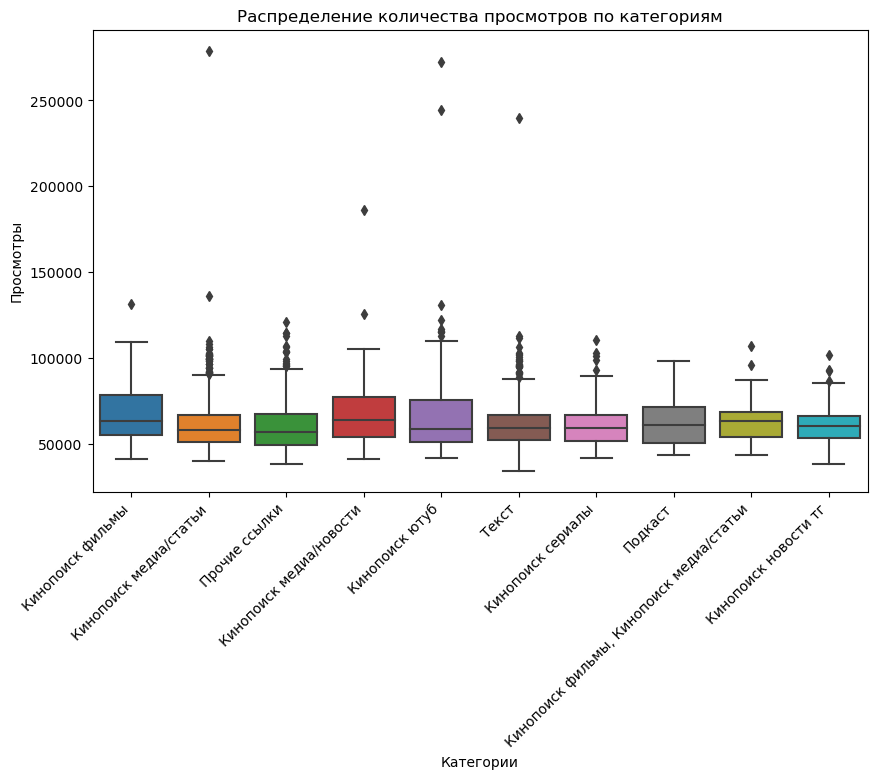

In [65]:
# cохраним топ-10 категорий контента
top_categories = merged_df['categories'].value_counts().head(10).index

# отфильтруем DataFrame, оставляя только посты с выбранными категориями
filtered_df = merged_df[merged_df['categories'].isin(top_categories)]

# построим ящик с усами для просмотров в каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='views', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Просмотры')
plt.title('Распределение количества просмотров по категориям')
plt.show()

График показывает, что количество просмотров у разных категорий постов почти не отличается, медианные значения находятся у всех категорий примерно на одном уровне. Это может быть связано с тем, что просмотры могут быть не самой информативной характеристикой поста.

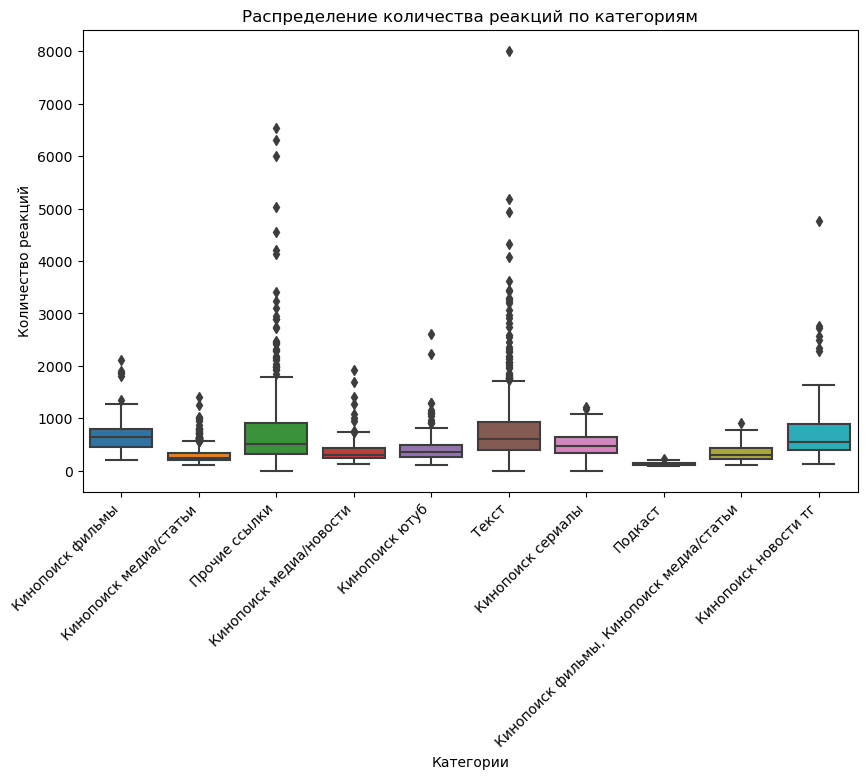

In [66]:
# строим ящик с усами для количества реакций в каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='reactions_count', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Количество реакций')
plt.title('Распределение количества реакций по категориям')
plt.show()

Распределение количества реакций по категориям публикаций оказалось более информативным:

Наиболее **низкими** медианами по количеству реакций выделяются категории:
- **Кинопоиск медиа/статьи** (ссылки статьи и материалы Кинопоиска на сайте)
- **Подкасты** (ссылки на подкасты)  
- **Кинопоиск медиа/новости** (ссылки на новости на сайте Кинопоиска)

Это может быть связано с тем, что такие категории подразумевают трату времени: чтобы ознакомиться с контентом, нужно переходить, читать, слушать информацию, а реакции - это более быстрый и эмоциональный способ взаимодействия подписчиков с телеграм-каналом.

**Больше всего** реакций набирают категории:
 - **Прочие ссылки** (внешние ссылки, обычно новостные)
 - **Тексты** - как правило, общение и взаимодействие Кинопоиска с подписчиками. Например, вопросы аудитории (прим.: 'как вы думаете?' и т.п.)

Резюмируя, больше реакций набирают посты, которые являются уникальным контентом телеграм-канала Кинопоиска, а также посты, которые нацелены на взаимодействие с подписчиками, плюс короткие новости и анонсы кино-новинок.

Данный показатель (количество реакций) является информативным и может быть использован в качестве метрики эффективности поста.  

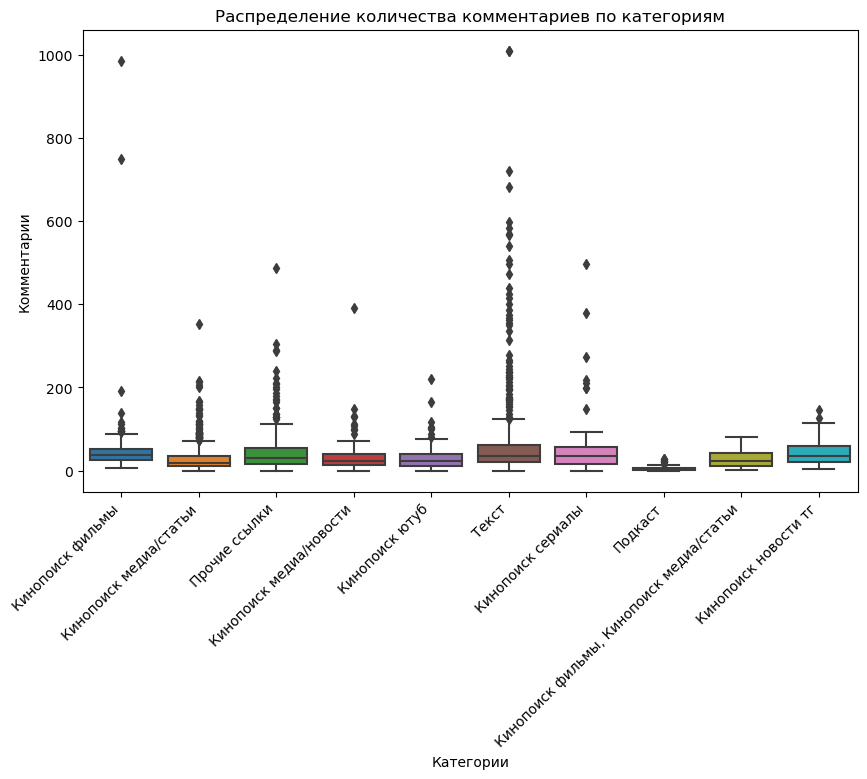

In [67]:
# строим ящик с усами для количества комментариев в каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='comments', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Комментарии')
plt.title('Распределение количества комментариев по категориям')
plt.show()

Количество комментариев по категориям, также как и просмотры, является не очень информативным показателем.  

Однако, хочется отметить, что в категории **подкасты** наблюдается меньше всего комментариев. Это может быть связано с тем, что пост представляет собой просто анонс нового подкаста/дайджеста и ссылку на него.

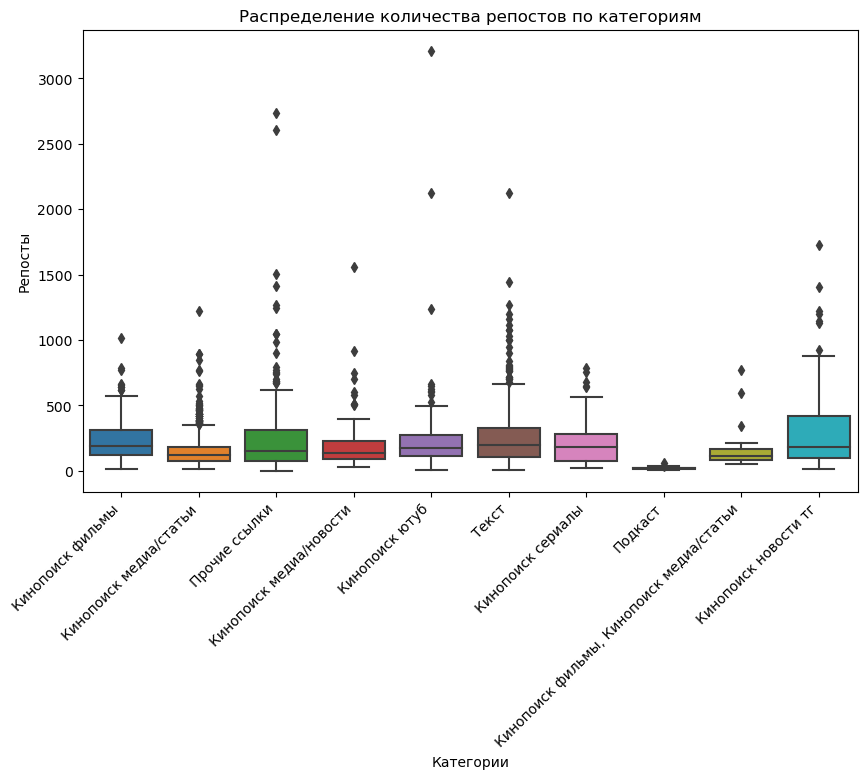

In [68]:
# строим ящик с усами для количества репостов в каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='forwarded', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Репосты')
plt.title('Распределение количества репостов по категориям')
plt.show()

Анализ количества репостов по категориям показал следующие результаты:  


- **Ссылки на фильмы** пересылают **чаще** других категорий  

Посты о фильмах и сериалах часто могут и хотят порекомендовать друзьям/знакомым, поэтому показатели репостов у данной категории самые высокие  

- **Низким** медианным значением снова выделяются **подкасты**   

Причина предположительно, та же: для рекомендации подкаста нужно выделить время, чтобы сначала его прослушать/посмотреть, сформировать мнение, и только потом принять решение делиться с кем-то или нет.


- **Высоким** количестов репостов выделяются категории:   

1) *Прочие ссылки* (как правило, новости)  
2) *Текст* (новости, анонсы премьер)  
3) *Кинопоиск сериалы* (ссылки на сериалы)  
4) *Кинопоиск новости тг*(посты с новостями из тематического новостного телеграм-канала Кинопоиска)  

Резюмируя, подписчики **чаще** всего делятся постами о **фильмах**, **сериалах** (рекомендации друзьям/знакомым), а также короткими текстовыми постами, с которыми можно быстро ознакомиться и переслать - новости, премьеры и новинки.

## Темы постов

Тексты постов в соцсетях являются довольно сложным объектом для анализа.   

При определении типа публикаций было выявлено, что тексты постов являются неоднородными, содержат разные специальные символы, эмоджи, ссылки и не имеют каких-либо явных ключевых признаков, по которым их можно бы было однозначно сгруппировать.  

Ниже нами будет рассмотрено несколько подходов, позволяющих сформировать темы для каждого поста.  

### Подход 1: хэштеги и подсчет частоты слов в посте

При анализе типа публикаций была замечена некоторая структура текста в посте - **заголовки**, отделяемые символами \n\n, **квадратные скобки** (кликабельный текст ссылки, который видит читатель вместо http-адреса), а также проставленные **хэштеги** для некоторых постов.

Предлагаю следующую логику определения тем постов:
- для постов с хэштегами выделим тему из хэштегов
- для остальных постов посчитаем частоту слов в посте и выберем в качестве темы наиболее встречаемое значение  

#### Определение тем для постов с хэштегами

Попробуем определить часть тем исходя их хэштегов:  
- сделаем отдельный столбец с хэштегами, если они есть в посте  
- приведем хэштеги к единому написанию и смысловой нагрузке

In [69]:
# напишем функцию для извлечения хэштегов из текста постов
def extract_and_format_hashtags(text):
    hashtags = re.findall(r'#\w+', text) if pd.notna(text) else []
    return ', '.join(hashtags) if hashtags else pd.NA

In [70]:
# применим функцию к столбцу text и сохраним хэштеги в новый столбец hashtags
merged_df['hashtags'] = merged_df['text'].apply(lambda x: extract_and_format_hashtags(x))

In [71]:
# напишем функцию для нормализации хэштегов
def normalize_hashtags(hashtags):
    if isinstance(hashtags, str):  # проверяем, что значение не NaN
        # разделяем хэштеги по запятой и выбираем первый
        normalized_hashtags_list = [hashtag.strip() for hashtag in hashtags.split(',')]
        normalized_hashtags = normalized_hashtags_list[0]
        # приводим все символы к нижнему регистру
        normalized_hashtags = normalized_hashtags.lower()
        # заменяем 'коротыше' на 'коротыш'
        normalized_hashtags = normalized_hashtags.replace('коротыше', 'коротыш')
        # удаляем годы из хэштега
        normalized_hashtags = re.sub(r'\b20\d{2}\b', '', normalized_hashtags)
        # удаляем все символы, кроме букв
        normalized_hashtags = re.sub(r'[^a-zA-Zа-яА-Я,]', '', normalized_hashtags)

        return normalized_hashtags
    else:
        return ''  # возвращаем пустую строку для пропущенных значений

In [72]:
# применим функцию нормализации хэштегов и сохраним значения в столбец topic
merged_df['topic'] = merged_df['hashtags'].apply(normalize_hashtags)

In [73]:
# заменим пустые значения на NaN
merged_df['topic'] = merged_df['topic'].mask(merged_df['topic'] == '', pd.NA)

In [74]:
merged_df['topic'].unique()

array([<NA>, 'кинопанорама', 'коротыш', 'оскар', 'киномемкп', 'нейрокп',
       'канны', 'дайджестновостей', 'кпитоги', 'мартимертв', 'подслушано',
       'летоскинопоиском', 'песочетверг', 'венеция',
       'рейтингфильмографии', 'кпвеликихигр', 'дождались', 'всейсемьей',
       'кпвеликихфильмов', 'кпновоеимя', 'скажимиядзаки',
       'кинопопятницам', 'гостькинопоиска', 'малкович', 'итогикп',
       'кпитогигода', 'дежурныйпокинопоиску'], dtype=object)

In [75]:
# создадим словарь для замены значений
replacement_dict = {
    'летоскинопоиском': 'рекомендации',
    'дайджестновостей': 'новости',
    'венеция': 'кинофестивали',
    'канны': 'кинофестивали',
    'кпновоеимя': 'актеры',
    'дежурныйпокинопоиску': 'дежурный_по_кинопоиску',
    'оскар': 'премии_и_номинации',
    'кинопанорама': 'рецензии_и_обзоры',
    'кинопопятницам': 'рецензии_и_обзоры',
    'рейтингфильмографии': 'рейтинги',
    'киномемкп': 'юмор',
    'нейрокп': 'юмор',
    'всейсемьей': 'рекомендации',
    'скажимиядзаки': 'премьеры',
    'мартимертв': 'рецензии_и_обзоры',
    'гостькинопоиска': 'интерактив',
    'песочетверг': 'интерактив',
    'малкович': 'актеры',
    'дождались': 'рецензии_и_обзоры'
}

# заменим значения с использованием словаря
merged_df['topic'] = merged_df['topic'].apply(lambda x: replacement_dict.get(x, x))

# заменим значения с помощью lambda-функции
merged_df['topic'] = merged_df['topic'].apply(lambda x: 'рейтинги' if isinstance(x, str) and 'великих' in x else x)
merged_df['topic'] = merged_df['topic'].apply(lambda x: 'рейтинги' if isinstance(x, str) and 'итоги' in x else x)

In [76]:
merged_df['topic'].value_counts()

коротыш                   113
рейтинги                   35
премии_и_номинации         32
рецензии_и_обзоры          25
кинофестивали              17
рекомендации               11
подслушано                  7
дежурный_по_кинопоиску      6
новости                     4
юмор                        3
интерактив                  3
актеры                      2
премьеры                    1
Name: topic, dtype: int64

#### Очистка + лемматизация текста постов

In [77]:
# напишем функцию для очистки текста постов
def remove_punctuation(text):
    punctuation_to_remove = string.punctuation + '—«»'
    return "".join([ch if ch not in punctuation_to_remove else ' ' for ch in text])

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # смайлики и эмоджи
                               u"\U0001F300-\U0001F5FF"  # символы и пиктограммы
                               u"\U0001F680-\U0001F6FF"  # символы транспорта и карты
                               u"\U0001F1E0-\U0001F1FF"  # флаги стран
                               u"\U00002500-\U00002BEF"  # китайские иероглифы
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
# удаление цифр
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
# удаление пробелов
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text)
# удаление ссылок
def remove_links(text):
    return re.sub(r'https?://\S+', '', str(text))

def preprocess_text(text):
    text = remove_links(text)
    text = remove_emoji(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_multiple_spaces(text)
    text = text.replace('ё', 'е')
    return text.strip().lower()

In [78]:
# применим функцию для очистки текста постов
merged_df['pre_text'] = merged_df['text'].apply(preprocess_text)

In [79]:
# создадим список пользовательских стоп-слов
post_stopwords = {'фильм', 'подписываться', 'кинопоиск',
                 'который', 'свой', 'почему', 'самый',
                  'это', 'хороший', 'первый', 'второй', 'рассказывать',
                  'наш', 'кот', 'смотреть', 'мэнди', 'день', 'слово', 'фанни',
                  'возможно', 'включать', 'группа', 'завтра', 'канал', 'getty',
                  'images', 'фото', 'легион', 'медиа'}

# объединим со значениями библиотеки nltk
custom_stop_words = set(stopwords.words('russian')).union(post_stopwords)

In [80]:
# создадим экземпляр класса MorphAnalyzer для лемматизации
parser = MorphAnalyzer()

# напишем функцию для обработки текста с использованием pymorphy2 и NLTK
def preprocess_lemm(input_text):
    tokenized_text = word_tokenize(input_text)
    lemmatized_text = [parser.parse(word)[0].normal_form for word in tokenized_text]
    final_lemm = " ".join([word for word in lemmatized_text if len(word) > 3 and word not in custom_stop_words])
                        ## оставим слова > 3х букв

    return final_lemm

/Users/yana_shinkaryukmail.ru/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/yana_shinkaryukmail.ru/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/yana_shinkaryukmail.ru/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/yana_shinkaryukmail.ru/anaconda3/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is d

In [81]:
# применим функцию для лемматизации текста
merged_df['lemm_text'] = merged_df['pre_text'].apply(preprocess_lemm)

In [82]:
# проверим результат
merged_df[['text', 'pre_text', 'lemm_text']].head()

,text,pre_text,lemm_text
0,Вышел первый [трейлер](https://youtu.be/PKBKma...,вышел первый трейлер фильма вызов клима шипенк...,выйти трейлер вызов клим шипенко ради режиссёр...
1,Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...,дождались на кинопоиске вышел гром трудное дет...,дождаться выйти гром трудный детство полнометр...
2,В широкий прокат вышел «Чебурашка» — вариация ...,в широкий прокат вышел чебурашка вариация на т...,широкий прокат выйти чебурашка вариация тема с...
3,Новый год — новые киновпечатления!🎄🎬\n\nУже се...,новый год новые киновпечатления уже сегодня на...,новый новый киновпечатление сегодня посмотреть...
4,«Гром: Трудное детство» выходит на Кинопоиске ...,гром трудное детство выходит на кинопоиске веч...,гром трудный детство выходить вечером послушат...


#### Определение тем из частых значений

In [83]:
# cоздадим срез датафрейма с пустыми значениями в колонке 'topic'
no_topic = merged_df[merged_df['topic'].isna()]

In [84]:
from collections import Counter

# напишем функцию для подсчета частоты слов
def count_word_frequency(lemm_text):
    words = lemm_text.split()
    word_count = Counter(words)
    # оставим только слова с частотой больше 1
    filtered_word_count = {word: count for word, count in word_count.items() if count > 1}
    return word_count

In [85]:
# применим функцию к каждой строке
no_topic['freq_text'] = no_topic['lemm_text'].apply(count_word_frequency)

In [86]:
# сделаем сортировку значений словаря по убыванию частоты
no_topic['freq_text'] = no_topic['freq_text'].apply(
    lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))

In [87]:
# проверим результат
no_topic[['id', 'text', 'lemm_text', 'freq_text']].head()

,id,text,lemm_text,freq_text
0,31135,Вышел первый [трейлер](https://youtu.be/PKBKma...,выйти трейлер вызов клим шипенко ради режиссёр...,"{'вызов': 2, 'выйти': 1, 'трейлер': 1, 'клим':..."
1,31151,Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...,дождаться выйти гром трудный детство полнометр...,"{'гром': 2, 'дождаться': 1, 'выйти': 1, 'трудн..."
2,31150,В широкий прокат вышел «Чебурашка» — вариация ...,широкий прокат выйти чебурашка вариация тема с...,"{'советский': 2, 'вместо': 2, 'шапокляк': 2, '..."
3,31136,Новый год — новые киновпечатления!🎄🎬\n\nУже се...,новый новый киновпечатление сегодня посмотреть...,"{'новый': 2, 'киновпечатление': 1, 'сегодня': ..."
4,31147,«Гром: Трудное детство» выходит на Кинопоиске ...,гром трудный детство выходить вечером послушат...,"{'гром': 2, 'трудный': 2, 'детство': 2, 'выход..."


In [88]:
# запишем в качестве темы слова, которые чаще всего встречаются в посте
## напишем функцию для оставления только ключа с максимальной частотой
def get_max_word(row):
    word_counts = row['freq_text']
    if word_counts:
        max_word = max(word_counts, key=word_counts.get)
        return max_word
    else:
        return None

# применим функцию к каждой строке
no_topic['topic'] = no_topic.apply(get_max_word, axis=1)

In [89]:
# посмотрим на значения топ-10 тем
no_topic['topic'].value_counts().head(10)

новый      70
сериал     67
ждать      40
сезон      24
игра       21
друг       21
выйти      17
подкаст    16
джон       16
кино       13
Name: topic, dtype: int64

In [90]:
# создадим словарь для замены значений
replacement_dict = {
    'сезон': 'сериалы',
    'сериал': 'сериалы',
    'новый': 'премьеры',
    'кино': 'рекомендации',
    'джон': 'джон_уик',
    'ждать': 'вопросы_читателям',
    'выйти': 'премьеры',
    'игра': 'спецпроект_игры'
}

# заменим значения с использованием словаря
no_topic['topic'] = no_topic['topic'].apply(lambda x: replacement_dict.get(x, x))

In [91]:
# запишем полученные значения в датафрейм 
merged_df['topic'] = merged_df['id'].map(no_topic.set_index('id')['topic']).combine_first(merged_df['topic'])

In [92]:
# посмотрим на топ-10 тем постов
merged_df['topic'].value_counts().head(10)

коротыш               113
сериалы                91
премьеры               88
вопросы_читателям      40
рейтинги               35
премии_и_номинации     32
рецензии_и_обзоры      25
рекомендации           24
друг                   21
спецпроект_игры        21
Name: topic, dtype: int64

- Самый популярный контент в публикуемых постах - видео из специальной рубрики "**коротыш**" (113 постов), которая представляет собой короткие видео-отрывки из разных фильмов    
- Далее следуют темы **сериал** (92 поста) и **сезон** (42 поста) - в основном, посты о выходе новых сериалов или их сезонов, обсуждение персонажей и актеров  
- Четвертыми и пятыми по распространенности являюстя посты о **рейтингах** (35 постов), **премиях и номинациях** (32 поста).   
- За ними следуют посты с **вопросами** к читателям (30 постов) и репосты постов из тематического канала "Кинопоиск Игры" (30 постов, контент про игровую индустрию)  
- Замыкают топ-10 популярных тем посты с темой **"друг"** (27 постов) - подавляющая часть которых это обращение и вопросы к читателям, интерактивы с ними, чуть реже новости о партнерских проектах и посты с **рецензиями и обзорами** на фильмы и сериалы (25 постов).  

#### Боксплоты для топ-10 тем постов

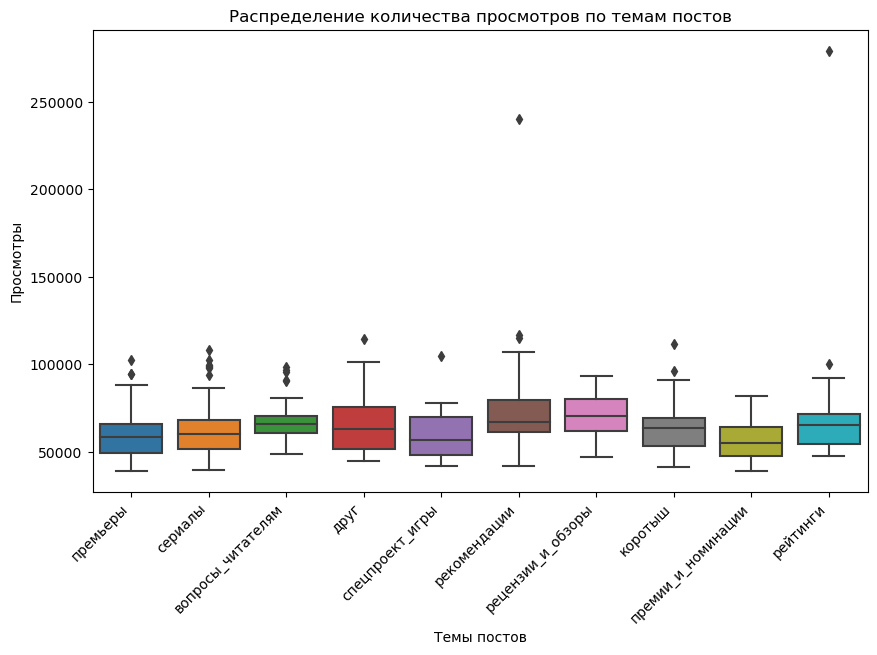

In [93]:
# сохраним топ-10 тем постов
top_topic = merged_df['topic'].value_counts().head(10).index

# фильтруем DataFrame, оставляя только строки с выбранными темами
filtered_df = merged_df[merged_df['topic'].isin(top_topic)]

# построим ящик с усами для просмотров каждой темы из топ-10
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='views', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Просмотры')
plt.title('Распределение количества просмотров по темам постов')
plt.show()

Распределение количества просмотров по темам довольно информативно:  
- **Больше** всего просматривают **посты-рекомендации**, а также **рецензии и обзоры** фильмов  
- Высокие показатели по количеству просмотров также у постов с темой **"друг"**  
- **Меньше** всего просмотров набирают посты о **премиях и номинациях**, а также репосты из тематического канала **"Кинопоиск Игры"** 

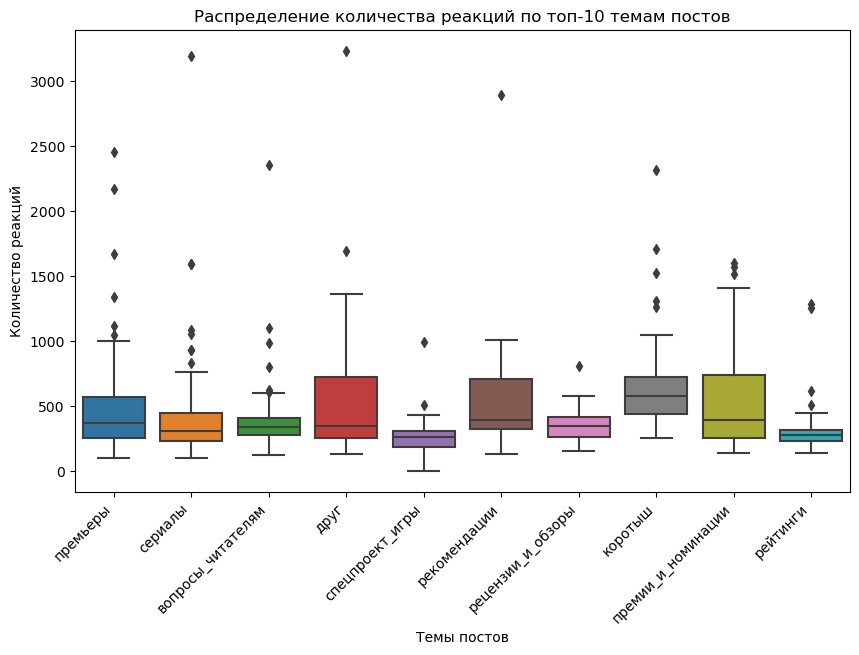

In [94]:
# строим ящик с усами для количества реакций каждой темы из топ-10
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='reactions_count', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Количество реакций')
plt.title('Распределение количества реакций по топ-10 темам постов')
plt.show()

Количество реакций также довольно показательно и разнится для разных тем постов:  
- **Больше** всего реакций получают посты со **взаимодействием с читателями** (тема "друг"), **рекомендации**, видео из рубрики "**коротыш**" и посты о грядущих или прошедших **премиях** и **номинациях** 
- **Меньше** всего реакций ставят на посты про **игры** и **рейтинги**

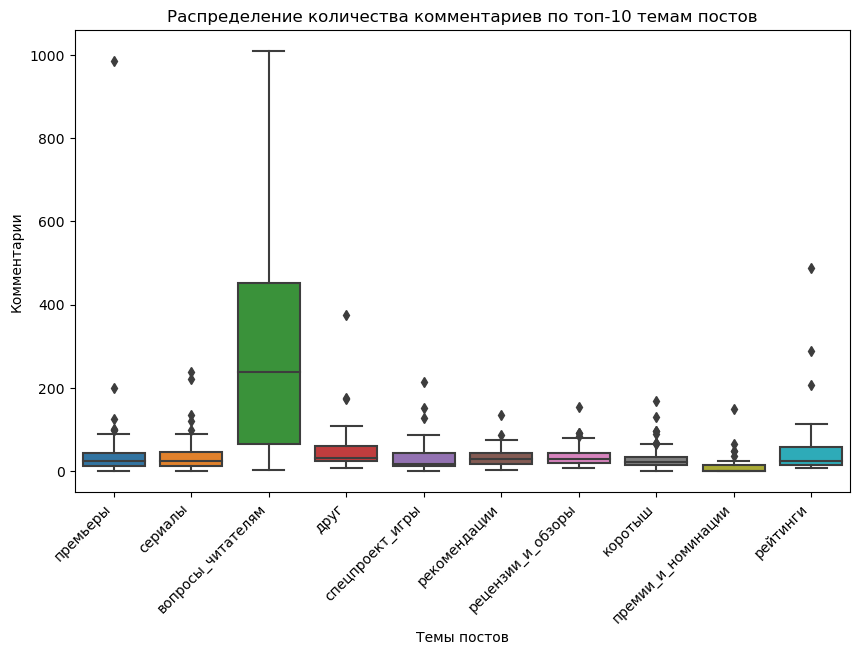

In [95]:
# cтроим ящик с усами для количества комментариев каждой темы из топ-10
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='comments', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Комментарии')
plt.title('Распределение количества комментариев по топ-10 темам постов')
plt.show()

Как мы видим, количество комментариев не является слишком информативным показателем в разрезе тем постов.   

Все темы, за исключением одной - **вопросы к читателям**, которая содержит в текстах прямой призыв к действию ответить в комментариях, слабо комментируются.  
- **Меньше всего** читатели комментируют посты про **премии и номинации**, остальные темы имеют схожее количество комментариев.  

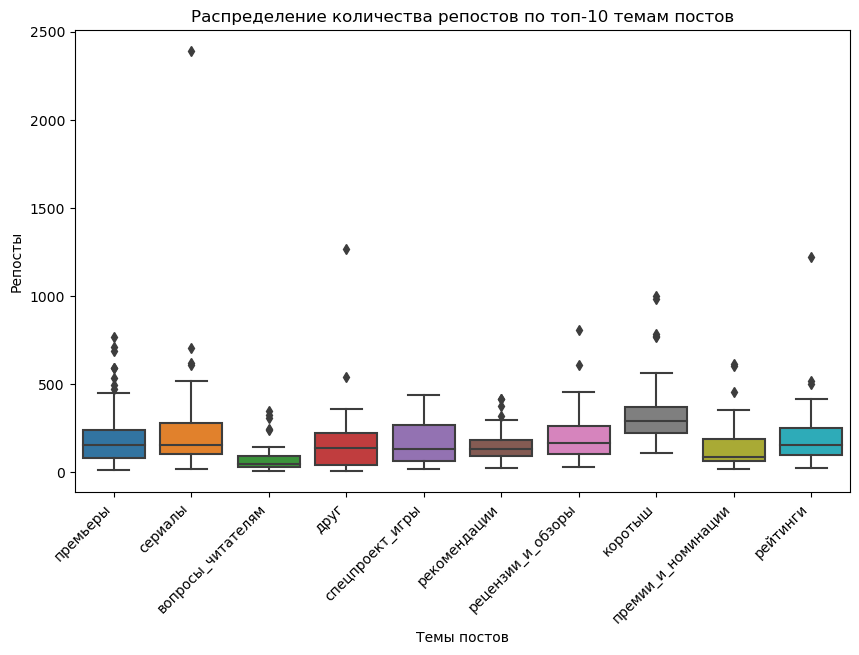

In [96]:
# cтроим ящик с усами для количества репостов каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='forwarded', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Репосты')
plt.title('Распределение количества репостов по топ-10 темам постов')
plt.show()

Количество репостов в разрезе тем постов является слабо информативным показателем.  

Однако, стоит отметить, что **больше** всего читатели репостят **видео-контент** (рубрика "коротыш"), а **меньше** всего посты с **вопросами к читателям**.  

Остальные темы имеют схожее количество репостов.

### Подход 2: моделирование тем методами machine learning

####  Подготовка данных

In [97]:
# биграммы
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([text.split() for text in merged_df['lemm_text']])

# выберем только те, что встречаются не менее 5 раз 
finder.apply_freq_filter(5)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram, lang='rus')
    # отладочная информация
    print("Bigram:", bigram)
    print("Tags:", tag)
    # проверяем, что оба элемента биграммы являются существительными или прилагательными
    if (tag[0][1].startswith('S') or tag[0][1].startswith('A')) and (tag[1][1].startswith('S') or tag[1][1].startswith('A')):
        return True
    return False

filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

Bigram: ('arturo', 'holmes')
Tags: [('arturo', 'NONLEX'), ('holmes', 'NONLEX')]
Bigram: ('вино', 'дизель')
Tags: [('вино', 'S'), ('дизель', 'S')]
Bigram: ('кристен', 'стюарт')
Tags: [('кристен', 'A=m'), ('стюарт', 'S')]
Bigram: ('натали', 'портман')
Tags: [('натали', 'V'), ('портман', 'S')]
Bigram: ('тайка', 'вайтити')
Tags: [('тайка', 'S'), ('вайтити', 'S')]
Bigram: ('уолл', 'стрит')
Tags: [('уолл', 'S'), ('стрит', 'V')]
Bigram: ('rotten', 'tomatoes')
Tags: [('rotten', 'NONLEX'), ('tomatoes', 'NONLEX')]
Bigram: ('джодить', 'фостер')
Tags: [('джодить', 'V'), ('фостер', 'S')]
Bigram: ('риза', 'уизерспун')
Tags: [('риза', 'V'), ('уизерспун', 'S')]
Bigram: ('энтони', 'хопкинс')
Tags: [('энтони', 'S'), ('хопкинс', 'A=pl')]
Bigram: ('венсан', 'кассель')
Tags: [('венсан', 'V'), ('кассель', 'S')]
Bigram: ('бенедикт', 'камбербэтч')
Tags: [('бенедикт', 'S'), ('камбербэтч', 'S')]
Bigram: ('atomic', 'heart')
Tags: [('atomic', 'NONLEX'), ('heart', 'NONLEX')]
Bigram: ('star', 'wars')
Tags: [('star'

In [98]:
# напишем функцию для замены n-грамм
def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [99]:
# применим функцию для замены n-грамм
merged_df['lemm_text'] = merged_df['lemm_text'].map(lambda x: replace_ngram(x))

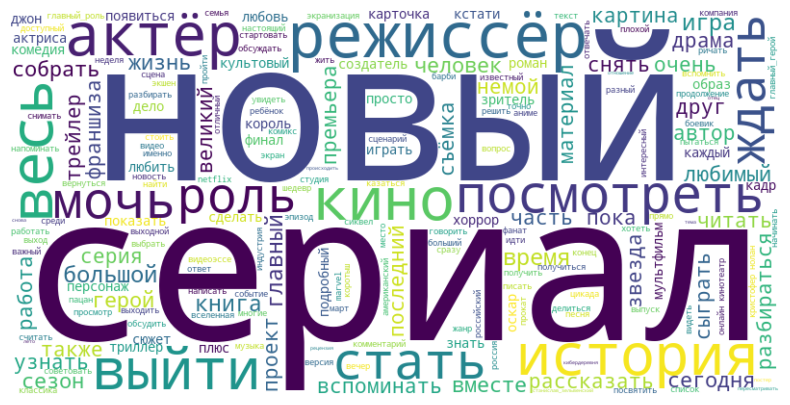

In [100]:
# объединяем текст из столбца датафрейма в одну строку
text = ' '.join(merged_df['lemm_text'])

# создаем объект WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# отобразим облако слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [101]:
merged_df['lemm1'] = merged_df['lemm_text'].apply(lambda x: x.split())
merged_df['lemm1']

0       [выйти, трейлер, вызов, клим, шипенко, ради, р...
1       [дождаться, выйти, гром_трудный_детство, полно...
2       [широкий, прокат, выйти, чебурашка, вариация, ...
3       [новый, новый, киновпечатление, сегодня, посмо...
4       [гром_трудный_детство, выходить, вечером, посл...
                              ...                        
2674    [психо, вырезать, сцена, душа, джон, рэмбо, мо...
2675    [джереми, аллен, уайт, пройти, путь, роль, лип...
2676    [новый, постер, мастер_маргарита, посвятить, б...
2677    [борис, котик, мастер_маргарита, ожидать, прям...
2678    [резня, роман_поланский, семейный, пара, разби...
Name: lemm1, Length: 2679, dtype: object

#### Модель LDA

In [102]:
# делим данные на обучающую и тестовую выборки
X_train, X_test = train_test_split(merged_df['lemm1'], test_size=0.2, random_state=10)

In [103]:
def transform_data(data: pd.Series) -> list:
    # преобразуем объект Series в список строк и удаляем значения None и пустые строки
    transform_lst = [str(x) for x in data if x not in [None, '']]  
    return transform_lst

train_lst = transform_data(X_train)
test_lst = transform_data(X_test)

In [104]:
# векторизируем текстовые данные
vector_ben = CountVectorizer(
    analyzer='word',
    min_df=5)

train_vec_ben = vector_ben.fit_transform(train_lst)
test_vec_ben = vector_ben.transform(test_lst)

In [105]:
# построим модель латентного размещения Дирихле
lda_model_ben = LatentDirichletAllocation(
    # задаем кол-во тем
    n_components=10,
    max_iter=20,
    learning_method='online',
    random_state=10,
    n_jobs=-1,
)
lda_model_ben.fit(train_vec_ben)
print(lda_model_ben)

LatentDirichletAllocation(learning_method='online', max_iter=20, n_jobs=-1,
                          random_state=10)


In [106]:
# оценим качество модели LDA на тестовых данных
## выведем коэф-т логарифмического правдоподобия 
print("Log Likelihood: ", lda_model_ben.score(test_vec_ben))

## выведем значение перплексии (мера сложности модели, где более низкое значение указывает на более точную и лучшую модель)
print("Perplexity: ", lda_model_ben.perplexity(test_vec_ben))

Log Likelihood:  -72158.28413400595
Perplexity:  6887.833236948271


In [107]:
def get_coherence_mean(model, texts, n_top_words=20):
    """Получение средней оценки когерентности"""

    # кол-во тем
    topics = model.components_

    # получение токенов
    texts = [[word for word in doc.split()] for doc in texts]
    # создание словаря с использованием gensim
    dictionary = corpora.Dictionary(texts)

    # создание корпуса на основе матрицы подсчета слов
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # получение ТОП-слов для каждой темы
    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [108]:
get_coherence_mean(lda_model_ben, test_lst)

0.784503951693098

In [109]:
RAND = 10

def compute_coherence_values(vec_train_text,
                             test_text,
                             min_topic=5,
                             max_topic=20,
                             step=5):
    """Вычисление оценок в зависимости от кол-ва тематик"""

    coherence_values = []
    model_list = []

    for num_topics in tqdm_notebook(range(min_topic, max_topic, step)):
        model = LatentDirichletAllocation(
            max_iter=10,
            n_components=num_topics,
            learning_method='online',
            random_state=RAND,
            n_jobs=-1,
        )
        model.fit(vec_train_text)

        model_list.append(model)
        coherence_values.append(get_coherence_mean(model, test_text))

    return model_list, coherence_values

In [110]:
from tqdm import tqdm_notebook
min_topic = 5
max_topic = 30
step = 5

model_list, coherence_values = compute_coherence_values(vec_train_text=train_vec_ben,
                                                        test_text=test_lst,
                                                        min_topic=min_topic,
                                                        max_topic=max_topic,
                                                        step=step)

/var/folders/ky/j6vzlgw51wv8bnmp3k0tc5j00000gn/T/ipykernel_66024/2140947570.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_topics in tqdm_notebook(range(min_topic, max_topic, step)):


  0%|          | 0/5 [00:00<?, ?it/s]

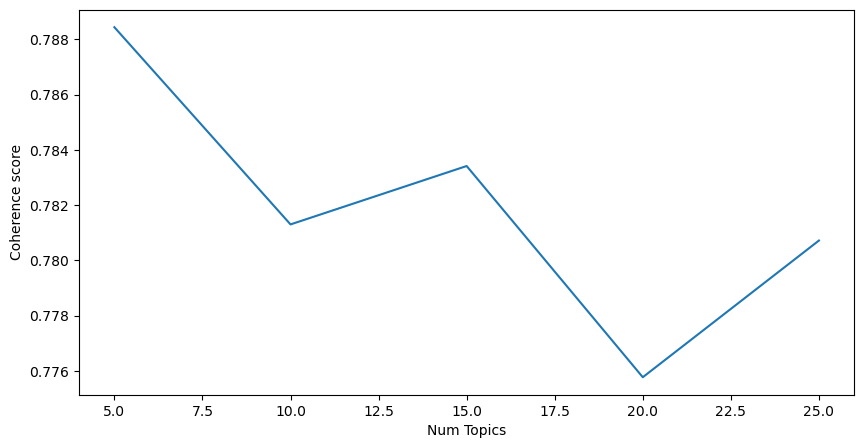

In [111]:
x = range(min_topic, max_topic, step)

plt.figure(figsize=(10, 5))

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show()

In [112]:
for n_topics, coherence in zip(x, coherence_values):
    print(f"Num Topics = {n_topics}, Coherence = {coherence:.3f}")

Num Topics = 5, Coherence = 0.788
Num Topics = 10, Coherence = 0.781
Num Topics = 15, Coherence = 0.783
Num Topics = 20, Coherence = 0.776
Num Topics = 25, Coherence = 0.781


In [113]:
# построим модель латентного размещения Дирихле
lda_model_ben = LatentDirichletAllocation(
    # задаем кол-во тем
    n_components=15,
    max_iter=20,
    learning_method='online',
    random_state=10,
    n_jobs=-1,
)
lda_model_ben.fit(train_vec_ben)
print(lda_model_ben)

LatentDirichletAllocation(learning_method='online', max_iter=20,
                          n_components=15, n_jobs=-1, random_state=10)


In [114]:
get_coherence_mean(lda_model_ben, test_lst)

0.7828976107255049

In [115]:
pyLDAvis.enable_notebook()

panel = pyLDAvis.lda_model.prepare(lda_model_ben,
                                 test_vec_ben,
                                 vector_ben,
                                 mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
10     12.781827  18.084135       1        1  19.805329
3     -45.132931   2.402399       2        1  16.038680
2     -11.862201 -45.641640       3        1  14.638669
9     -38.756176  35.574646       4        1  13.028854
1      -7.480247  47.703453       5        1   8.454102
4      24.220160  48.875576       6        1   5.183773
6      63.481483  -3.016784       7        1   4.947743
5      44.824760 -31.722147       8        1   3.628338
12     32.081921  -1.380091       9        1   3.461133
14     19.536676 -51.683926      10        1   3.257660
11    -41.035923 -30.578344      11        1   2.523674
13     47.605438  27.325224      12        1   1.809882
8     -14.257207  15.401216      13        1   1.386879
0      11.648046 -19.902372      14        1   1.282882
7     -14.409796 -12.250301      15        1   0.552403, topic_info=                Term       Freq      Total Category  logprob  loglift
1517        режиссёр  50.000000  50.000000  Default  30.0000  30.0000
247           вопрос  13.000000  13.000000  Default  29.0000  29.0000
494            ждать  41.000000  41.000000  Default  28.0000  28.0000
1560            роль  26.000000  26.000000  Default  27.0000  27.0000
582             игра  30.000000  30.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
803            лидер   0.013918   2.112280  Topic15  -8.0835   0.1763
1961         фаворит   0.013918   2.646858  Topic15  -8.0835  -0.0493
1611  сезон_пищеблок   0.013918   2.831295  Topic15  -8.0835  -0.1166
1052         обещать   0.013918   2.675441  Topic15  -8.0835  -0.0600
2029         целиком   0.013918   1.160235  Topic15  -8.0835   0.7755

[798 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0        10  0.667886    amazon
1         1  0.335117     apple
1         4  0.111706     apple
1         6  0.446823     apple
2         3  0.791233  bookmate
...     ...       ...       ...
2118      5  0.867484      эссе
2124     11  0.779959      юлия
2131      7  0.906389  якутский
2137      6  1.015662  японский
2139      1  1.026768   яркость

[1171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 3, 10, 2, 5, 7, 6, 13, 15, 12, 14, 9, 1, 8])

### Исследование разницы в количестве просмотров, репостов, реакций и комментариев у постов с самыми распространенными темами

In [116]:
# сохраним 3 наиболее крупные темы постов
selected_topics = ['коротыш', 'сериалы', 'премьеры']

In [117]:
# отберем посты с наиболее крупными темами и посмотрим, если между ними стат. значимость 
# по просмотрам, репостам, количеству реакций и комментариям
selected_data = merged_df[merged_df['topic'].isin(selected_topics)]

In [118]:
# сохраним в отдельные переменные посты с разными темами
topic_a_data = selected_data[selected_data['topic'] == 'коротыш']
topic_b_data = selected_data[selected_data['topic'] == 'сериалы']
topic_c_data = selected_data[selected_data['topic'] == 'премьеры']

In [119]:
# выделим столбцы с числовыми хакартеристиками постов
numeric_values = selected_data[['views', 'forwarded', 'reactions_count', 'comments']]

# проверим нормальность распределения, применив тест Шапиро-Уилка
statistic, p_value = shapiro(numeric_values)

# Выводим результаты теста
print("Shapiro-Wilk test statistic:", statistic)
print("p-value:", p_value)

# Проверяем гипотезу о нормальности распределения
alpha = 0.05  # задаем уровень стат.значимости
if p_value > alpha:
    print("Распределение данных является нормальным")
else:
    print("Распределение данных не является нормальным")

Shapiro-Wilk test statistic: 0.6021028757095337
p-value: 1.401298464324817e-45
Распределение данных не является нормальным


In [120]:
# применим тест Краскела-Уоллиса для каждого параметра, так как распределение не нормальное
for param in ['views', 'forwarded', 'reactions_count', 'comments']:
    h_statistic, p_value = kruskal(topic_a_data[param], 
                                   topic_b_data[param],
                                   topic_c_data[param])
    print(f"Тест Краскела-Уоллиса для параметра '{param}':")
    print("H-статистика:", h_statistic)
    print("p-значение:", p_value)
    print()

Тест Краскела-Уоллиса для параметра 'views':
H-статистика: 6.961384722751359
p-значение: 0.030786088553549605

Тест Краскела-Уоллиса для параметра 'forwarded':
H-статистика: 57.426765708758644
p-значение: 3.3879443618855845e-13

Тест Краскела-Уоллиса для параметра 'reactions_count':
H-статистика: 60.269240686355104
p-значение: 8.17900871052717e-14

Тест Краскела-Уоллиса для параметра 'comments':
H-статистика: 0.6718661110701845
p-значение: 0.7146709474788363



Полученные результаты указывают на существенные различия в количестве просмотров, репостов, реакций и комментариев между постами с разными темами.   
Тест Краскела-Уоллиса показал, что существует:     
- статистически значимая разница в количестве просмотров между постами с разными темами 
- очень высокая статистически значимая разница в количестве комментариев между постами с разными темами  
- крайне высокая статистически значимая разница в количестве репостов и реакций между постами с разными темами  

In [121]:
# проверим количество репостов в разрезе тем, так как H-статистика у данного параметра самая высокая
# соберем все данные в один массив
all_data = pd.concat([topic_a_data, 
                      topic_b_data, 
                      topic_c_data])

# добавим столбец с группами
all_data['group'] = ['A'] * len(topic_a_data) + ['B'] * len(topic_b_data) + ['C'] * len(topic_c_data)

# Выполним множественные сравнения с помощью метода Тьюки
tukey_results = pairwise_tukeyhsd(all_data['forwarded'], all_data['group'])

print(tukey_results)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     A      B  -93.9503 0.0029 -160.6633 -27.2373   True
     A      C -122.4896 0.0001 -189.8296 -55.1497   True
     B      C  -28.5393 0.6094  -99.3534  42.2747  False
--------------------------------------------------------


Результаты теста Тьюки представляют собой таблицу, в которой каждая строка соответствует одной паре групп, а столбцы содержат следующую информацию:  

- **group1** и **group2**: имена групп, между которыми проводилось сравнение  
- **meandiff**: средняя разница между группами  
- **lower, upper**: нижняя и верхняя границы доверительного интервала для средней разницы  
- **reject**: булево значение, указывающее, отвергается ли нулевая гипотеза о равенстве средних между группами  

Если значение reject равно True для пары групп, то средние значения в этих группах статистически значимо различаются  
Если значение reject равно False, то нет статистически значимой разницы между средними значениями в этих группах  

Тест Тьюки показал, что **статистически значимо** различается количество репостов между постами с темами **коротыш и сериалы, коротыш и премьеры**,  и **не обнаружил** статистически значимой разницы в количестве репостов между постами с темами **сериалы и премьеры**.  

## Анализ реакций к постам

In [122]:
# выделим отдельно id постов и реакции
reactions_df = merged_df[['id', 'reactions']]

# напишем функцию, которая извлечет из каждого поста реакции
# и создаст датафрейм df c колонками в виде каждого извлеченного символа

## cоздадим пустой список для данных о реакциях
reactions_data = []

for post_id, reactions_json in zip(reactions_df['id'], reactions_df['reactions']):
    if not reactions_json:  # Если строка пустая, добавить пустой словарь в reactions_data
        reactions_data.append({'Post_ID': post_id})
        continue

    try:
        reactions_dict = ast.literal_eval(reactions_json)  # Безопасно вычисляем строковое выражение Python
        reactions = reactions_dict['results']
    except (ValueError, KeyError) as e:
        print(f"Error processing JSON: {e}")
        continue  # продолжить обработку следующей строки данных

    # создание словаря для хранения данных о реакциях для данного поста
    post_reactions = {'Post_ID': post_id}
    # проход по каждой реакции и добавление данных в словарь
    for reaction in reactions:
        emoticon = reaction['reaction']['emoticon']
        count = reaction['count']
        post_reactions[emoticon] = count
    # добавление словаря в список данных о реакциях
    reactions_data.append(post_reactions)
df = pd.DataFrame(reactions_data)

Error processing JSON: malformed node or string: nan
Error processing JSON: malformed node or string: nan
Error processing JSON: malformed node or string: nan
Error processing JSON: malformed node or string: nan
Error processing JSON: malformed node or string: nan


In [123]:
# проверим, какие реакции выделились в колонки
df.columns

Index(['Post_ID', '👎', '👍', '🤔', '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤‍🔥', '⚡', '🥱',
       '🎉', '💔', '🕊', '🌭', '😐', '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢',
       '😍', '🤩', '🙏', '👌', '👀', '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆',
       '😈', '🤗', '🤝', '🤪', '😴', '🆒', '🙈', '👾', '😭', '👻', '😎', '🎃', '🦄', '😘'],
      dtype='object')

In [124]:
# объединим данные по просмотрам, комментариям, реакциям и репостам с полученными выше символами реакций
merged_df = df.merge(merged_df, left_on='Post_ID', right_on='id', how='inner')

In [125]:
# проверим все названия колонок
merged_df.columns

Index(['Post_ID', '👎', '👍', '🤔', '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤‍🔥', '⚡', '🥱',
       '🎉', '💔', '🕊', '🌭', '😐', '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢',
       '😍', '🤩', '🙏', '👌', '👀', '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆',
       '😈', '🤗', '🤝', '🤪', '😴', '🆒', '🙈', '👾', '😭', '👻', '😎', '🎃', '🦄', '😘',
       'id', 'datetime', 'text', 'views', 'reactions', 'with_media',
       'forwarded', 'replies', 'reactions_count', 'comments',
       'type_attachment', 'date_YMD', 'total_subscribers', 'changes', 'date',
       'new_subscribers', 'unsubscribed', 'categories', 'hashtags', 'topic',
       'pre_text', 'lemm_text', 'lemm1'],
      dtype='object')

In [126]:
# выделим в переменную top_reactions данные по самым популярным реакциям
top_reactions = merged_df[['👎', '👍', '🤔',
       '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤‍🔥', '⚡', '🥱', '🎉', '💔', '🕊', '🌭', '😐',
       '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢', '😍', '🤩', '🙏', '👌', '👀',
       '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆', '😈', '🤗', '🤝', '🤪', '😴',
       '🆒', '🙈', '👾', '😭', '👻', '😎', '🎃', '🦄', '😘']]

In [127]:
# проверим результат
top_reactions.head()

,👎,👍,🤔,🔥,❤,😱,👏,🤬,🤣,❤‍🔥,...,😴,🆒,🙈,👾,😭,👻,😎,🎃,🦄,😘
0,163.0,115.0,20.0,18.0,9.0,7.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,76.0,96.0,NaN,4.0,439.0,5.0,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,152.0,41.0,13.0,3.0,52.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33.0,289.0,6.0,22.0,48.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60.0,51.0,NaN,331.0,46.0,NaN,2.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# вычислим количество для каждой из топ-реакций
top_reactions = top_reactions.sum().sort_values(ascending=False).reset_index()

In [129]:
# переименуем колонки
top_reactions.columns = ['name', 'cnt']

In [130]:
# посчитаем долю для каждой из реакций
top_reactions['percentage'] = top_reactions['cnt'].apply(lambda x: round(x / top_reactions['cnt'].sum() * 100))

In [131]:
# выведем топ-10 реакций, которые ставят к постам
top_reactions.head(10)

,name,cnt,percentage
0,❤,480682.0,33
1,👍,338583.0,23
2,👎,145732.0,10
3,🔥,120565.0,8
4,❤‍🔥,114106.0,8
5,😢,43641.0,3
6,😁,32105.0,2
7,💔,23865.0,2
8,🎉,14507.0,1
9,🐳,13274.0,1


Анализ реакций показал следущее:  
- У постов **больше позитивных** реакций, чем негативных: среди топ-10 реакций всего 3 можно интерпретировать как негативные  
- Больше всего ставят сердечек (треть реакций)
- На втором месте реакция палец вверх (23% от всех реакций)
- На третьем - палец вниз (10%)

In [132]:
top_reactions_list = top_reactions['name'].to_list()

In [133]:
# создадим новый DataFrame с выбранными реакциями и добавим столбец с датой
new_df = merged_df[['datetime'] + top_reactions_list].copy()

In [134]:
new_df['date_my'] = pd.to_datetime(new_df['datetime']).dt.to_period('m')

In [135]:
new_df_filtered = new_df[new_df['date_my'].astype(str) > '2023-01']

In [136]:
new_df_filtered.groupby('date_my', as_index=False).sum()

,date_my,❤,👍,👎,🔥,❤‍🔥,😢,😁,💔,🎉,...,🙈,🤝,🎃,🏆,👾,🤗,😴,🎅,🆒,😘
0,2023-02,24156.0,25762.0,5223.0,8232.0,8115.0,1961.0,2505.0,520.0,274.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0
1,2023-03,43197.0,38831.0,10732.0,11011.0,13756.0,443.0,2716.0,4836.0,1305.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,2023-04,36660.0,20520.0,7885.0,8968.0,12303.0,5.0,3126.0,5681.0,261.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-05,35394.0,27688.0,15695.0,8820.0,6231.0,2548.0,2315.0,2841.0,1797.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-06,32954.0,20047.0,12198.0,11552.0,7987.0,4771.0,1298.0,1354.0,3494.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2023-07,31859.0,25735.0,8076.0,5670.0,7498.0,2003.0,5413.0,302.0,2402.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2023-08,36944.0,20757.0,12253.0,7311.0,7826.0,7719.0,1223.0,1127.0,1236.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,2023-09,38941.0,29635.0,16692.0,10536.0,7346.0,3238.0,1897.0,1473.0,1786.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2023-10,42592.0,26566.0,15980.0,10768.0,7494.0,8026.0,2302.0,2571.0,799.0,...,91.0,102.0,0.0,0.0,36.0,0.0,65.0,0.0,15.0,0.0
9,2023-11,46231.0,29075.0,15534.0,8075.0,9896.0,1463.0,1724.0,653.0,331.0,...,47.0,11.0,28.0,43.0,44.0,48.0,11.0,0.0,6.0,0.0


Разделим реакции на категории по эмоциональной окраске: *позитивные, нейтральные и негативные* и посчитаем их количество:

In [137]:
# позитивные реакции
positive_reactions = ['👍', '🔥', '❤', '👏', '🤣', '❤‍🔥', '🎉', '🥰', '🍾', '😁', '💯', '😍', '🤩', '🙏', '💋', '💘', '🤗', '🤝', '😘', '👌']

# негативные реакции
negative_reactions = ['👎', '😱', '🤬', '💔', '😢', '🤯', '😐', '🌚', '🗿', '😈']

# нейтральные реакции
neutral_reactions = ['🍓', '🕊', '🌭', '💅', '🆒', '👾', '👀', '🍌', '👻', '🎃', '🐳', '🎄', '☃', '🎅', '🏆', '🦄', '⚡']


def is_reaction_column(column_name):
    return any(reaction in column_name for reaction in positive_reactions + negative_reactions + neutral_reactions)

# список столбцов, которые являются реакциями
reaction_columns = [column for column in merged_df.columns if is_reaction_column(column)]

# выводим список столбцов с реакциями
print("Столбцы с реакциями:", reaction_columns)

Столбцы с реакциями: ['👎', '👍', '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤\u200d🔥', '⚡', '🎉', '💔', '🕊', '🌭', '😐', '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢', '😍', '🤩', '🙏', '👌', '👀', '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆', '😈', '🤗', '🤝', '🆒', '👾', '👻', '🎃', '🦄', '😘']


In [138]:
# напишем функцию для подсчета кол-ва реакций по категориям
def count_reactions(row):
    positive_count = 0
    negative_count = 0
    neutral_count = 0

    for column_name in row.index:  # перебираем названия столбцов
        if is_reaction_column(column_name):  # проверяем, является ли название столбца реакцией
            reaction_count = row[column_name]  # получаем количество реакций из столбца
            if reaction_count > 0:
                if column_name in positive_reactions:
                    positive_count += reaction_count
                elif column_name in negative_reactions:
                    negative_count += reaction_count
                else:
                    neutral_count += reaction_count

    return pd.Series([positive_count, negative_count, neutral_count])

# применим функцию к датафрейму и добавим новые столбцы
merged_df[['positive_count', 'negative_count', 'neutral_count']] = merged_df.apply(count_reactions, axis=1)

In [139]:
# выведем топ-20 постов по позитивным реакциям
merged_df[['date_YMD', 
           'text', 
           'type_attachment', 
           'positive_count',
           'negative_count',
           'neutral_count']].sort_values(by='positive_count', ascending=False).head(20)

,date_YMD,text,type_attachment,positive_count,negative_count,neutral_count
908,2023-04-26,5 тысяч сердечек на этом посте и мы ставим Кен...,MessageMediaPhoto,7693.0,251.0,68.0
2457,2023-12-17,Гэри Олдман благодарит судьбу за «Гарри Поттер...,MessageMediaPhoto,6293.0,3.0,15.0
2638,2024-01-13,Роберт Дауни-младший [считает](https://variety...,MessageMediaPhoto,5794.0,200.0,7.0
1051,2023-05-22,Ушла эпоха!\n\n__Будете __[__скучать__](https:...,MessageMediaPhoto,5648.0,871.0,10.0
1400,2023-07-19,«Барбигеймер» уже на «томатах»!\n\n__За кого б...,MessageMediaPhoto,4659.0,50.0,230.0
697,2023-03-27,Молодому киноману на фото сегодня 60!\n\nУзнал...,MessageMediaPhoto,4038.0,18.0,23.0
1781,2023-09-17,Нолан — гений! Теперь официально.\n\n__Рады за...,MessageMediaPhoto,3910.0,191.0,24.0
2655,2024-01-16,Дженна Ортега [обещает](https://deadline.com/2...,MessageMediaPhoto,3551.0,924.0,70.0
1702,2023-09-04,Кристофер Нолан — лучший режиссер последних 25...,MessageMediaPhoto,3472.0,716.0,19.0
2369,2023-12-04,Тони Старк больше не появится в фильмах Marvel...,MessageMediaPhoto,3236.0,1489.0,42.0


Больше всего позитивных реакций набирают посты с **фотографиями**: среди выведенного топ-20 к 18 постам приложены фото.

In [140]:
# выведем топ-20 постов по негативным реакциям
merged_df[['date_YMD', 
           'text', 
           'type_attachment', 
           'positive_count',
           'negative_count',
           'neutral_count']].sort_values(by='negative_count', ascending=False).head(20)

,date_YMD,text,type_attachment,positive_count,negative_count,neutral_count
1015,2023-05-16,Перезапуск «Назад в будущее»? \n\nТаких планов...,MessageMediaPhoto,246.0,4760.0,20.0
2090,2023-10-29,Умер звезда «Друзей» Мэттью Перри. Ему было 54...,MessageMediaPhoto,60.0,4392.0,104.0
1066,2023-05-24,«Ведьмак» после ухода Генри Кавилла — почему?\...,MessageMediaPhoto,440.0,3150.0,27.0
1868,2023-09-28,Палочки вверх 🪄\n\n[Умер](https://www.theguard...,MessageMediaPhoto,48.0,3105.0,250.0
795,2023-04-09,Умерла актриса дубляжа Елена Шульман. Ей было ...,MessageMediaPhoto,149.0,2575.0,8.0
1840,2023-09-25,«Офис» [переснимут](https://t.me/kinopoisk_soo...,MessageMediaPhoto,209.0,2497.0,10.0
1195,2023-06-15,Он просто устал! \n\n__Ждете сериал по любимой...,MessageMediaPhoto,759.0,2481.0,30.0
2133,2023-11-03,Джон Уик — точно всё 🪦\n\n«На текущий момент „...,MessageMediaPhoto,710.0,2386.0,11.0
1194,2023-06-14,Все равно ждем!\n\n__А вы?\n__❤️—__ еще как\n_...,MessageMediaPhoto,839.0,2188.0,37.0
632,2023-03-17,[Умер](https://variety.com/2023/film/obituarie...,MessageMediaPhoto,85.0,2062.0,9.0


Негативные реакции, в основном, ставят постам с новостями о смертях или неудачным перезапускам чего-либо, провалам и т.д.

## Отсутствие/наличие фото и видео в посте

In [141]:
# преобразуем столбец, который указывает на тип вложения в посте
merged_df['type_attachment'] = merged_df['type_attachment'].fillna('нет вложения')
merged_df['type_attachment'] = merged_df['type_attachment'].replace({'MessageMediaPhoto': 'photo', 
                                                                     'MessageMediaDocument': 'video', 
                                                                     'MessageMediaWebPage': 'webpage'})

In [142]:
# посчитаем кол-во комментариев, репостов, реакций и просмотров для каждого типа вложения
pivot_att = pd.pivot_table(index = 'type_attachment',
                           values = ['views', 'forwarded', 'reactions_count', 'comments'],
                           aggfunc='median', 
                           data = merged_df).reset_index()

In [143]:
# выведем результат
pivot_att.style.background_gradient('coolwarm')

,type_attachment,comments,forwarded,reactions_count,views
0,photo,35,158.000000,546.500000,58203.500000
1,video,25,283.000000,548.000000,62221.000000
2,webpage,20,125.500000,268.000000,59128.500000
3,нет вложения,34,16.000000,313.000000,60513.000000


Анализ количества комментариев, репостов, реакций и просмотров для каждого типа вложения показал:  
- **Больше** всего просматривают посты с **видео**  
- Медиана количества реакций значимо больше у постов с фото и видео (отличается почти в 2 раза)  
- Посты без вложений обсуждают также, как и посты с фотографиями  

Изучим детальнее посты без вложений:

In [144]:
# отобразим текст нескольких постов без вложений
merged_df[merged_df['type_attachment']=='нет вложения']['text']

454      «Оскар» за лучший фильм достается «Ла-Ла Ленду»!
1406              Кому скинуть нашу рецензию на «Барби»?)
1409                            Антон, там сторисы вышли…
1439    Результаты розыгрыша:\n\nПобедители:\n[1. ye](...
1745                           Чувства… чувства… чувства…
1764     И все-таки «Барби» — главный фильм года или нет?
1787    Киноманы, что посмотрели в выходные? Делитесь ...
1811                                                  🤖🤖🤖
1828    Сергей Бурунов рекомендует!\n\nПервые две сери...
1851    Кто обожает фильмы Вуди Аллена — с вас по лайку 🤓
1921    Это был ЛУЧШИЙ день в году 🔥🔥🔥\n \nНе терпится...
2049         Какой фильм вы любите пересматривать осенью?
2153                 Вы готовы? Ставьте реакцию, если да!
2155         Вы не готовы... Или готовы? Не можем понять!
2156                           У нас тут есть вопросик...
2183                                Два, три, Юра, приди!
2201    Кстати, подписывайтесь на наш [«Плюс Фандом»](...
2333          

Как мы видим, посты без вложений в основном интерактивного характера и подразумевают вопросы/общение с читателями, либо посвящены текущим событиям (новости, поздравления с новым годом и т.п.)

<Figure size 1200x900 with 0 Axes>

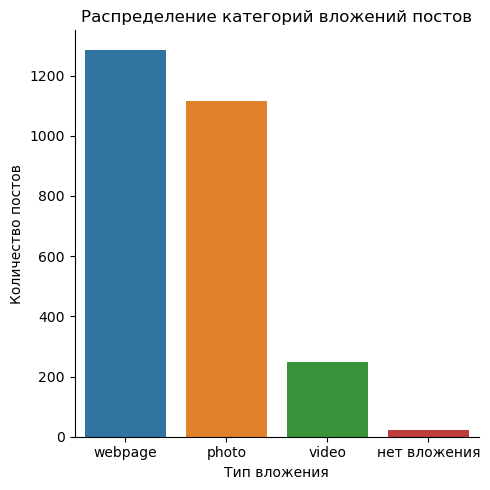

In [145]:
plt.figure(figsize=(12, 9))
sns.catplot(x = 'type_attachment', 
            kind = 'count', 
            data = merged_df)

plt.title('Распределение категорий вложений постов')
plt.ylabel('Количество постов')
plt.xlabel('Тип вложения')

plt.tight_layout()
plt.show()

Анализ категорий вложений постов показал, что:
- большая часть постов за все время анализа содержат ссылки, либо фотографии
- постов с видео-контентом довольно мало, около 250

Посмотрим на статистическую значимость в категориях вложений:

In [146]:
attach_a_data = merged_df[merged_df['type_attachment'] == 'webpage'] # в основном статьи Кинопоиска
attach_b_data = merged_df[merged_df['type_attachment'] == 'photo']
attach_c_data = merged_df[merged_df['type_attachment'] == 'video']
attach_d_data = merged_df[merged_df['type_attachment'] == 'нет вложения']


# применим тест Краскела-Уоллиса для каждого параметра
for param in ['views', 'forwarded', 'reactions_count', 'comments']:
    h_statistic, p_value = kruskal(attach_a_data[param], attach_b_data[param],
                                    attach_c_data[param], attach_d_data[param])
    print(f"Тест Краскела-Уоллиса для параметра '{param}':")
    print("H-статистика:", h_statistic)
    print("p-значение:", p_value)
    print()

Тест Краскела-Уоллиса для параметра 'views':
H-статистика: 8.186995253374088
p-значение: 0.042301100349211036

Тест Краскела-Уоллиса для параметра 'forwarded':
H-статистика: 240.7139429120393
p-значение: 6.669836773975874e-52

Тест Краскела-Уоллиса для параметра 'reactions_count':
H-статистика: 719.937204984666
p-значение: 9.972674333770325e-156

Тест Краскела-Уоллиса для параметра 'comments':
H-статистика: 208.1018996391803
p-значение: 7.488534483419044e-45



Статистически значимые различия обнаружены между всеми группами с типами вложений.

In [147]:
# соберем все данные в один массив
all_data = pd.concat([attach_a_data, attach_b_data, attach_c_data, attach_d_data])

# добавим столбец с группами
all_data['group'] = ['A'] * len(attach_a_data) + ['B'] * len(attach_b_data) + ['C'] * len(attach_c_data) + ['D'] * len(attach_d_data)

# выполним множественные сравнения с помощью метода Тьюки для количества реакций
tukey_results = pairwise_tukeyhsd(all_data['reactions_count'], all_data['group'])

print(tukey_results)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     A      B 435.2788    0.0   380.454 490.1036   True
     A      C 344.9422    0.0  252.1574 437.7271   True
     A      D 356.1095 0.0065   74.1878 638.0312   True
     B      C -90.3366 0.0645 -184.2608   3.5876  False
     B      D -79.1693 0.8888  -361.468 203.1294  False
     C      D  11.1673 0.9997 -280.8872 303.2218  False
-------------------------------------------------------


Статистически значимые различия обнаружены между группой A ('webpages') и остальными группами.

In [148]:
# посмотрим на среднее кол-во реакций для каждого из вложений
merged_df.groupby('type_attachment', as_index=False) \
         .agg({'reactions_count':'mean'}) \
         .sort_values('reactions_count', ascending=False)

,type_attachment,reactions_count
0,photo,757.256272
3,нет вложения,678.086957
1,video,666.919679
2,webpage,321.977449


Получается, что статистически значимо только различие в количестве реакций у постов со ссылками и у постов с фото/видео.

In [149]:
# для количества комментариев
tukey_results = pairwise_tukeyhsd(all_data['comments'], all_data['group'])

print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     A      B  30.6301    0.0  23.6207  37.6395   True
     A      C   3.9994 0.8221  -7.8632   15.862  False
     A      D  40.7487 0.0193   4.7047  76.7926   True
     B      C -26.6307    0.0  -38.639 -14.6224   True
     B      D  10.1186 0.8889 -25.9736  46.2107  False
     C      D  36.7493 0.0556  -0.5902  74.0887  False
------------------------------------------------------


- Статистически значимые различия обнаружены между группой A (вебстраницы) и B (фото)
- Статистически значимые различия обнаружены между группой A (вебстраницы) и D (нет вложения)
- Статистически значимые различия обнаружены между группой B (фото) и С (видео)

In [150]:
merged_df.groupby('type_attachment', as_index=False) \
         .agg({'comments':'mean'}) \
         .sort_values('comments', ascending=False)

,type_attachment,comments
3,нет вложения,69.608696
0,photo,59.490143
1,video,32.859438
2,webpage,28.860031


Анализ вложений постов показал, что:  
- Посты с фотографиями комментируют больше, чем посты с ссылками  
- Посты с фотографиями комментируют чаще, чем посты с видео  
- Среднее значение комментариев к постам с вложением фото в два раза больше, чем у постов с ссылками и видео, и данное различие статистически значимо.

### Хештеги (чтобы посмотреть, видео в рубриках или нет)

In [151]:
# отфильтруем посты c хэштегами
with_hashtags = merged_df[merged_df['hashtags'].notnull()]

# выведем информацию о типе контента для постов без хэштегов
print(with_hashtags['type_attachment'].value_counts())

video      122
photo       75
webpage     62
Name: type_attachment, dtype: int64


Больше всего видео у постов с хэштегами, возможно что это специальные рубрики (проекты) кинопоиска

## Количество эмоджи в тексте поста

In [152]:
# напишем функцию для подсчета эмоджи
def count_emojis(text):
    emojis = [c for c in text if c in emoji.EMOJI_DATA]
    return len(emojis)

# применим функцию count_emojis к каждой ячейке столбца 'text' и сохраним результат в новый столбец 'emoji_count'
merged_df['emoji_count'] = merged_df['text'].apply(count_emojis)

In [153]:
# посмотрим на описательную статистику кол-ва эмоджи
merged_df['emoji_count'].describe()

count    2674.000000
mean        0.954375
std         1.269580
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        17.000000
Name: emoji_count, dtype: float64

In [154]:
# выведем кол-во постов без эмоджи
print(f'Количество постов без эмоджи в тексте:', len(merged_df.query('emoji_count == 0')))
print(f'Доля постов без эмоджи в тексте от общего числа: {len(merged_df.query("emoji_count == 0")) / len(merged_df) * 100:.2f}%')

Количество постов без эмоджи в тексте: 1154
Доля постов без эмоджи в тексте от общего числа: 43.16%


- Медианное количество эмоджи в текстах постов: 1  
- Почти половина постов не имеет никаких эмоджи в тексте 
- Очень редко встречается более 3 эмоджи в тексте  

Посмотрим, есть ли связь между количеством эмоджи в тексте постов и кол-вом просмотров, комментариев:

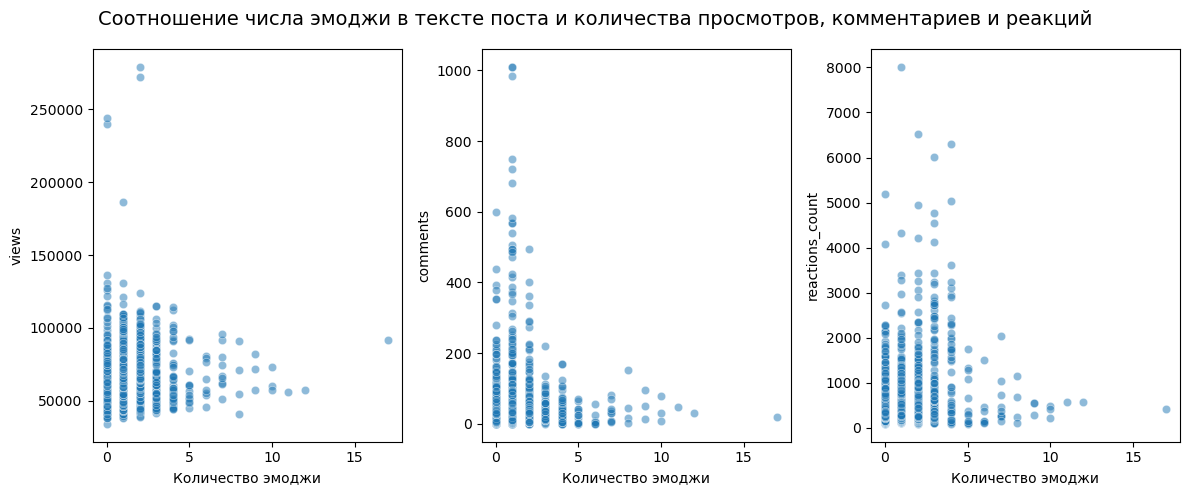

In [155]:
# создаем фигуру и оси для графиков
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

# создаем графики рассеяния для каждой из метрик (просмотры, комментарии, реакции)
for i, metric in enumerate(['views', 'comments', 'reactions_count']):
    sns.scatterplot(x='emoji_count', y=metric, data=merged_df, ax=axes[i], alpha=0.5)
    axes[i].set_xlabel('Количество эмоджи')  # задаем название оси X
    axes[i].set_ylabel(metric)  # задаем название осям Y
    
# задаем общий заголовок
fig.suptitle('Соотношение числа эмоджи в тексте поста и количества просмотров, комментариев и реакций', fontsize=14)

# отобразим графики
plt.tight_layout()
plt.show()

На графиках выявлена отрицательная связь: чем **больше просмотров, комментариев, реакций**, тем **меньше** используется эмоджи в тексте постов

In [156]:
# проверим, какую долю занимают посты c единственным эмоджи в фразе 'Подписывайтесь на Кинопоиск' от всех постов с эмоджи
result = merged_df[(merged_df['text'].str.contains('🔥 ')) & (merged_df['emoji_count'] ==1)]
print(f"Процент постов c единственным эмоджи 🔥 в фразе 'Подписывайтесь на Кинопоиск...' от всех постов с эмоджии:\
    {round(len(result) / len(merged_df.loc[merged_df['emoji_count'] >=1]) * 100)} %")

Процент постов c единственным эмоджи 🔥 в фразе 'Подписывайтесь на Кинопоиск...' от всех постов с эмоджии:    19 %


In [157]:
# проверим, какую долю занимают посты c единственным эмоджи в фразе 'Подписывайтесь на Кинопоиск' от постов с одним эмоджи
result = merged_df[(merged_df['text'].str.contains('🔥 Подписывайтесь ')) & (merged_df['emoji_count'] ==1)]
print(f"Процент постов c единственным эмоджи 🔥 в фразе 'Подписывайтесь на Кинопоиск...' от постов с одним эмоджи:\
    {round(len(result) / len(merged_df.loc[merged_df['emoji_count'] == 1]) * 100)} %")

Процент постов c единственным эмоджи 🔥 в фразе 'Подписывайтесь на Кинопоиск...' от постов с одним эмоджи:    29 %


**Выводы**

- Медианное количество эмоджи в тексте - 1  
- Большинство постов не содержат эмоджи  
- Выявлена отрицательная взаимосвязь количества эмоджи в постах и количества просмотров, комментариев и реакций
- 19% постов от постов с одним и более эмоджи содержат один 🔥  
- Треть постов с одним эмоджи - это посты с фразой '🔥 Подписывайтесь на Кинопоиск...'  
- Можно сделать предположение, что у Кинопоиска есть желание не переборщить с эмоджи   

## Добавим переменную с длинной поста

In [158]:
# напишем функцию для расчета длины поста
def text_length(text):
    return len(text)

# применим функцию и сохраним значения в отдельную колонку text_length
merged_df['text_length'] = merged_df['text'].apply(text_length) 

In [159]:
# посмотрим на описательную статистику длины поста
merged_df['text_length'].describe()

count    2674.000000
mean      386.689978
std       301.752036
min         3.000000
25%       214.000000
50%       333.000000
75%       469.000000
max      3184.000000
Name: text_length, dtype: float64

- Средняя длина текста поста составляет ≈ 386 символов 
- Медианная длина текста поста составляет 333 символа
- Минимальная длина текста составляет 3 символа, а максимальная - 3184 символа.   
Данные распределены довольно широко относительно среднего значения - это указывает на то, что присутствуют как очень короткие посты, так и очень длинные.  

Посмотрим, есть ли связь между длиной постов и кол-вом просмотров, комментариев и реакций:

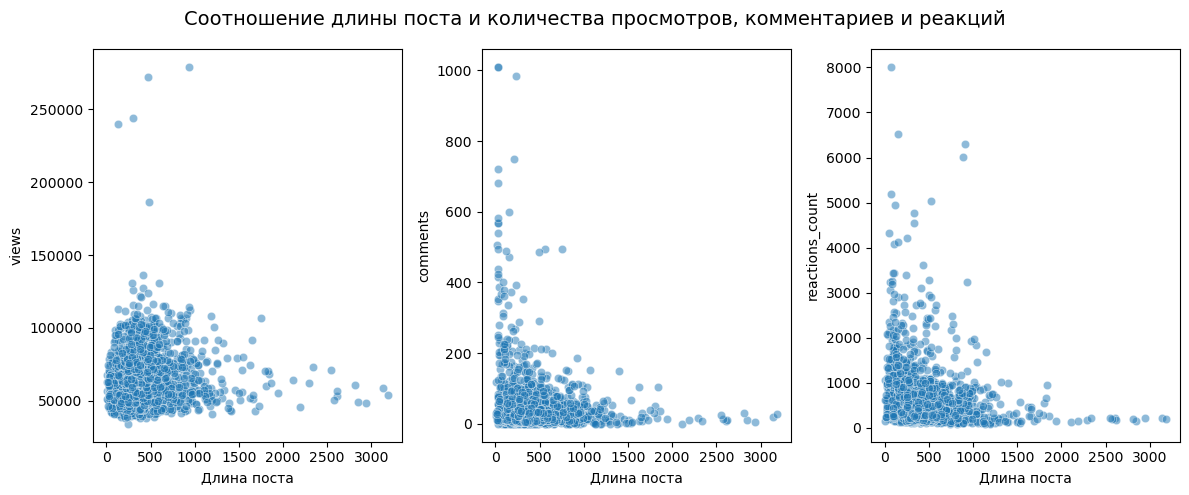

In [160]:
# создаем фигуру и оси для графиков
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

# создаем графики рассеяния для каждой из метрик (просмотры, комментарии, реакции)
for i, metric in enumerate(['views', 'comments', 'reactions_count']):
    sns.scatterplot(x='text_length', y=metric, data=merged_df, ax=axes[i], alpha=0.5)
    axes[i].set_xlabel('Длина поста')  # задаем название оси X
    axes[i].set_ylabel(metric)  # задаем название осям Y
    
# задаем общий заголовок
fig.suptitle('Соотношение длины поста и количества просмотров, комментариев и реакций', fontsize=14)

# отобразим графики
plt.tight_layout()
plt.show()

- На 2 и 3 графиках снова выявлена отрицательная связь: чем **больше комментариев и реакций**, тем **короче** тексты постов  

- Количество просмотров равномерно распределено у постов до 1000 символов, на более длинных постах наблюдается сильный спад

In [161]:
# дополнительно посмотрим, в каких постах есть хэштеги и есть ли связь между наличием хэштега и длиной поста
merged_df['has_hashtag'] = merged_df['hashtags'].notna()

In [162]:
table_hash = pd.pivot_table(merged_df,
                            index='has_hashtag',
                            values=['text_length', 'views', 'forwarded', 'reactions_count', 'comments'],
                            aggfunc='median').reset_index()
table_hash

,has_hashtag,comments,forwarded,reactions_count,text_length,views
0,False,27,142.0,363,341,58839.0
1,True,20,202.0,425,266,61810.0


- Посты с хэштегами короче, чем посты без хэштегов  
- Просматривают посты с хэштегами немного больше, чем посты без них  
- Пересылают посты с хэштегами чаше, а комментируют немного реже  

**Выводы**  

- Средняя длина текста поста составляет ≈ 386 символов 
- Медианная длина текста поста составляет 333 символа
- Минимальная длина текста составляет 3 символа, а максимальная - 3184 символа  
- Короткие посты набирают больше комментариев и реакций, чем длинные   
- Количество просмотров слабо коррелирует с длиной постов: просмотры постов до 1000 символов (что покрывает более 75% постов) распределены равномерно  
- У постов более 1000 символов наблюдается сильный спад по количеству просмотров. 

## Знаки препинания (сложность текста)

In [163]:
# напишем функцию для удаления ссылок
def remove_links(text):
    return re.sub(r'https?://\S+', '', str(text))

In [164]:
# напишем функцию для выявления и посчета кол-ва знаков пунктуации в текстах постов
def count_punctuation(sentence):
  sentence = remove_links(sentence) # применим функцию для удаления сссылок
  punctuation_count = 0
  found_punctuation = []

  for char in sentence:
    if char in string.punctuation:
      punctuation_count += 1
      found_punctuation.append(char)

  return pd.Series({'punctuation_count': punctuation_count, 'found_punctuation': found_punctuation})

In [165]:
# применим функцию и посчитаем кол-во знаков пунктуации
merged_df[['punctuation_count', 'found_punctuation']] = merged_df['text'].apply(count_punctuation)

In [166]:
# посмотрим на кол-во знаков в посте с самыми высокими просмотрами
merged_df[['text', 'views', 'punctuation_count']].sort_values('views', ascending=False)

,text,views,punctuation_count
2154,💯 100. Великих. Фильмов. XXI века\n\nПредставл...,278962.0,46
2266,Не выходи из комнаты и ешь сыр 🧀\n\nТаким реце...,272087.0,17
350,Прямо сейчас общаемся в прямом эфире с Владисл...,244143.0,8
348,"«Вавилон» — кино о кино, поэтому в нем много о...",239884.0,4
2407,Журналист «Загадки дыры» пишет книгу о прошлом...,186321.0,20
...,...,...,...
552,До #Оскар2023 осталось три дня.\n\nПродолжаем ...,39046.0,4
2007,"Постер «Мальчика и птицы» Хаяо Миядзаки, опубл...",38258.0,17
1995,"⚡️Принцесса Диана, принц Чарльз, Елизавета II ...",38228.0,12
554,"Яндекс выпустил большое исследование, посвящен...",38139.0,10


In [167]:
# посмотрим на описательную статистику кол-ва знаков пунктуации
merged_df.punctuation_count.describe()

count    2674.000000
mean       15.451384
std        13.746192
min         0.000000
25%         7.000000
50%        12.000000
75%        19.000000
max       143.000000
Name: punctuation_count, dtype: float64

- В постах в среднем содержится около 15 знаков пунктуации  
- Медианное кол-во знаков пунктуации в постах - 12  
- Минимальное кол-во знаков пунктуации - 0, максимальное 143 символа 

Посмотрим, есть ли связь между количеством знаков пунктуации и кол-вом просмотров, комментариев и реакций:

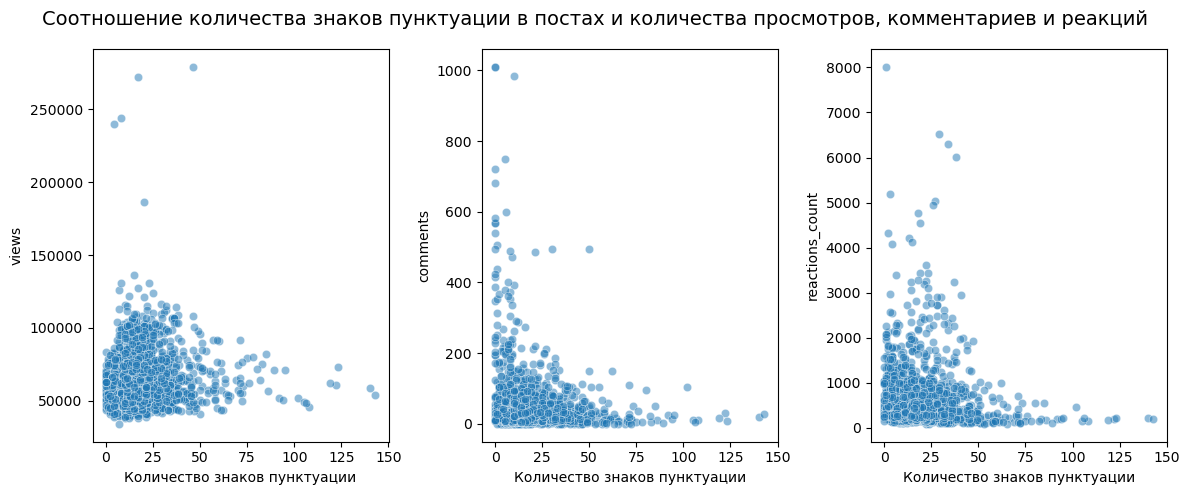

In [168]:
# создаем фигуру и оси для графиков
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

# создаем графики рассеяния для каждой из метрик (просмотры, комментарии, реакции)
for i, metric in enumerate(['views', 'comments', 'reactions_count']):
    sns.scatterplot(x='punctuation_count', y=metric, data=merged_df, ax=axes[i], alpha=0.5)
    axes[i].set_xlabel('Количество знаков пунктуации')  # задаем название оси X
    axes[i].set_ylabel(metric)  # задаем название осям Y
    
# задаем общий заголовок
fig.suptitle('Соотношение количества знаков пунктуации в постах и количества просмотров, комментариев и реакций', fontsize=14)

# отобразим графики
plt.tight_layout()
plt.show()

- На 2 и 3 графиках выявлена отрицательная связь: чем **больше комментариев и реакций**, тем **меньше** знаков пунктуации в текстах постов  
- Количество знаков пунктуации слабо коррелирует с кол-вом просмотров 

**Выводы**   
- В постах в среднем содержится около 15 знаков пунктуации
- Медианное кол-во знаков пунктуации в постах - 12
- Минимальное кол-во знаков пунктуации - 0, максимальное 143 символа
- Чем больше комментариев и реакций, тем меньше знаков пунктуации в текстах постов  
- Количество знаков пунктуации слабо коррелирует с кол-вом просмотров 

## График подписок и отписок по дням

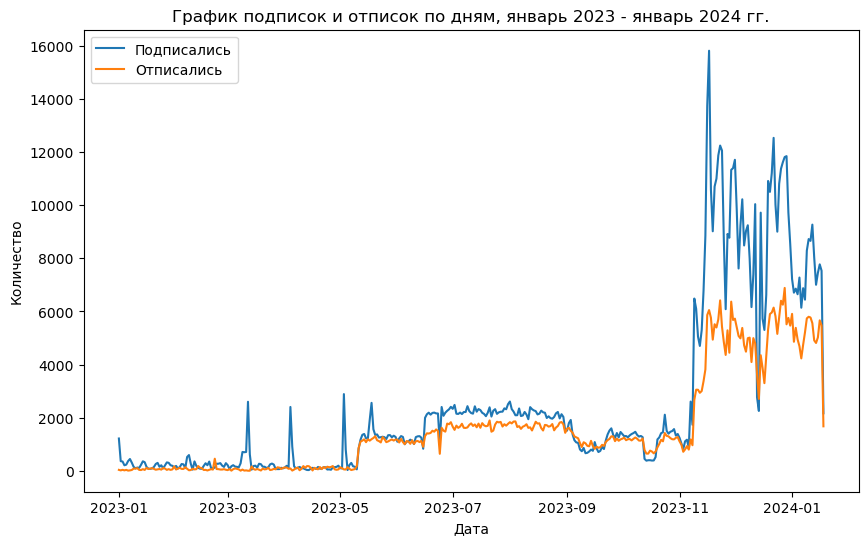

In [169]:
# визуализируем кол-во подписавшихся и отписавшихся по дням
subscribe_data = subscribers.groupby('date')['subscribers'].sum()
unsubscribe_data = subscribers.groupby('date')['unsubscribed'].sum()

# создаем общий график
plt.figure(figsize=(10, 6))

# подписки
sns.lineplot(data=subscribe_data, label='Подписались')

# отписки
sns.lineplot(data=unsubscribe_data, label='Отписались')

# настройки графика
plt.title('График подписок и отписок по дням, январь 2023 - январь 2024 гг.')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()

# отобразим график
plt.show()

**Выводы**

- Наблюдается симметрия в графике с июля 2023 года  
- Есть отдельные небольшие всплески подписок в 2023 году - 1 января (1214), 12 марта (2598), 4 апреля (2402), 3 мая (2887) и 18 мая(2557)   
- Большой всплеск подписок в ноябре 2023 (запуск чат-бота): в канал приходило больше людей, чем отписывалось, хотя и есть симметрия   
- Спад количества подписок и отпискок в январе 2024 г.

## График подписок и отписок по часам

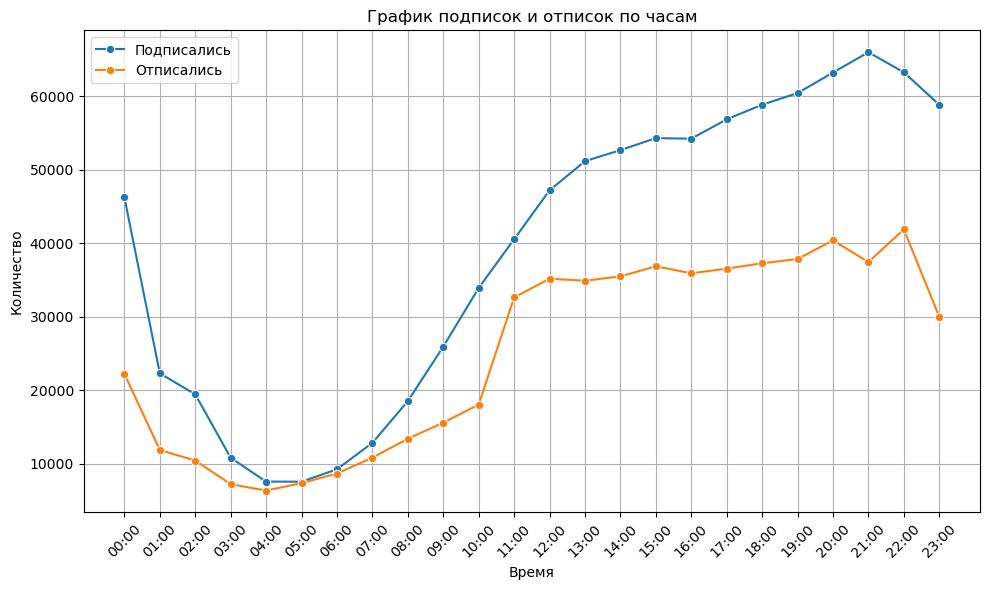

In [170]:
# визуализируем кол-во подписавшихся и отписавшихся по часам
subscribe_data = subscribers.groupby('time')['subscribers'].sum()
unsubscribe_data = subscribers.groupby('time')['unsubscribed'].sum()

# создаем новый DataFrame для удобства
data = pd.DataFrame({'Время': subscribe_data.index, 
                     'Подписались': subscribe_data.values,
                     'Отписались': unsubscribe_data.values})

# строим график
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Время', y='Подписались', label='Подписались', marker='o')
sns.lineplot(data=data, x='Время', y='Отписались', label='Отписались', marker='o')

# настройки графика
plt.title('График подписок и отписок по часам')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.xticks(rotation=45)  # Поворот подписей оси x на 45 градусов
plt.grid(True)
plt.legend()

# отобразим график
plt.tight_layout()  # Улучшает расположение элементов на графике
plt.show()

**Выводы**

- Наблюдается симметрия в данных, подписываются и отписываются люди активно с 10:00 до 21:00  
- После 21:00 наблюдается небольшой спад в количестве подписок  
- В 22:00 наблюдается небольшой рост в количестве отписок и большой спад в 23:00

## Коэффициент роста аудитории

In [171]:
# сгруппируем данные о постах по дате
metrics_df = merged_df.groupby('date', as_index=False)['views', 
                                                       'reactions_count',
                                                       'forwarded', 
                                                       'comments'].agg('sum')

In [172]:
# добавим к данным информацию о подписчитах + кол-во подписавшихся и отписавшихся
metrics_df = (metrics_df
              .merge(subscribers_group, 
                     on='date', 
                     how='left')
              .merge(subscribers_g, 
                     on='date',  
                     how='left')
              .rename(columns={'subscribers_x': 'new_subscribers', 
                               'subscribers_y': 'total_subscribers'}))

In [173]:
# рассчитаем коэффициент роста аудитории
metrics_df['grow_rate'] = metrics_df['new_subscribers'] / metrics_df['total_subscribers'] * 100

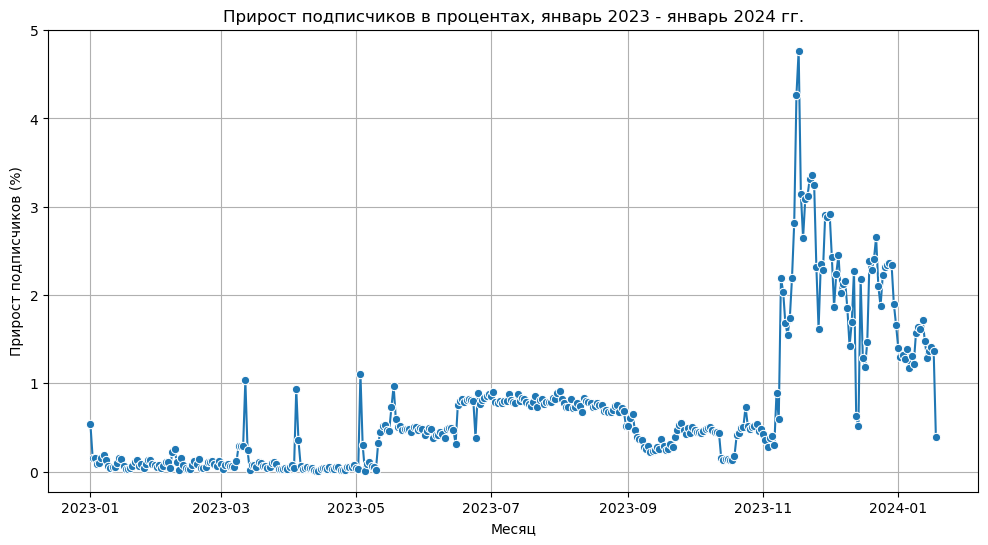

In [174]:
# визуализируем коэффициент роста аудитории
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_df, x='date', y='grow_rate', marker='o')

# настроим график
plt.title('Прирост подписчиков в процентах, январь 2023 - январь 2024 гг.')
plt.xlabel('Месяц')
plt.ylabel('Прирост подписчиков (%)')

# отобразим график
plt.grid(True)
plt.show()

**Выводы**

- График показывает, что аудитории была примерно на одном уровне с января по ноябрь 2023 года (коэффициент роста практически не превышал 1%), а в ноябре аудитория резко начала расти и коэффициент роста достиг почти 5%
- После ноябрьского пика рост замедлился и к середине января 2024 вернулся к коэффициенту роста в начале 2023 года (примерно 0.5%)

## Расчёт ежедневого оттока подписчиков

In [175]:
# сохраним в отдельный столбец кол-во подписчиков за предыдущий день
metrics_df['previous_day_subscribers'] = metrics_df['total_subscribers'].shift(1)

# заполним пропущенные значения в первой строке текущим кол-вом подписчиков
metrics_df.loc[0, 'previous_day_subscribers'] = metrics_df.loc[0, 'total_subscribers']

# рассчитаем коэффициент ежедневного оттока подписчиков
metrics_df['daily_churn_rate'] = (metrics_df['previous_day_subscribers'] 
                                  + metrics_df['new_subscribers'] 
                                  - metrics_df['total_subscribers']) / metrics_df['previous_day_subscribers']

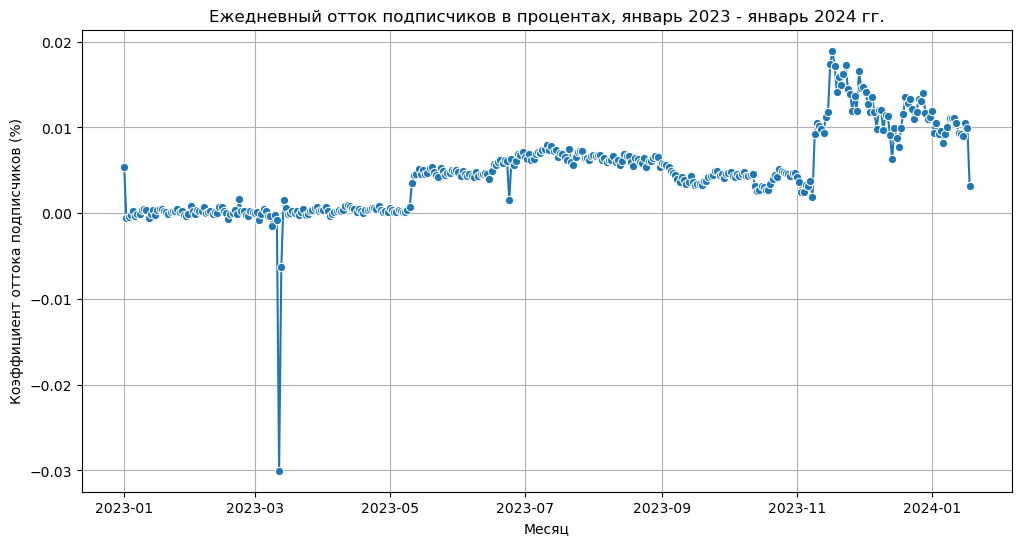

In [176]:
# визуализируем показатель
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_df, x='date', y='daily_churn_rate', marker='o')

# настроим график
plt.title('Ежедневный отток подписчиков в процентах, январь 2023 - январь 2024 гг.')
plt.xlabel('Месяц')
plt.ylabel('Коэффициент оттока подписчиков (%)')

# отобразим график
plt.grid(True)
plt.show()

**Выводы**

- Наблюдается отрицательный пик в марте, когда был пик подписок (12 марта). Пришедшие в тот период подписчики не ушли. Вероятно, это связано с премией Оскар 2023 и связанным с ней контентом.   
- Пик описок пришелся на ноябрь. Быстрый рост подписокв марте, за которым последовал быстрый рост отписок  
- Стабилизация отписок к середине января (околонулевой коэффициент)

## Engagement Rate (ER)

**Engagement Rate (ER)** измеряет уровень вовлеченности аудитории с контентом или медиа-каналом. Это отношение числа взаимодействий (например, реакций, комментариев, репостов) к общему числу просмотров, подписчиков или другой метрике, представляющей аудиторию.

Engagement является показателем эффективности контента или канала, а более высокие значения могут указывать на более активную и заинтересованную аудиторию.

Рассчитаем Engagement Rate к сумме реакций, комментариев, репостов к количеству подписчиков:

In [177]:
# 2023 - 2024 гг
metrics_df['daily_er'] = (metrics_df['comments'] 
                          + metrics_df['reactions_count'] 
                          + metrics_df['forwarded']) / metrics_df['total_subscribers'] * 100

In [178]:
# 2022 год
er_2022 = merged_2022.groupby('date', as_index=False) \
                     .agg({'comments':'sum', 
                           'reactions_count': 'sum',
                           'forwarded':'sum', 
                           'subscribers': 'first'})

In [179]:
er_2022['daily_er'] = (er_2022['comments'] + 
                       er_2022['reactions_count'] + 
                       er_2022['forwarded']) / er_2022['subscribers'] * 100

In [180]:
print(f"Медиана ER в 2022 году: {round(er_2022['daily_er'].median(), 2)} %")
print(f"Среднее ER в 2022 году: {round(er_2022['daily_er'].mean(), 2)} %")

Медиана ER в 2022 году: 2.76 %
Среднее ER в 2022 году: 3.03 %


In [181]:
print(f"Медиана ER в 2023-2024: {round(metrics_df['daily_er'].median(), 2)} %")
print(f"Среднее ER в 2023-2024: {round(metrics_df['daily_er'].mean(), 2)} %")

Медиана ER в 2023-2024: 1.72 %
Среднее ER в 2023-2024: 1.91 %


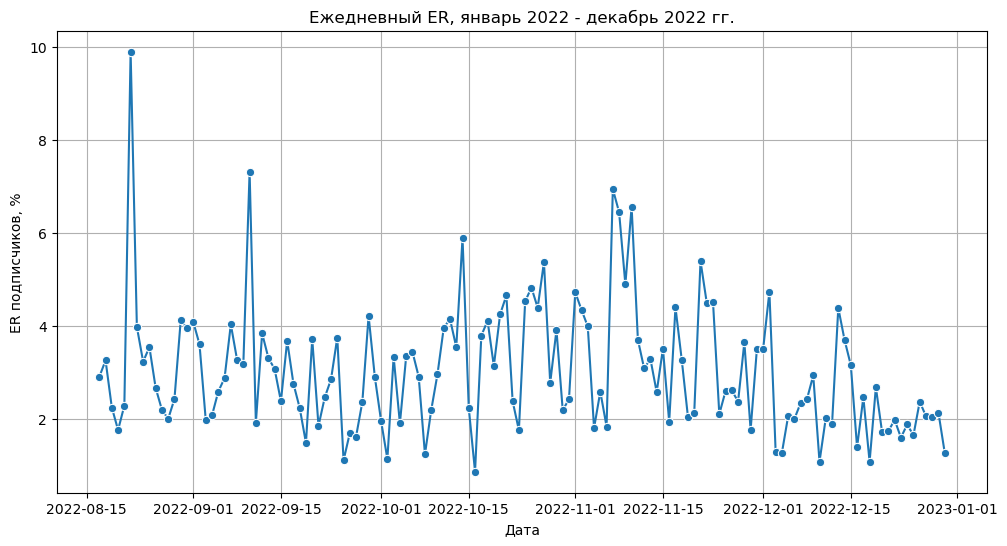

In [182]:
# визуализируем показатель за 2022 год
plt.figure(figsize=(12, 6))
sns.lineplot(data=er_2022, x='date', y='daily_er', marker='o')

# настроим график
plt.title('Ежедневный ER, январь 2022 - декабрь 2022 гг.')
plt.xlabel('Дата')
plt.ylabel('ER подписчиков, %')

# отобразим график
plt.grid(True)
plt.show()

**2022:** 
- ER распределен равномерно, значения колеблятся от 0 до 10% на пике вовлеченности (22 августа, 9.89%)  
- Наблюдаются всплески в начале сентября (10.09, 7.3%) в середине октября (14.10, 5.9%) и с 7 по 10 ноября (6.5 - 7%)  
- С ноября ER пошел на спад и к концу 2022 года составил всего 1.2% 

Если смотреть на медианное и среднее значения показателя, ER можно охарактеризовать как низкий (2.76% и 3.03 % соответственно)

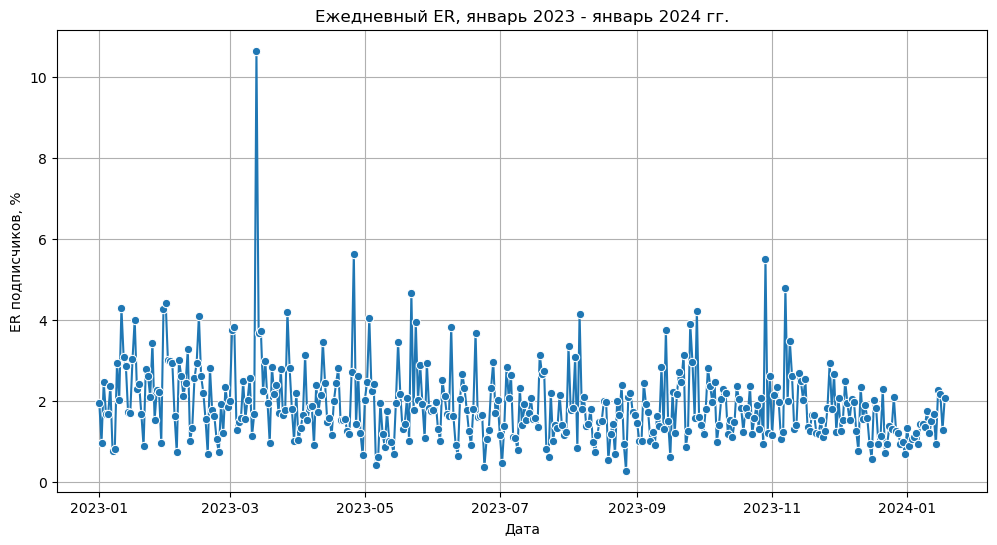

In [183]:
# визуализируем показатель за 2023 + начало 2024 года
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_df, x='date', y='daily_er', marker='o')

# настроим график
plt.title('Ежедневный ER, январь 2023 - январь 2024 гг.')
plt.xlabel('Дата')
plt.ylabel('ER подписчиков, %')

# отобразим график
plt.grid(True)
plt.show() 

**2023 и начало 2024 гг.:**

- ER распределен равномерно, кроме всплеска в марте, когда ER был выше 10%
- Также наблюдаются небольшие всплески в конце апреля, конце октября и начале ноября (5-6%)
- С ноября ER пошел на спад и к концу года значения колебались около 1%  
- Если смотреть на медианное и среднее значения показателя, ER можно охарактеризовать как низкий (1.72 и 1.91 % соответственно)  


В ежегодной динамике уровень вовлеченности подписчиков **ухудшился:** медианные значения 2023 года ниже ≈ на 1% (ER cнизился с 2.76 % до 1.72%)

## Дневная вовлеченность подписчиков

In [184]:
# рассчитаем показатель дневной вовлеченности 
daily_ER = merged_df.groupby('date', as_index=False) \
                    .agg({'reactions_count':'sum', 
                          'total_subscribers':'first'})

In [185]:
daily_ER['ER_day'] = daily_ER['reactions_count'] / daily_ER['total_subscribers'] * 100

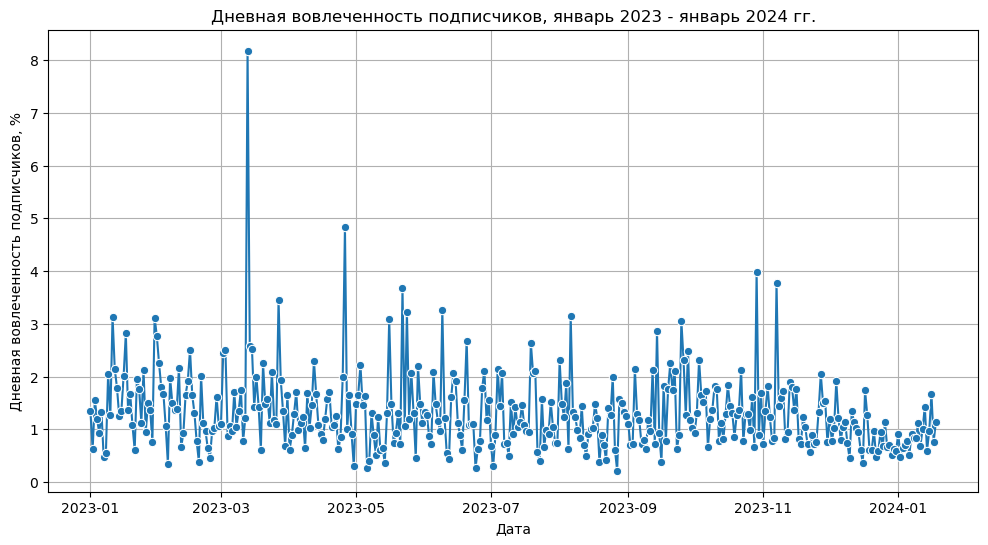

In [186]:
# визуализируем показатель 
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_ER, x='date', y='ER_day', marker='o')

# настроим график
plt.title('Дневная вовлеченность подписчиков, январь 2023 - январь 2024 гг.')
plt.xlabel('Дата')
plt.ylabel('Дневная вовлеченность подписчиков, %')

# отобразим график
plt.grid(True)
plt.show()

Наблюдаются тенденции, полностью аналогичные предыдущему графику.

In [187]:
# добавим значения дневной ER в объединенный датасет
daily_ER_subset = daily_ER[['date', 'ER_day']]
metrics_df = metrics_df.merge(daily_ER_subset, on='date', how='left')

In [188]:
metrics_df.head()

,date,views,reactions_count,forwarded,comments,new_subscribers,unsubscribed,total_subscribers,changes,grow_rate,previous_day_subscribers,daily_churn_rate,daily_er,ER_day
0,2023-01-01,373191.0,3052,1046.0,339,1214,32,226447,1337,0.536108,226447.0,0.005361,1.959399,1.347777
1,2023-01-02,238682.0,1400,675.0,124,359,13,226928,481,0.158200,226447.0,-0.000539,0.969030,0.616936
2,2023-01-03,509082.0,3541,1865.0,213,347,34,227365,437,0.152618,226928.0,-0.000397,2.471357,1.557408
3,2023-01-04,393612.0,2705,1038.0,109,205,14,227621,256,0.090062,227365.0,-0.000224,1.692287,1.188379
4,2023-01-05,492542.0,2129,1327.0,367,229,32,227805,184,0.100525,227621.0,0.000198,1.678190,0.934571


## Среднее время до оттока (MTC)

Выразим среднее время жизни подписчика в днях через показатель оттока (churn rate).   
Для этого воспользуемся обратной величиной этого показателя - **средним временем до оттока** (Mean Time to Churn - MTC) или обратным оттоком подписчиков. 

In [189]:
metrics_df['mtc'] = 1 / metrics_df['daily_churn_rate']

In [190]:
# проверим характерные значения mtc с помощью метода describe
metrics_df['mtc'].describe()

count       383.000000
mean        809.124854
std        8859.661179
min      -78216.666667
25%         107.137487
50%         196.099551
75%         396.781182
max      126757.000000
Name: mtc, dtype: float64

 - Среднее время подписчика перед оттоком: 809 дней  
 - Медианное время подписчика перед оттоком: 196 дней 
 
Наблюдаются очень низкие и очень высокие минимумы и максимумы MTC, поэтому при оценке среднего количества дней, "времени жизни" подписчика перед оттоком следует ориентироваться на медианное значение MTC - 196 дней.

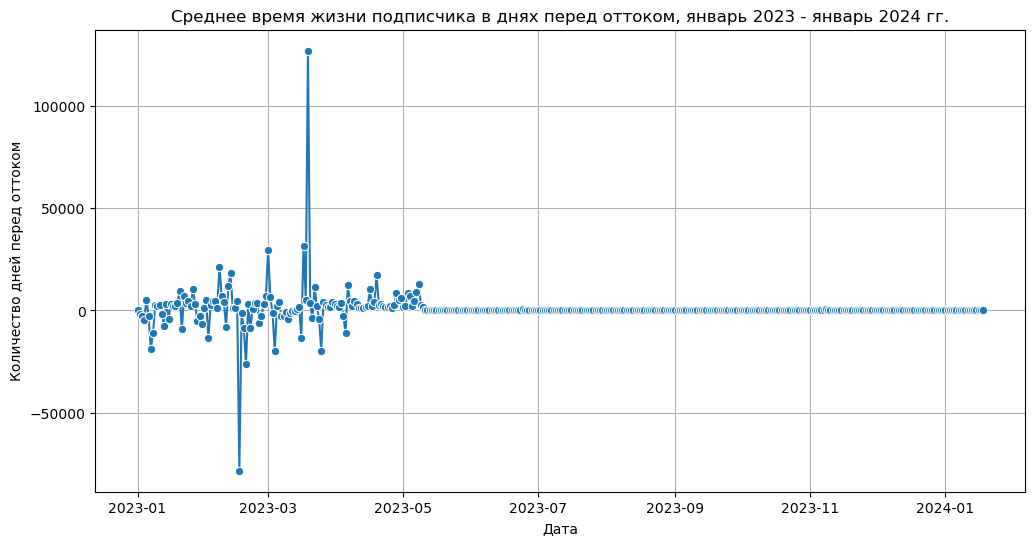

In [191]:
# визуализируем показатель MTC
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_df, x='date', y='mtc', marker='o')

# настроим график
plt.title('Среднее время жизни подписчика в днях перед оттоком, январь 2023 - январь 2024 гг.')
plt.xlabel('Дата')
plt.ylabel('Количество дней перед оттоком')

# отобразим график
plt.grid(True)
plt.show()

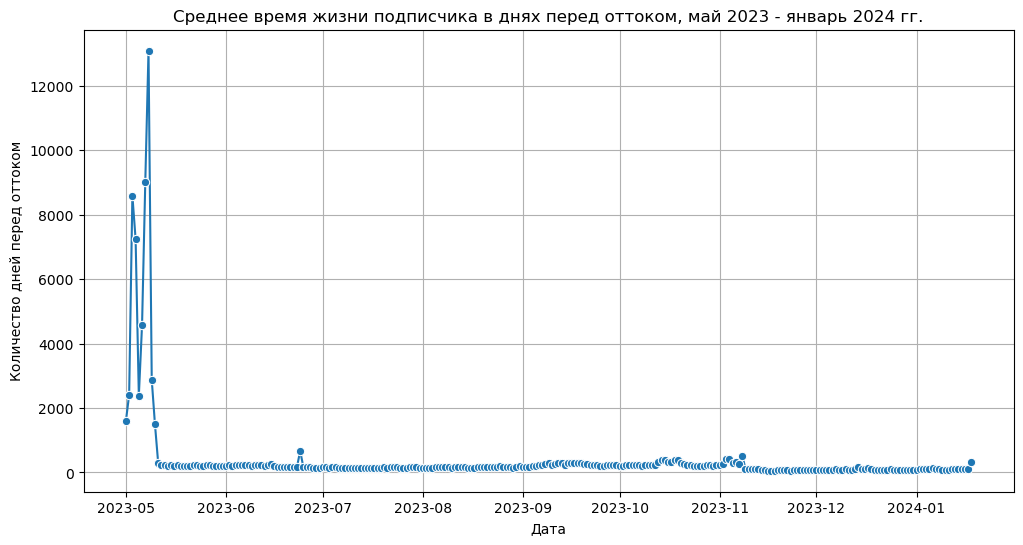

In [192]:
# рассмотрим детальнее период с мая 2023 по январь 2024
# сделаем срез данных
mtc_after_may_2023 = metrics_df.query('date >= "2023-05-01"')

# визуализируем показатель
plt.figure(figsize=(12, 6))
sns.lineplot(data=mtc_after_may_2023, x='date', y='mtc', marker='o')

# настроим график
plt.title('Среднее время жизни подписчика в днях перед оттоком, май 2023 - январь 2024 гг.')
plt.xlabel('Дата')
plt.ylabel('Количество дней перед оттоком')

# отобразим график
plt.grid(True)
plt.show()

**Выводы**

- Медиана MTC равна 196 дням, что означает, что половина подписчиков отписываются от канала в течение этого времени  
- После 10 мая наблюдается резкое снижение показателя (с 1488 до 287 дней)  
- С середины мая до конца периода MTC по большей части колеблется в диапазоне до 300 дней (максимумы: 24 июня - 668, 8 ноября - 524, 18 января - 314)  
- В ноябре наблюдается самое сильное снижение показателя: в некоторые дни MTC достигал и 50 дней
- Метрика может быть неинформативна при значениях показателя оттока близким к нулю

## Охваты постов

Рассчитаем **коэффициент охвата** (Engagement Rate by Reach) — метрику, которая показывает сколько людей из тех, что увидели пост, взаимодействовали с ним: комментировали, ставили лайки, делали репосты. Более правильно ERR переводится как коэффициент вовлечённости по охвату.  

In [193]:
merged_df['err'] = (merged_df['reactions_count'] + merged_df['forwarded'] + merged_df['comments']) / merged_df['views'] * 100

In [194]:
# проверим характерные значения ERR с помощью метода describe
merged_df['err'].describe()

count    2674.000000
mean        1.275369
std         1.029355
min         0.106085
25%         0.636699
50%         0.988379
75%         1.548678
max        11.858148
Name: err, dtype: float64

 - Средний коэффициент охвата постов: 1,2 %
 - Медианный коэффициент охвата постов: 0,98 %

In [195]:
# посмотрим на посты с охватом близким к минимальному
merged_df.query('err <= 0.11')['text'].values

array(['Прямо сейчас общаемся в прямом эфире с Владиславом Тироном и Милой Ершовой — звездами сериала «Фандорин. Азазель». \n\nОбсуждаем с ребятами съемки, последние новости о кино и многое другое. Трансляция — [здесь](https://youtube.com/live/cfu6HWkQG38?feature=share). Подключайтесь и задавайте свои вопросы!'],
      dtype=object)

In [196]:
# посмотрим на посты с охватом близким к максимальному
merged_df.query('err > 11') ['text'].values

array(['5\xa0тысяч сердечек на\xa0этом посте и\xa0мы\xa0ставим Кена-Гослинга на\xa0аватарку канала 💖',
       'Умер звезда «Друзей» Мэттью Перри. Ему было 54 года.\n\nФото: Getty Images'],
      dtype=object)

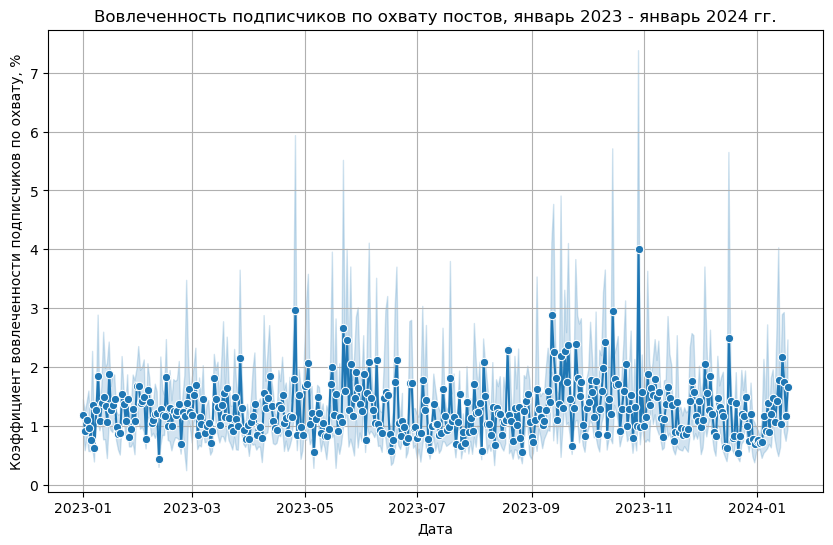

In [197]:
# визуализируем показатель ERR
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_df, x='date', y='err', marker='o')

# настроим график
plt.title('Вовлеченность подписчиков по охвату постов, январь 2023 - январь 2024 гг.')
plt.xlabel('Дата')
plt.ylabel('Коэффициент вовлеченности подписчиков по охвату, %')

# отобразим график
plt.grid(True)
plt.show()

In [198]:
# сохраним отдельно посты по коэффициенту охвата (ERR) выше медианы
top_err_posts = merged_df.loc[merged_df['err'] > merged_df['err'].median()]

In [199]:
# посмотрим, сколько всего постов с ERR выше медианы
print(f"Количество постов с ERR выше медианного значения: {top_err_posts.shape[0]}")

Количество постов с ERR выше медианного значения: 1337


### Исследуем характеристики постов с ERR выше медианы  
#### Темы постов

In [200]:
# сохраним топ-10 тем постов c ERR выше медианы
top_topic_err = top_err_posts['topic'].value_counts().head(10).index

In [201]:
# фильтруем top_err_posts, оставляя только посты с топ-10 темами
filtered_df_err = top_err_posts[top_err_posts['topic'].isin(top_topic_err)]

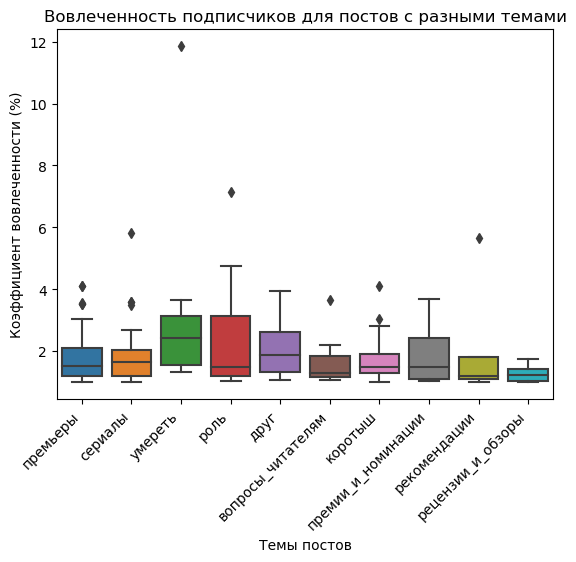

In [202]:
# визуализируем распределение постов по темам с ERR выше медианы
sns.boxplot(x='topic', 
            y='err', 
            data=filtered_df_err)

plt.xlabel('Темы постов')
plt.ylabel('Коэффициент вовлеченности (%)')
plt.title('Вовлеченность подписчиков для постов с разными темами')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

Самый высокий коэффициент вовлеченности у постов с темами **смерть, роль, друг.**  
Это говорит о том, что читатели, которые увидели пост, больше всего взаимодействуют (комментируют, ставят реакции, делают репосты) со следующим контентом:   
новости о гибели известных личностей в киноиндустрии (актеры, режиссеры, композиторы и т.д.), обсуждение кандидатов на роли в новых фильмах и интервью актеров, а также посты, направленные на взаимодействие с читателями (вопросы аудитории, интерактивы и т.д.) 

#### Категории постов

In [203]:
# сохраним топ-10 категорий постов c ERR выше медианы
top_categories_err = top_err_posts['categories'].value_counts().head(10).index

In [204]:
# фильтруем top_err_posts, оставляя только посты с топ-10 категорий
filtered_df_err = top_err_posts[top_err_posts['categories'].isin(top_categories_err)]

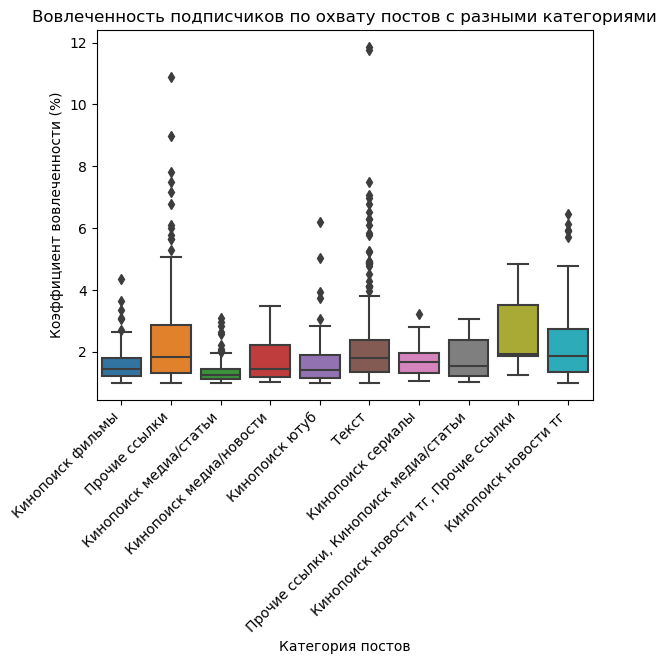

In [205]:
# исследуем категории постов с охватом выше медианного значения
sns.boxplot(x='categories', 
            y='err', 
            data=filtered_df_err)

plt.xlabel('Категория постов')
plt.ylabel('Коэффициент вовлеченности (%)')
plt.title('Вовлеченность подписчиков по охвату постов с разными категориями')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

In [206]:
filtered_df_err['categories'].value_counts()

Текст                                    445
Прочие ссылки                            201
Кинопоиск медиа/статьи                   176
Кинопоиск фильмы                         151
Кинопоиск новости тг                      98
Кинопоиск ютуб                            82
Кинопоиск сериалы                         38
Кинопоиск медиа/новости                   26
Прочие ссылки, Кинопоиск медиа/статьи     11
Кинопоиск новости тг, Прочие ссылки        9
Name: categories, dtype: int64

Самый высокий коэффициент вовлеченности у постов с категориями **Новости кинопоиска и Прочие ссылки.**   
Это говорит о том, что читатели, которые увидели пост, больше всего взаимодействуют (комментируют, ставят реакции, делают репосты) с новостными постами (премьеры фильмов и сериалов, фото/трейлеры/кадры из кино будущих новинок). Что касается категории "Прочие ссылки" - исследование ERR не информативно, так как затрагивает слишком разрозненный пласт контента.  

#### Типы вложения постов 

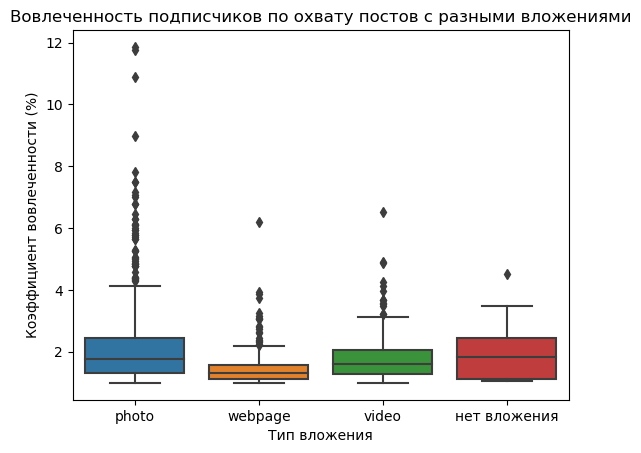

In [207]:
# исследуем типы вложения постов с охватом выше медианного значения
sns.boxplot(x='type_attachment', 
            y='err', 
            data=top_err_posts)

plt.xlabel('Тип вложения')
plt.ylabel('Коэффициент вовлеченности (%)')
plt.title('Вовлеченность подписчиков по охвату постов с разными вложениями')
plt.show()

In [208]:
# посмотрим на содержание постов без вложений
top_err_posts.query('type_attachment == "нет вложения"')['text']

454      «Оскар» за лучший фильм достается «Ла-Ла Ленду»!
1406              Кому скинуть нашу рецензию на «Барби»?)
1409                            Антон, там сторисы вышли…
1764     И все-таки «Барби» — главный фильм года или нет?
1787    Киноманы, что посмотрели в выходные? Делитесь ...
1851    Кто обожает фильмы Вуди Аллена — с вас по лайку 🤓
2049         Какой фильм вы любите пересматривать осенью?
2153                 Вы готовы? Ставьте реакцию, если да!
2155         Вы не готовы... Или готовы? Не можем понять!
2156                           У нас тут есть вопросик...
2488    На связи Максим Матвеев 🔥🔥🔥\n\n[**«Триггер. Фи...
2563                                     С годом даркона!
Name: text, dtype: object

Выше всего коэффициент вовлеченности у постов с типом вложения **Фото**, а также у постов **без вложений**.  
Это говорит о том, что читатели, которые увидели пост, больше всего взаимодействуют (комментируют, ставят реакции, делают репосты) c постами, содержащими фотографии, а также постами, направленные на взаимодействие с аудиторией (вопросы, прямой призыв поставить реакцию или поделиться мнением). 

## Частота публикаций и время публикаций

In [209]:
# посчитаем количество постов на каждую дату и запишем результат в столбец posts_freq
merged_df['posts_freq'] = merged_df.groupby(merged_df['datetime'].dt.date)['id'].transform('count')

In [210]:
# посмотрим на медианное значение кол-ва постов в день
print(f"Медианное количество постов в день: {merged_df['posts_freq'].median()}")

Медианное количество постов в день: 7.0


In [211]:
# выделим дополнительные периоды: неделя и месяц и сохраним значения в соответсвующие колонки
merged_df['month'] = merged_df['datetime'].dt.to_period('M')
merged_df['week'] = merged_df['datetime'].dt.to_period('W')

# сгруппируем данные по месяцам и подсчитаем количество постов в каждом месяце
monthly_grouped = merged_df.groupby('month').size()

# сгруппируем данные по неделям и подсчитаем количество постов в каждой неделе
weekly_grouped = merged_df.groupby('week').size()

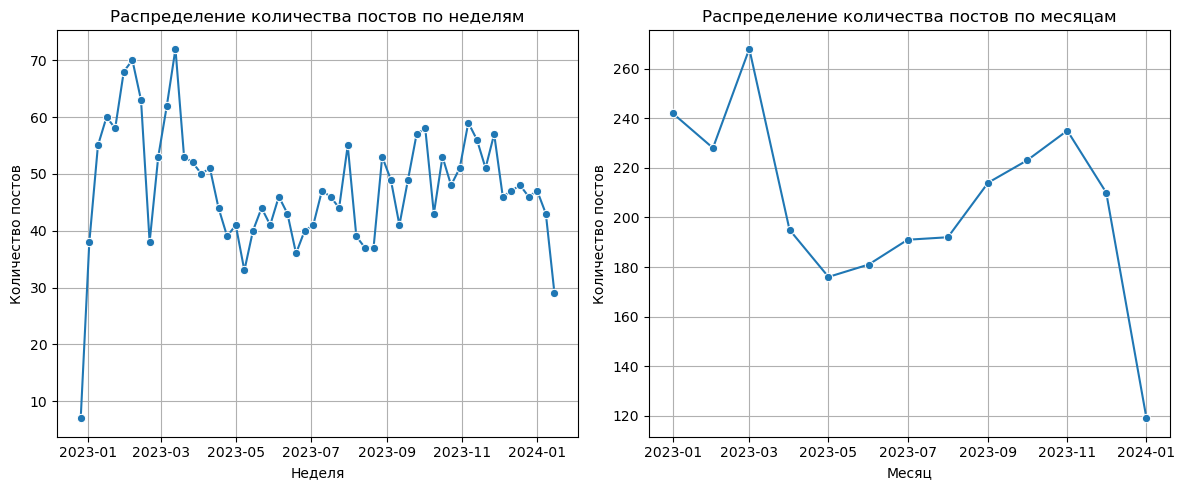

In [212]:
# визуализируем показатели
# создаем фигуру и оси для графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# создаем первый график
plt.subplot(1, 2, 1)  # Создаем первый график в строке из двух графиков
sns.lineplot(x=weekly_grouped.index.to_timestamp(), y=weekly_grouped.values, marker='o')
plt.title('Распределение количества постов по неделям')
plt.xlabel('Неделя')
plt.ylabel('Количество постов')
plt.grid(True)

# создаем второй график
plt.subplot(1, 2, 2)  # Создаем второй график в строке из двух графиков
sns.lineplot(x=monthly_grouped.index.to_timestamp(), y=monthly_grouped.values, marker='o')
plt.title('Распределение количества постов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество постов')
plt.grid(True)

# отобразим графики
plt.tight_layout()
plt.show()

**Выводы**

- В день публикуют в среднем 7 постов (медиана)  
- **Наибольшим** количеством постов выделяется **март 2023 года** (опубликовано 268 постов)  
- **Наименьшим** количеством постов выделяется **январь 2024 года** (опубликовано всего 119 постов), но нужно учитывать, что данные за этот месяц неполные + в первой половине января много праздничных и выходных дней  
- График по неделям также показывает, что март выделяется наибольшим количеством публикаций, а первые недели января 2023 и января 2024 года - наименьшим количеством публикаций  

## Исследование корреляции характеристик и метрик постов с привлечением новых пользователей в канал Кинопоиска


In [213]:
# объединим метрики с основным датафреймом  
merged_df = merged_df.merge(
    metrics_df[['date', 
                'grow_rate', 
                'daily_churn_rate', 
                'daily_er',
                'ER_day', 
                'mtc']], on="date", how='left')

<Axes: >

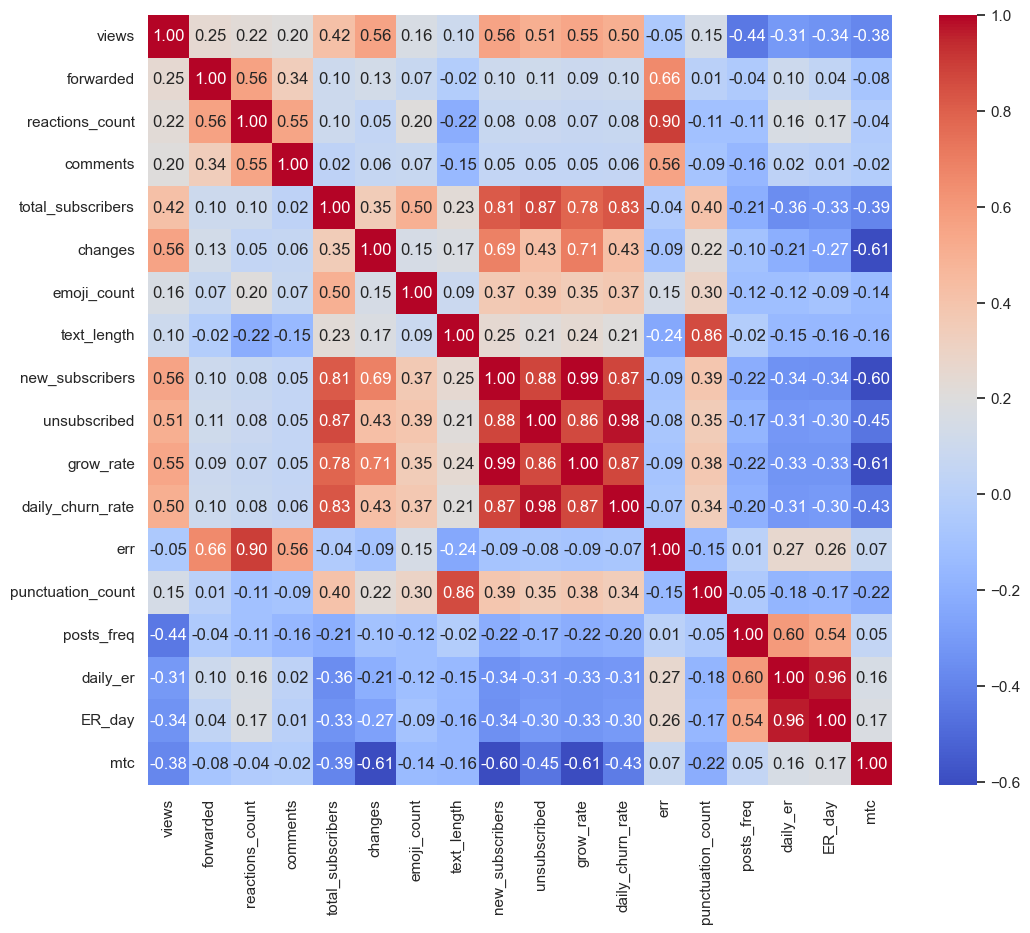

In [214]:
# построим тепловую карту для исследования корреляции
# зададим размер графика
plt.figure(figsize=(12, 10))

# установим стиль seaborn
sns.set()

# выберем только количественные переменные
numerical_df = merged_df[['views', 
                          'forwarded', 
                          'reactions_count', 
                          'comments', 
                          'total_subscribers', 
                          'changes',
                          'emoji_count', 
                          'text_length', 
                          'new_subscribers', 
                          'unsubscribed',
                          'grow_rate', 
                          'daily_churn_rate', 
                          'err', 
                          'punctuation_count', 
                          'posts_freq', 
                          'daily_er',
                          'ER_day', 
                          'mtc']]

# создадим матрицу корреляции
correlation_matrix = numerical_df.corr(method="spearman")

# построим тепловую карты
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

**Выводы**

- **Просмотры** и их связь с изменением количества подписчиков, количеством новых подписчиков, а также с уровнем роста аудитории и ежедневным оттоком: Все эти показатели имеют логическую связь с показателями просмотров. Большое количество просмотров может быть связано с ростом аудитории, новыми подписчиками и общим количеством подписчиков.

- **Репосты** и их связь с количеством реакций: **положительная корреляция** между количеством репостов и реакций вполне логична, так как интересный контент, вызывающий реакции, вероятно, будут репостить чаще    

- **Длина текста** и ее связь с количеством знаков препинания - также все логично  

- **Количество подписчиков** и его связь с количеством эмоджи в тексте: возможно, использование эмоджи делает контент более привлекательным и интересным для аудитории, что может привести к увеличению числа подписчиков (так как слабая положительная связь с новыми подписчиками и слабая отрицательная связь с отписками). Возможно, влияет содержание поста  

- ER, как и ежедневная вовлеченность подписчиков связаны в первую очередь с частотой публикаций - чем больше публикаций, тем больше показатели.

- Количество реакций и err - сильная позитивная связь, что логично, так как err рассчитывался на основании в том числе и реакций

- **Новые подписчики:** положительная корреляция c общим количеством просмотров, слабая положительная корреляция с количеством эмоджи и длиной текста. Это может говорить о том, что контент, привлекающий большое количество новых подписчиков, вероятно, также будет иметь большое количество просмотров.

## Заключение

**1. Выводы о данных:**    

Просмотры, репосты, реакции и комментарии обладают следующими характеристиками:

*1.1. Межквартильный размах(IQR - диапазон, внутри которого лежит большинство данных):*    
- просмотры ≈ от 51000 до 70000  
- репосты ≈ от 80 до 250  
- реакции ≈ от 250 до 600
- комментарии ≈ от 15 до 50

*1.2. Медианные значения:*    
- просмотры - 62534     
- репосты - 145
- реакции - 371
- комментарии - 26  

*1.3. Выбросами являются:*    
- просмотры - значения более 180000
- репосты - значения более 700
- реакции - значения более 1400
- комментарии - значения более 100  

**2. Анализ выбросов по верхней границе:**  

*2.1. Просмотры:*   
Больше всего просмотров (278962) собрал пост в честь дня рождения Кинопоиска от 7.11.2023, сопряженный с выходом спецпроекта от Кинопоиска "100 Великих Фильмов XXI века". Второе место занимает пост про Киллиана Мёрфи от 20.11.2023, вышедший накануне цифровой премьеры фильма "Оппенгеймер", ожидаемой 21 ноября 2023 г. Третье место по числу просмотров занимает пост с ссылкой на трансляцию прямого эфира со звездами сериала "Фандорин. Азазель" от 11.02.2023, недавно вышедшего на Кинопоиске. Четвертый по количеству просмотров пост от 11.02.2023 посвящен разбору фильма "Вавилон" с видеофрагментами, которые являются отсылками в другим фильмам. Пятый пост по просмотрам от 9.12.2023  - обзор четвертого сезона юмористического сериала "Внутри Лапенко" о 90-х.   

Как мы видим, большая часть постов с максимальным количеством просмотров, посвящены ожидаемым либо недавно вышедшим в прокат новинкам в мире кино. Таким образом, можно сделать вывод, что больше всего читатели просматривают посты именно с тематическим контентом, посвященным будущим или недавно вышедшим премьерам в прокате. 

*2.2. Репосты:*  
Больше всего репостов (3212) набрал пост от 3.03.2023 с трейлером к фильму "Дюна-2". На втором месте (2739 репостов) находится пост от 28.09.2023 с новостью о смерти актера Майкл Гэмбон, известного по роли Альбуса Дамблдора. Третье место по репостам занимает пост от 9.11.2023 с новостью о выходе чат-бота с киномемами (2603 репоста). Четвертый пост от 15.01.2024, набравший 2390 репоста, с тизером и новостью о выходе сериала по фильму "Джентльмены". Пятый пост по количеству репостов (2127) - пост от 2.03.2023 с долгожданным трейлером к фильму "Барби", ожидаемом в прокате 21 июля 2023 г.  

Можно сделать вывод, что больше всего репостов набирают посты с трейлерами/тизерами к ожидаемым новинкам в мире кино.  

*2.3. Реакции:*  
Больше всего реакций (8012) собрал пост от 26.04.2023 с прямым призывом к действию - поставить 5000 сердечек для того, чтобы на аватарке канала стояла фотография Кена-Гослинга. На втором месте (6529 реакций) находится пост от 22.05.2023 с призывом поставить реакцию на новость о смене актера, долгие годы озучивающего Леонардо ДиКаприо. На третьем месте (6311 реакции) находится пост от 17.12.2023 с призывом поставить разные реакции, выбрав любимую роль актера Гэри Олдмана, известному по фильмам "Гарри Поттер" и "Темный рыцарь". Четвертый пост по количеству реакций (6001) - пост от 14.01.2024 с вопросом о мнении читателей и призывом поставить реакцию на роль Тони Старка, сыгранной Робертом Дауни-младшим. Пятый пост от 29.10.2023, набравший 5190 реакций, посвящен новости о сметри актера Мэттью Перри, известному по культовому сериалу "Друзья".   

4 из 5 постов с наибольшим количеством реакций к ним направлены на взаимодействие с аудиторией канала и содержат прямой призыв к тому, чтобы читатель поставил реакцию.  

*2.3. Комментарии:*  
Больше всего (1010 комментариев) собрали посты с вопросом к читатетелям на фото и просьбой дать ответ в комментариях. Третий и четвертый по количеству (985 и 749) - посты с интерактивом-просьбой выложить постер/сцену из фильма. Пятый пост (721 комментарий) снова с вопросом на фото и просьбой дать ответ в комментариях.   

Можно сделать вывод о том, что больше всего комментируются посты, которые, как и в случае с реакциями, подразумевают взаимодействие с читалелями и содержат какой-то вопрос или интерактив.  


**3.Типы публикаций:**

*Топ-10 категорий постов:*
- Кинопоиск медиа/статьи -  802 поста                      
- Текст                  -  546 постов  
- Прочие ссылки          -  292 поста  
- Кинопоиск ютуб         -  196 постов  
- Кинопоиск фильмы       -  179 постов  
- Кинопоиск новости тг   -  142 поста  
- Кинопоиск медиа/новости - 87 постов 
- Кинопоиск сериалы       - 72 поста  
- Подкаст                 - 45 постов  
- Кинопоиск медиа/статьи, Кинопоиск фильмы - 30 постов  

*3.1. Распределение количества просмотров по типам публикаций:*      
Количество **просмотров у разных категорий постов почти не отличается**, медианные значения находятся у всех категорий примерно на одном уровне. Это может быть связано с тем, что просмотры могут быть не самой информативной характеристикой поста.


*3.2. Распределение количества реакций по типам публикаций:*    
Наиболее **низкими** медианами по количеству реакций выделяются категории:
- **Кинопоиск медиа/статьи** (ссылки статьи и материалы Кинопоиска на сайте)
- **Подкасты** (ссылки на подкасты)  
- **Кинопоиск медиа/новости** (ссылки на новости на сайте Кинопоиска)
Это может быть связано с тем, что такие категории подразумевают трату времени: чтобы ознакомиться с контентом, нужно переходить, читать, слушать информацию, а реакции - это более быстрый и эмоциональный способ взаимодействия подписчиков с телеграм-каналом.

**Больше всего** реакций набирают категории:
 - **Прочие ссылки** (внешние ссылки, обычно новостные)
 - **Тексты** - как правило, общение и взаимодействие Кинопоиска с подписчиками. Например, вопросы аудитории (прим.: 'как вы думаете?' и т.п.)  

Резюмируя, больше реакций набирают посты, которые являются уникальным контентом телеграм-канала Кинопоиска, а также посты, которые нацелены на взаимодействие с подписчиками, плюс короткие новости и анонсы кино-новинок.

Данный показатель (количество реакций) является информативным и может быть использован в качестве метрики эффективности поста.

*3.3. Распределение количества комментариев по типам публикаций:*  
- Количество комментариев по категориям, также как и просмотры, является не очень информативным показателем.
- В категории **подкасты** наблюдается **меньше всего** комментариев. Это может быть связано с тем, что пост представляет собой просто анонс нового подкаста/дайджеста и ссылку на него.   

*3.4. Распределение количества репостов по типам публикаций:*  
- **Ссылки на фильмы** пересылают **чаще** других категорий  
- Посты о фильмах и сериалах часто могут и хотят порекомендовать друзьям/знакомым, поэтому показатели репостов у данной категории самые высокие  
- **Низким** медианным значением снова выделяются **подкасты**   
Причина предположительно, та же: для рекомендации подкаста нужно выделить время, чтобы сначала его прослушать/посмотреть, сформировать мнение, и только потом принять решение делиться с кем-то или нет.
- **Высоким** количестов репостов выделяются категории:   

1) *Прочие ссылки* (как правило, новости)  
2) *Текст* (новости, анонсы премьер)  
3) *Кинопоиск сериалы* (ссылки на сериалы)  
4) *Кинопоиск новости тг*(посты с новостями из тематического новостного телеграм-канала Кинопоиска)  
Резюмируя, подписчики **чаще** всего делятся постами о **фильмах**, **сериалах** (рекомендации друзьям/знакомым), а также короткими текстовыми постами, с которыми можно быстро ознакомиться и переслать - новости, премьеры и новинки.

**4. Темы постов:**  
- Самый популярный контент в публикуемых постах - видео из специальной рубрики "**коротыш**" (113 постов), которая представляет собой короткие видео-отрывки из разных фильмов    
- Далее следуют темы **сериал** (92 поста) и **сезон** (42 поста) - в основном, посты о выходе новых сериалов или их сезонов, обсуждение персонажей и актеров  
- Четвертыми и пятыми по распространенности являюстя посты о **рейтингах** (35 постов), **премиях и номинациях** (32 поста).   
- За ними следуют посты с **вопросами** к читателям (30 постов) и репосты постов из тематического канала "Кинопоиск Игры" (30 постов, контент про игровую индустрию)  
- Замыкают топ-10 популярных тем посты с темой **"друг"** (27 постов) - подавляющая часть которых это обращение и вопросы к читателям, интерактивы с ними, чуть реже новости о партнерских проектах и посты с **рецензиями и обзорами** на фильмы и сериалы (25 постов).  

*4.1 Количество просмотров по темам:*  
- **Больше** всего просматривают **посты-рекомендации**, а также **рецензии и обзоры** фильмов  
- Высокие показатели по количеству просмотров также у постов с темой **"друг"** (вопросы и взаимодействие с читателями). 
- **Меньше** всего просмотров набирают посты о **премиях и номинациях**, а также репосты из тематического канала **"Кинопоиск Игры"**  

*4.2 Количество реакций по темам:*  
- **Больше** всего реакций получают посты со **взаимодействием с читателями** (тема "друг"), **рекомендации**, видео из рубрики  "**коротыш**" и посты о грядущих или прошедших **премиях** и **номинациях**   
- **Меньше** всего реакций ставят на посты про **игры** и **рейтинги**  

*4.3 Количество комментариев по темам:*
- Количество комментариев не является слишком информативным показателем в разрезе тем постов  
- Все темы, за исключением одной - **вопросы к читателям**, которая содержит в текстах прямой призыв к действию ответить в комментариях, слабо комментируются  
- **Меньше всего** читатели комментируют посты про **премии и номинации**, остальные темы имеют схожее количество комментариев   

*4.4 Количество репостов по темам:*  
- Количество репостов в разрезе тем постов является слабо информативным показателем  
- Однако, стоит отметить, что **больше** всего читатели репостят **видео-контент** (рубрика "коротыш"), а **меньше** всего посты с **вопросами к читателям**. Остальные темы имеют схожее количество репостов.  


*4.5 Наличие/отсутствие статистически значимой разницы в количестве просмотров, реакций, репостов и комментариев с разными темами постов:*  

Результаты тестов указывают на существенные различия в количестве просмотров, репостов, реакций и комментариев между постами с разными темами. Тест Краскела-Уоллиса показал, что существует:      
- статистически значимая разница в количестве просмотров между постами с разными темами 
- очень высокая статистически значимая разница в количестве комментариев между постами с разными темами  
- крайне высокая статистически значимая разница в количестве репостов и реакций между постами с разными темами  

Тест Тьюки в разрезе самых распространенных тем постов (исследовались 3 наиболее крупные темы: 'коротыш', 'сериалы', 'премьеры') показал, что статистически значимо различается количество репостов между постами с темами коротыш и сериалы, коротыш и премьеры, и не обнаружил статистически значимой разницы в количестве репостов между постами с темами сериалы и премьеры.  

**5. Анализ реакций:**  
Анализ реакций показал следущее:  
- У постов **больше позитивных** реакций, чем негативных: среди топ-10 реакций всего 3 можно интерпретировать как негативные  
- Больше всего ставят сердечек (треть реакций)
- На втром месте реакция палец вверх (23% от всех реакций)
- На третьем - палец вниз (10%)  
- Больше всего позитивных реакций набирают посты с фотографиями: среди выведенного топ-20 к 18 постам приложены фото  
- Негативные реакции, в основном, ставят постам с новостями о смертях или неудачным перезапускам чего-либо, провалам и т.д.  

**6. Тип вложений:**  
Анализ количества комментариев, репостов, реакций и просмотров для каждого типа вложения показал:  
- Больше всего просматривают посты с видео    
- Медиана количества реакций значимо больше у постов с фото и видео (отличается почти в 2 раза)   
- Посты без вложений обсуждают также, как и посты с фотографиями, посты без вложений в основном интерактивного характера и подразумевают вопросы/общение с читателями, либо посвящены текущим событиям (новости, поздравления с новым годом и т.п.)
- Большая часть постов за все время анализа содержат ссылки, либо фотографии  
- Постов с видео-контентом довольно мало, около 250  
- У постов со ссылками меньше реакций, чем у постов с фото и видео (стат. значимо)  
- Посты с фотографиями комментируют больше, чем посты с ссылками (стат. значимо)  
- Посты с фотографиями комментируют чаще, чем посты с видео  (стат. значимо)  
- Среднее значение комментариев к постам с вложением фото в два раза больше, чем у постов с ссылками и видео, и данное различие статистически значимо  
- Больше всего видео у постов с хэштегами, возможно что это специальные рубрики (проекты) кинопоиска  

**6. Использование эмоджи в тексте постов:**  
- Большинство постов не содержат эмоджи: доля постов без эмоджи составляет 43.16% от всех постов  
- Медианное количество эмоджи в текстах постов: 1  
- Очень редко встречается более 3 эмоджи в тексте  
- Выявлена между отрицательная связь между количеством эмоджи в постах и количеством просмотров, комментариев и реакций: чем больше просмотров, реакций и комментариев, тем меньше используется эмоджи в тексте постов  
- 19% постов от постов с одним и более эмоджи содержат один 🔥
- Треть постов с одним эмоджи - это посты с фразой '🔥 Подписывайтесь на Кинопоиск...'    
- Можно сделать предположение, что у Кинопоиска есть желание аккуратно работать с эмоджи и использовать их в меру  

**7. Длина текста:**  
- Средняя длина текста поста составляет ≈ 386 символов
- Медианная длина текста поста составляет 333 символа
- Минимальная длина текста составляет 3 символа, а максимальная - 3184 символа  
- Короткие посты набирают больше комментариев и реакций, чем длинные  
- Количество просмотров слабо коррелирует с длиной постов: просмотры постов до 1000 символов (что покрывает более 75% постов) распределены равномерно
- У постов более 1000 символов наблюдается сильный спад по количеству просмотров  

*7.1. Посты с хэштегами:*
- Посты с хэштегами короче, чем посты без хэштегов  
- Просматривают посты с хэштегами немного больше, чем посты без них  
- Пересылают посты с хэштегами чаше, а комментируют немного реже  

**8. Знаки препинания в тексте:**  
- В постах в среднем содержится около 15 знаков пунктуации  
- Медианное кол-во знаков пунктуации в постах - 12  
- Минимальное кол-во знаков пунктуации - 0, максимальное 143 символа  
- Чем больше комментариев и реакций, тем меньше знаков пунктуации в текстах постов  
- Количество знаков пунктуации слабо коррелирует с кол-вом просмотров  

В ходе исследования были посчитаны и проанализированы следующие показатели и метрики:  

*1. Количество подписок и отписок по дням:*
- Симметрия в количестве подписок и отписок с июля 2023 года  
- Есть отдельные небольшие всплески подписок в 2023 году - 1 января (1214), 12 марта (2598), 4 апреля (2402), 3 мая (2887) и 18 мая(2557)
- Наблюдался большой всплеск подписок в ноябре 2023 (запуск чат-бота)  
- Приходило подписчиков больше, чем отписывалось, а спад подписок и отписок пришелся на январь 2024 года  

*2. Количество подписок и отписок по часам:*
- Подписываются и отписываются активно с 10:00 до 21:00 по МСК  
- После 21:00 наблюдается небольшой спад в количестве подписок  
- В 22:00 наблюдается небольшой рост в количестве отписок и большой спад в 23:00  


*3. Коэффициент роста аудитории:*  
- С января по ноябрь 2023 года коэффициент роста практически не превышал 1%, а в ноябре аудитория резко начала расти и коэффициент роста приблизился к 5%  
- После пика в ноябре рост замедлился и к середине января 2024 вернулся к коэффициенту роста в начале 2023 года (примерно 0.5%)  

*4. Ежедневный отток подписчиков:*  
График показал следующие особенности:  
- отрицательный пик в марте, когда был пик подписок (12 марта). Пришедшие в тот период подписчики не ушли. Вероятно, это связано с премией Оскар 2023 и связанным с ней контентом.   
- Пик описок пришелся на ноябрь. Быстрый рост подписокв марте, за которым последовал быстрый рост отписок  
- Стабилизация отписок к середине января (околонулевой коэффициент)  


*5. Engagement Rate (ER):*    
- Вовлеченность аудитории **низкая**, в ежегодной динамике уровень вовлеченности подписчиков ухудшился: медианные значения 2023 года ниже ≈ на 1% (ER cнизился с 2.76 % до 1.72%)  
**2022 год:
- ER распределен неравномерно, значения колеблятся от 0 до 10% на пике вовлеченности (22 августа, 9.89%)
- Наблюдаются всплески в начале сентября (10.09, 7.3%) в середине октября (14.10, 5.9%) и с 7 по 10 ноября (6.5 - 7%)
- С ноября ER пошел на спад и к концу 2022 года составил всего 1.2%

**2023 и начало 2024 гг.:**. 
- ER распределен равномерно, кроме всплеска в марте, когда ER был выше 10%
- Также наблюдаются небольшие всплески в конце апреля, конце октября и начале ноября (5-6%)
- С ноября ER пошел на спад и к концу года значения колебались около 1%  

*6. Среднее время до оттока (MTC):*  
- Медиана MTC равна 196 дням, что означает, что половина подписчиков отписываются от канала в течение этого времени  
- После 10 мая наблюдается резкое снижение показателя (с 1488 до 287 дней)  
- С середины мая до конца периода MTC по большей части колеблется в диапазоне до 300 дней (максимумы: 24 июня - 668, 8 ноября - 524, 18 января - 314)  
- В ноябре наблюдается самое сильное снижение показателя: в некоторые дни MTC достигал и 50 дней  
Метрика может быть неинформативна при значении уровня оттока близким к нулю.

*8. Коэффициент охвата (Engagement Rate by Reach):*  
- Медианный коэффициент охвата постов: 0,98 %  

*8.1. Итоги исследования характеристик постов с ERR выше медианы:*. 
- **Темы постов**   

Самый высокий коэффициент вовлеченности у постов с темами смерть, роль, друг.  
Это говорит о том, что читатели, которые увидели пост, больше всего взаимодействуют (комментируют, ставят реакции, делают репосты) со следующим контентом: новости о гибели известных личностей в киноиндустрии (актеры, режиссеры, композиторы и т.д.), обсуждение кандидатов на роли в новых фильмах и интервью актеров, а также посты, направленные на взаимодействие с читателями (вопросы аудитории, интерактивы и т.д.) 

- **Категории постов**  
Самый высокий коэффициент вовлеченности у постов с категориями Новости кинопоиска и Прочие ссылки.  
Это говорит о том, что читатели, которые увидели пост, больше всего взаимодействуют (комментируют, ставят реакции, делают репосты) с новостными постами (премьеры фильмов и сериалов, фото/трейлеры/кадры из кино будущих новинок). Что касается категории "Прочие ссылки" - исследование ERR не информативно, так как затрагивает слишком разрозненный пласт контента.  

- **Типы вложения постов**. 
Выше всего коэффициент вовлеченности у постов с типом вложения Фото, а также у постов без вложений.  
Это говорит о том, что читатели, которые увидели пост, больше всего взаимодействуют (комментируют, ставят реакции, делают репосты) c постами, содержащими фотографии, а также постами, направленные на взаимодействие с аудиторией (вопросы, прямой призыв поставить реакцию или поделиться мнением).  

*9. Частота публикаций и время публикаций:*   
 - В день публикуют в среднем 7 постов (медиана)  
- Наибольшим количеством постов выделяется март 2023 года (опубликовано 268 постов)  
- Наименьшим количеством постов выделяется январь 2024 года (опубликовано всего 119 постов), но нужно учитывать, что данные за этот месяц неполные + в первой половине января много праздничных и выходных дней  
- График по неделям также показывает, что март выделяется наибольшим количеством публикаций, а первые недели января 2023 и января 2024 года наименьшим количеством публикаций  

*10. Корреляция характеристик и метрик постов с привлечением новых пользователей в канал Кинопоиска:*   

- Просмотры и их связь с изменением количества подписчиков, количеством новых подписчиков, а также с уровнем роста аудитории и ежедневным оттоком:  
Все эти показатели имеют логическую связь с показателями просмотров. Большое количество просмотров может быть связано с ростом аудитории, новыми подписчиками и общим количеством подписчиков.  

- Репосты и их связь с количеством реакций:   
Положительная корреляция между количеством репостов и реакций вполне логична, так как интересный контент, вызывающий реакции, вероятно, будет репоститься чаще.  

- Длина текста и ее связь с количеством знаков препинания - также наблюдается положительная корреляция

- Количество подписчиков и его связь с количеством эмоджи в тексте:  
Возможно, использование эмоджи делает контент более привлекательным и интересным для аудитории, что может привести к увеличению числа подписчиков (так как слабая положительная связь с новыми подписчиками и слабая отрицательная связь с отписками). Возможно, влияет содержание поста.  

- ER, как и ежедневная вовлеченность подписчиков связаны в первую очередь с частотой публикаций - чем больше публикаций, тем больше показатели.   
- Количество реакций и err - сильная позитивная связь, что логично, так как err рассчитывался на основании в том числе и реакций  
- Новые подписчики: Положительная корреляция c общим количеством просмотров, слабая положительная корреляция с количеством эмоджи и длиной текста. Это может говорить о том, что контент, привлекающий большое количество новых подписчиков, вероятно, также будет иметь большое количество просмотров.

Также был проведен семантический анализ комментариев к постам, ссылка на работу в колаб: [Анализ комментариев к постам](https://colab.research.google.com/drive/14KjJUHJJaP0cPbX-iwed-7Rpiavh_1a4?usp=sharing#scrollTo=HWVTocMphpo7)

Основные выводы из исследования комментариев:  
1) **Негативные комментарии**   
Негативные комментарии подписчики оставляют в основном под постами, в которых редакция Кинопоиска спрашивает их мнение (ключевые слова постов 'ответ', 'коммент', 'ждать'), а также под постами с рецензиями Станислава Зельвенского (возможно рецензии побуждают подписчиков поделиться мнением, которое либо является негативным, либо выражает несогласие с рецензией). Также наблюдаются негативные комментарии под постами, связанными с сериалом 'Король и Шут'. Замечено интересное наблюдение, посты с фразой 'хороший фильм' также часто получают негативные комментарии. 

Содержание негативных комментариев:  
- Негативные комментарии явно содержат критику сериалов и фильмов, а также критику актеров и их персонажей  
- Сожаления
- Оценки (плохой, плохо, бред)  

2) **Позитивные комментарии**   
Позитивные комментарии подписчики оставляют в основном под постами с похожей тематикой (ключевые слова постов 'Ждать', 'ответ', 'коммент', 'фильм дня'), а также под постами, в которых есть оценка 'хороший фильм'. Как и в случае с негативными комметариями, фраза побуждает подписчиков поделиться своим мнением о фильме  

Содержание позитивных комментариев:  
- Позитивные оценки фильмов, сериалов, игры актеров и работы режиссеров (комментарии 'нравиться', 'обожать', 'любимый', 'классный', 'хороший')

3) **Итоги исследования комментариев**  
Комментарии оставляют в основном под постами:  
- направленные на взаимодействие и общение с аудиторией ('мы ждем ваши комментарии, ответы')  
- в которых содержится оценка фильма/сериала/актерской игры от самой редакции Кинопоиска  
 
Наблюдается схожие тематики постов в разрезе позитивных и негативных комментариев (вопросы аудитории, призыв поделиться мнением, мнение редакции Кинопоиска о фильмах/сериалах/игре актеров, рецензии Станислава Зельвенского, сериал 'Король и Шут')  

### Рекомендации для маркетинга и бизнеса:

1. **Оптимизация контента**  
- **Публикация постов:** Можно адаптировать расписание публикаций под активность подписчиков и наиболее потенциально популярные посты публиковать ближе к вечеру или рано утром, когда пользователи готовы максимально активно взаимодействовать с контентом  
- Если в канале планируется публикация, побуждающая людей к обсуждениям в комментариях, ццелесообразнее будет размещать ее с 16 до 21 в понедельник или воскресенье 

- **Тематический фокус:** Необходимо уделить внимание тематике "призыв к действию", так как она показала высокую вовлеченность. Нужно развивать этот тип контента, придумывать новые механики, продолжая стимулировать подписчиков к активным действиям  

2. **Управление подписчиками**  
- **Реакция на динамику подписчиков:** Нужно быть внимательными к динамике количества подписавшихся и отписавшихся. Можно использовать анализ резких изменений, таких как резкое увеличение и резкие спады, для коррекции стратегии контента, рассмотреть внедрение новых стимулирующих элементов или механик привлечения подписчиков в периоды спада подписок или возрастания отписок  

3. **Оценка эффективности контента**  
- **Сегментация постов:** Необходимо сегментировать посты по категориям и темам, единообразно выделить и вести регулярные рубрики по хэштегами, анализировать вовлеченность и просмотры в разрезе категорий, тем и рубрик постов  
- На момент анализа наибольшая вовлеченность наблюдается у постов с видео, в то время как количество таких постов, наоборот, самое низкое. Стоит рассмотреть видеоконтент как основу для большей части публикуемых постов  

4. **Мониторинг и реагирование**  
- **Оценка охвата:** Нужно поддерживать оперативный мониторинг охвата, особенно в периоды, когда просмотры снижаются. Анализировать посты, типы контента и временные интервалы, чтобы выявить и устранить причины снижения охватов  
- **Анализ лучших постов:** Можно следить за лучшими постами по вовлеченности и использовать их как образец для создания контента, продолжать эксперименты с элементами, которые привлекают больше внимания  

5. **Аналитика и метрики**  
- **Еженедельные/ежемесячные отчеты:** Рекомендуется вести регулярную отчетность, выделяя ключевые метрики и сравнивать результаты с предыдущими периодами, выявлять тренды для дальнейших коррекций стратегии ведения канала  

6. **Маркетинговые активности**  
- Пользователи реагируют на крупные события киноиндустрии, поэтому, необходимо подстраивать маркетинговые активности и активность в канале к ним, например, к премии Оскар или выходу крупного фильма, таких как Дюна или Барби  
- Также можно попробовать уделять меньше внимания информации о прокате картин и больше горячим новинкам  


С учетом данных и анализа, эти рекомендации могут помочь оптимизировать стратегии привлечения и удержания подписчиков, а также повысить численность аудитории канала и общую вовлеченность подписчиков.  